<a href="https://colab.research.google.com/github/EjbejaranosAI/AI_trends_2023/blob/main/MBM_AI_for__analysis_of_brain_image_data_final_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## AI/ML for the analysis of brain imaging data.
## MBM (Minds, brains and machines)
## Author: Edison Jair Bejarano Sepulveda

### Quantitative susceptibility mapping - QSM DATA from 2018 reconstruction challenge

##### *Download data*

In [1]:
# Downloading data
!wget -nc http://www.neuroimaging.at/media/qsm/20170327_qsm2016_recon_challenge.zip
!unzip -uo 20170327_qsm2016_recon_challenge.zip

--2023-06-11 03:55:10--  http://www.neuroimaging.at/media/qsm/20170327_qsm2016_recon_challenge.zip
Resolving www.neuroimaging.at (www.neuroimaging.at)... 81.19.159.35
Connecting to www.neuroimaging.at (www.neuroimaging.at)|81.19.159.35|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244982259 (234M) [application/zip]
Saving to: ‘20170327_qsm2016_recon_challenge.zip’

20170327_qsm2016_re 100%[===================>] 233.63M  24.3MB/s    in 11s     

2023-06-11 03:55:21 (22.2 MB/s) - ‘20170327_qsm2016_recon_challenge.zip’ saved [244982259/244982259]

Archive:  20170327_qsm2016_recon_challenge.zip
   creating: 20170327_qsm2016_recon_challenge/
   creating: 20170327_qsm2016_recon_challenge/data/
  inflating: 20170327_qsm2016_recon_challenge/data/chi_33.mat  
  inflating: 20170327_qsm2016_recon_challenge/data/chi_33.nii.gz  
  inflating: 20170327_qsm2016_recon_challenge/data/chi_cosmos.mat  
  inflating: 20170327_qsm2016_recon_challenge/data/chi_cosmos.nii.gz  
  infl

##### *Libraries*

In [2]:
!pip install -q tensorflow==2.0.0-alpha0

ERROR: Could not find a version that satisfies the requirement tensorflow==2.0.0-alpha0 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.13.0rc0, 2.13.0rc1)
ERROR: No matching distribution found for tensorflow==2.0.0-alpha0


In [3]:
# Importing libraries
import os
import pickle
import numpy as np
import nibabel as nib
from tqdm import tqdm
from scipy import ndimage
import matplotlib.pyplot as plt
from matplotlib import transforms

import tensorflow as tf
import tensorflow.keras.losses as losses
import tensorflow.keras.metrics as metrics
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

##### *Utils functions*

In [4]:
# Utils functions

#--------------------------#
# Plot view slices brain 3D
#--------------------------#
def view_slices_3d(image_3d, slice_nbr, vmin, vmax, title=''):
    fig = plt.figure(figsize=(12, 6))
    plt.suptitle(title, fontsize=16)
    
    plt.subplot(131)
    image = np.take(image_3d, slice_nbr, 2)
    plt.imshow(image, vmin=vmin, vmax=vmax, cmap='gray')
    plt.title('Axial')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    
    plt.subplot(132)
    image_rot = ndimage.rotate(np.take(image_3d, slice_nbr, 1),90)
    plt.imshow(image_rot, vmin=vmin, vmax=vmax, cmap='gray')
    plt.title('Coronal')
    plt.xlabel('X-axis')
    plt.ylabel('Z-axis')
    
    plt.subplot(133)
    image_rot = ndimage.rotate(np.take(image_3d, slice_nbr, 0),90)
    plt.imshow(image_rot, vmin=vmin, vmax=vmax, cmap='gray')
    plt.title('Sagittal')
    plt.xlabel('Y-axis')
    plt.ylabel('Z-axis')
    
    cbar = plt.colorbar()
    cbar.ax.set_ylabel('Intensity', rotation=270, labelpad=15)
    
    plt.tight_layout()
    plt.show()

#--------------------------#
#       Random size 
#--------------------------#
def creating_random_size(min_size, max_size):
  random_size = np.random.randint(low = min_size, high = max_size)
  return random_size



#--------------------------#
# Susceptibility simulation
#--------------------------#
def simulate_susceptibility_sources(simulation_dim = 160,
                                    rectangles_total = 100, 
                                    spheres_total = 80, 
                                    sus_std = 1,
                                    shape_size_min_factor= 0.01,
                                    shape_size_max_factor = 0.5):
  
  temp_sources = np.zeros((simulation_dim, simulation_dim, simulation_dim))

  for shapes in range(rectangles_total):
    shrink_factor = 1/((shapes/rectangles_total+1))
    shape_size_min = np.floor(simulation_dim * shrink_factor * shape_size_min_factor)
    shape_size_max = np.floor(simulation_dim * shrink_factor * shape_size_max_factor)
    print(f"\n ------- Shape Min size: {shape_size_min} ------- \n")
    print(f"\n ------- Shape Max size: {shape_size_max} ------- \n")

    susceptibility_value = np.random.normal(loc=0.0, scale=sus_std)
    # Creating random sizes
    random_sizex = creating_random_size(shape_size_min,shape_size_max)
    random_sizey = creating_random_size(shape_size_min,shape_size_max)
    random_sizez = creating_random_size(shape_size_min,shape_size_max)
    # Getting axis positions
    x_pos = np.random.randint(simulation_dim)
    y_pos = np.random.randint(simulation_dim)
    z_pos = np.random.randint(simulation_dim)

    x_pos_max = x_pos + random_sizex
    if x_pos_max >= simulation_dim:
      x_pos_max = simulation_dim

    y_pos_max = y_pos + random_sizey
    if y_pos_max >= simulation_dim:
      y_pos_max = simulation_dim 

    z_pos_max = z_pos + random_sizez
    if z_pos_max >= simulation_dim:
      z_pos_max = simulation_dim

    temp_sources[x_pos:x_pos_max, y_pos:y_pos_max, z_pos:z_pos_max] = susceptibility_value

  return temp_sources

import numpy as np



#--------------------------#
#     Dipole kernel 3D
#--------------------------#
def create_dipole_kernel_3D(data_shape, voxel_size, b_vec):
    # Calculate the field of view
    fov = np.array(data_shape) * np.array(voxel_size)
    
    # Generate the x, y, and z coordinates of the image grid and
    # Create a meshgrid of the x, y, and z coordinates
    ry, rx, rz = np.meshgrid(np.arange(-data_shape[1] // 2, data_shape[1] // 2),
                          np.arange(-data_shape[0] // 2, data_shape[0] // 2),
                          np.arange(-data_shape[2] // 2, data_shape[2] // 2))
    
    # Normalize the x, y, and z coordinates by the field of view
    rx, ry, rz = rx / fov[0], ry / fov[1], rz / fov[2]
    
    # Calculate the squared distance from the origin
    sq_dist = rx ** 2 + ry ** 2 + rz ** 2
    sq_dist[sq_dist == 0] = 1e-6
    
    # Calculate the dipole kernel
    d2 = ((b_vec[0] * rx + b_vec[1] * ry + b_vec[2] * rz) ** 2) / sq_dist
    kernel = (1/3 - d2)
    
    return kernel


#--------------------------------------#
#   Forward convolution with padding
#--------------------------------------#
def simulate_mri_tissue_phase(sample, padding=20):
    # Pad the sample to avoid wrap-around at the edges
    padded_sample = np.pad(sample, pad_width=padding, mode='constant')

    # Scaling factor for Fourier transform normalization
    scaling = np.sqrt(padded_sample.size)
    
    # Perform Fourier transform of the padded sample
    sample_fft = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(padded_sample))) / scaling

    # Generate a 3D dipole kernel
    dipole_kernel = create_dipole_kernel_3D(padded_sample.shape, voxel_size=1, b_vec=[0, 0, 1])

    # Multiply the Fourier transform of the sample by the dipole kernel
    sample_fft_conv = sample_fft * dipole_kernel

    # Perform inverse Fourier transform and rescale by the scaling factor
    tissue_phase_unscaled = np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(sample_fft_conv)))
    tissue_phase = np.real(tissue_phase_unscaled * scaling)

    # Crop the padded regions to match the original sample size
    tissue_phase_cropped = tissue_phase[padding:-padding, padding:-padding, padding:-padding]

    return tissue_phase_cropped


#--------------------------------------#
#     Forward convolution no padding
#--------------------------------------#
def simulate_mri_tissue_phase_no_padding(sample):
    # Scaling factor for Fourier transform normalization
    scaling = np.sqrt(sample.size)
    
    # Perform Fourier transform of the sample
    sample_fft = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(sample))) / scaling

    # Generate a 3D dipole kernel
    dipole_kernel = create_dipole_kernel_3D(sample.shape, voxel_size=1, b_vec=[0, 0, 1])

    # Multiply the Fourier transform of the sample by the dipole kernel
    sample_fft_conv = sample_fft * dipole_kernel

    # Perform inverse Fourier transform and rescale by the scaling factor
    tissue_phase = np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(sample_fft_conv)))
    tissue_phase = np.real(tissue_phase * scaling)

    return tissue_phase


In [5]:
#--------------------------------------#
#     Creating batches for data
#--------------------------------------#
def create_batch(dimension, patch_idx, gt_full, fw_full):
    # Get the dimensions of the ground truth data
    x_max, y_max, z_max = gt_full.shape

    # Generate random indices for selecting the patch
    random_indices = np.random.choice(x_max - dimension, 3)
    randomX, randomY, randomZ = random_indices

    # Extract the patch using tuple indexing
    gt_patch = gt_full[randomX:randomX + dimension, randomY:randomY + dimension, randomZ:randomZ + dimension]
    fw_patch = fw_full[randomX:randomX + dimension, randomY:randomY + dimension, randomZ:randomZ + dimension]

    # Return the extracted patches
    return gt_patch, fw_patch

#--------------------------------------#
#     Custom IoU metric function
#--------------------------------------#
def iou(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return intersection / union

##### Images exploration by views

<ipython-input-6-b42306d4fe86>:2: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  tissue_phase_brain = nib.load('/content/20170327_qsm2016_recon_challenge/data/phs_tissue.nii.gz').get_data()
<ipython-input-6-b42306d4fe86>:3: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  gold_standard_qsm = nib.load('/content/20170327_qsm2016_recon_challenge/data/chi_33.nii.gz').get_data()


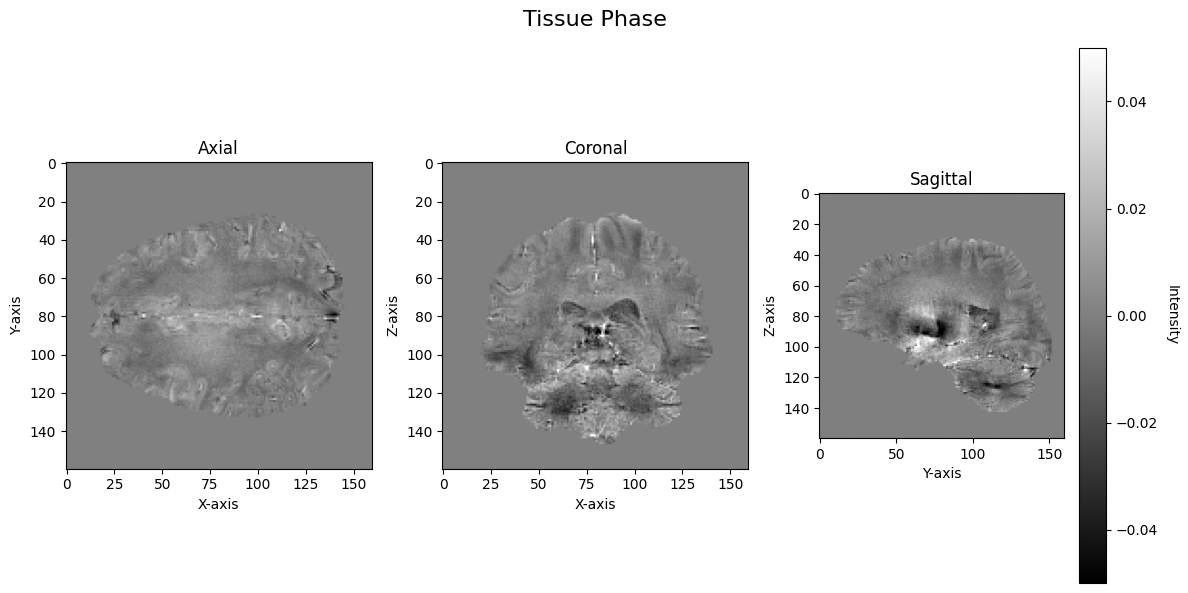

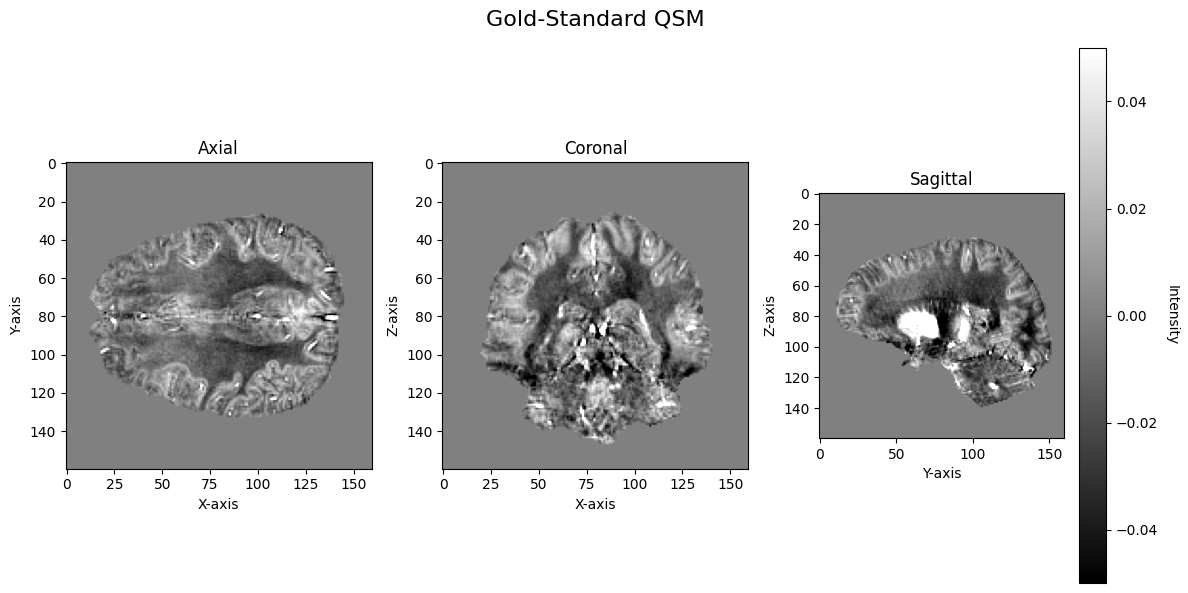

In [6]:
# Loading images by nib library
tissue_phase_brain = nib.load('/content/20170327_qsm2016_recon_challenge/data/phs_tissue.nii.gz').get_data()
gold_standard_qsm = nib.load('/content/20170327_qsm2016_recon_challenge/data/chi_33.nii.gz').get_data()


view_slices_3d(tissue_phase_brain, slice_nbr=100, vmin=-0.05, vmax=0.05, title='Tissue Phase')
view_slices_3d(gold_standard_qsm, slice_nbr=100, vmin=-0.05, vmax=0.05, title='Gold-Standard QSM') 

##### *Simulation of susceptibility distribution*


 ------- Shape Min size: 3.0 ------- 


 ------- Shape Max size: 160.0 ------- 


 ------- Shape Min size: 3.0 ------- 


 ------- Shape Max size: 159.0 ------- 


 ------- Shape Min size: 3.0 ------- 


 ------- Shape Max size: 159.0 ------- 


 ------- Shape Min size: 3.0 ------- 


 ------- Shape Max size: 159.0 ------- 


 ------- Shape Min size: 3.0 ------- 


 ------- Shape Max size: 159.0 ------- 


 ------- Shape Min size: 3.0 ------- 


 ------- Shape Max size: 159.0 ------- 


 ------- Shape Min size: 3.0 ------- 


 ------- Shape Max size: 158.0 ------- 


 ------- Shape Min size: 3.0 ------- 


 ------- Shape Max size: 158.0 ------- 


 ------- Shape Min size: 3.0 ------- 


 ------- Shape Max size: 158.0 ------- 


 ------- Shape Min size: 3.0 ------- 


 ------- Shape Max size: 158.0 ------- 


 ------- Shape Min size: 3.0 ------- 


 ------- Shape Max size: 158.0 ------- 


 ------- Shape Min size: 3.0 ------- 


 ------- Shape Max size: 157.0 ------- 


 ------- Shape 

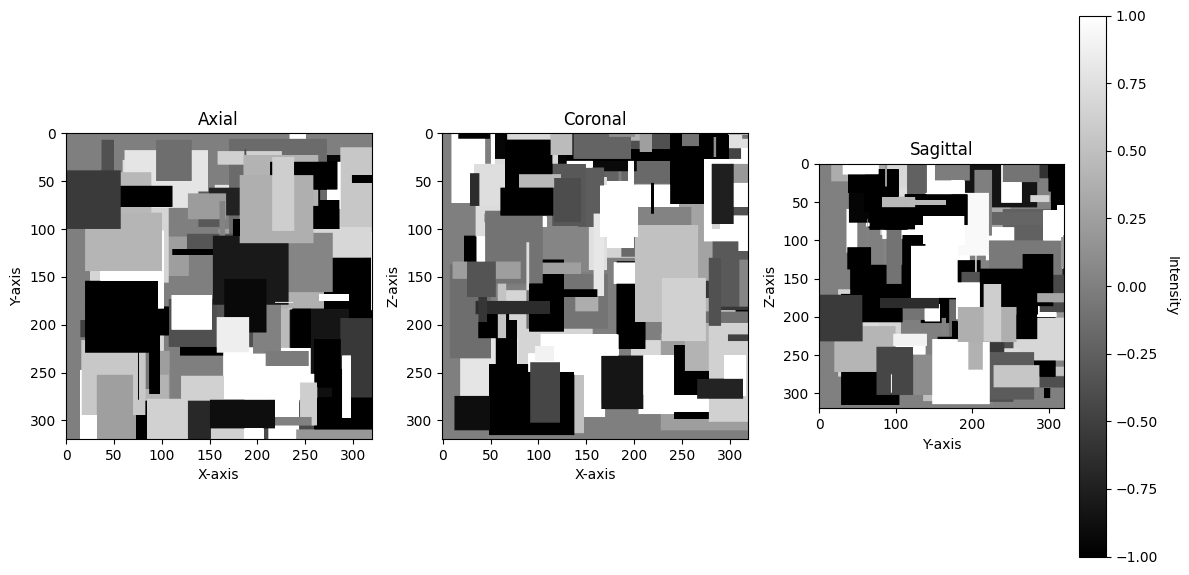

In [15]:
# sim_gt_full = simulated_ground_truth
sim_gt_full = simulate_susceptibility_sources(simulation_dim = 320, rectangles_total = 800, spheres_total = 80,)
view_slices_3d(sim_gt_full, slice_nbr=100, vmin=-1, vmax=1)

##### *Convolve susceptibility distribution with dipole kernel to yield tissue phase* 


Dipole Kernel: The code generates a 3D dipole kernel using the generate_3d_dipole_kernel function. This kernel represents the response of a magnetic dipole in a magnetic resonance imaging (MRI) system. It is used to model the interaction between the sample and the imaging system.

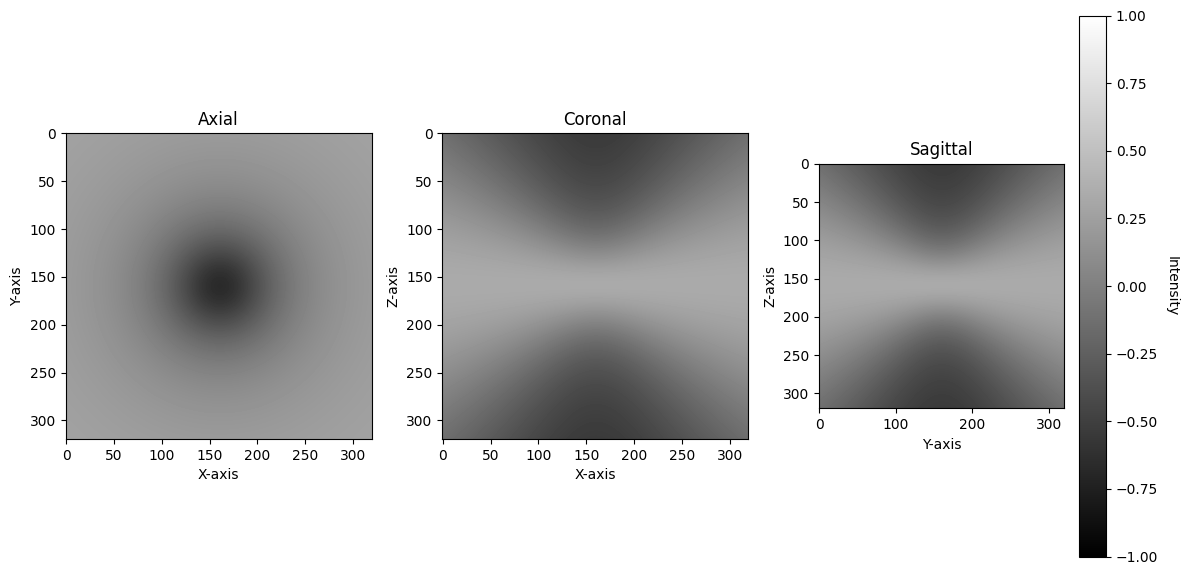

In [8]:
dipole_kernel3d = create_dipole_kernel_3D(sim_gt_full.shape, voxel_size=1, b_vec=[0, 0, 1])
view_slices_3d(dipole_kernel3d, slice_nbr=100, vmin=-1, vmax=1)

- **Fourier Transform:** The code uses the np.fft.fftn function to compute the N-dimensional Fast Fourier Transform (FFT) of the input sample. The np.fft.fftshift function is used to shift the zero-frequency component to the center of the spectrum. This is a common step in Fourier analysis to obtain a more intuitive representation of the data.

- **Inverse Fourier Transform:** The code uses the np.fft.ifftn function to compute the N-dimensional Inverse FFT (IFFT) of the transformed sample. Again, the np.fft.fftshift function is used to shift the zero-frequency component back to the corners of the spectrum.
Scaling: To ensure proper normalization, the code divides the transformed samples by the square root of the sample size (scaling). This step is necessary to preserve the total energy of the data during the Fourier transformations.



- **Multiplication and Convolution:** The code multiplies the transformed sample by the dipole kernel in the Fourier domain. This multiplication corresponds to a convolution operation in the spatial domain. By performing the multiplication in the Fourier domain, the code exploits the convolution theorem, which states that multiplication in the Fourier domain is equivalent to convolution in the spatial domain.

- **Inverse Transform and Rescaling:** After multiplying the transformed sample by the dipole kernel, the code applies the inverse Fourier transform to obtain the spatial representation of the result. The resulting tissue phase is then rescaled by the scaling factor to restore the proper amplitude of the data.

- **Padding and Cropping:** In the forward_convolution_padding function, the input sample is padded with zeros before the Fourier transform to avoid wrap-around artifacts at the edges. After the inverse transform, the padded regions are cropped to match the size of the original sample.

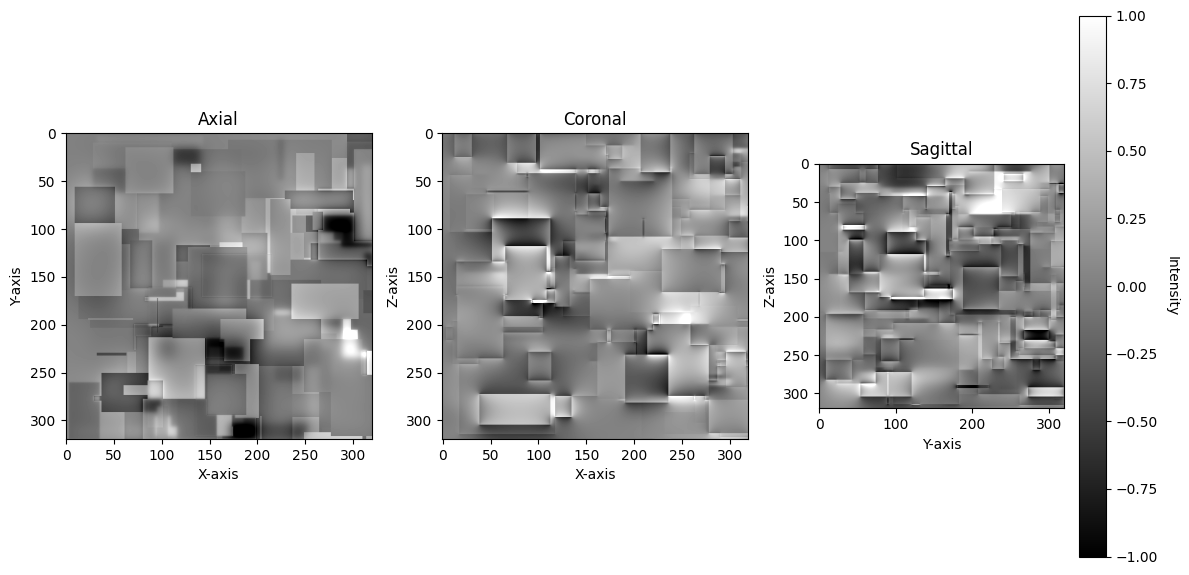

In [9]:
# Simulate tissue phase with padding
simulated_tissue_phase_full = simulate_mri_tissue_phase(sim_gt_full)
view_slices_3d(simulated_tissue_phase_full, slice_nbr=100, vmin=-1, vmax=1)

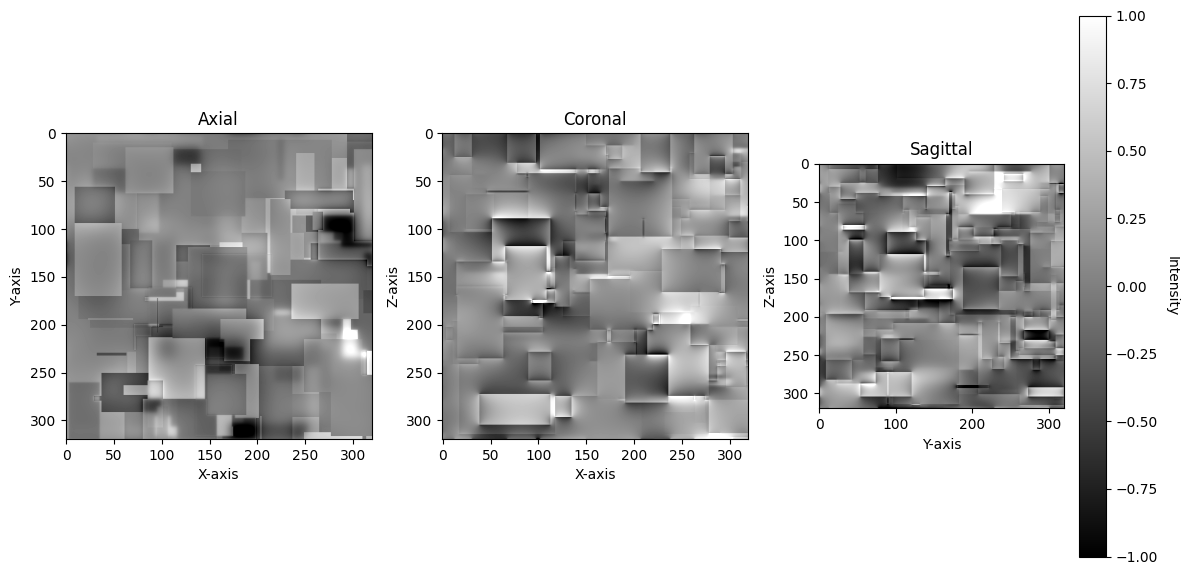

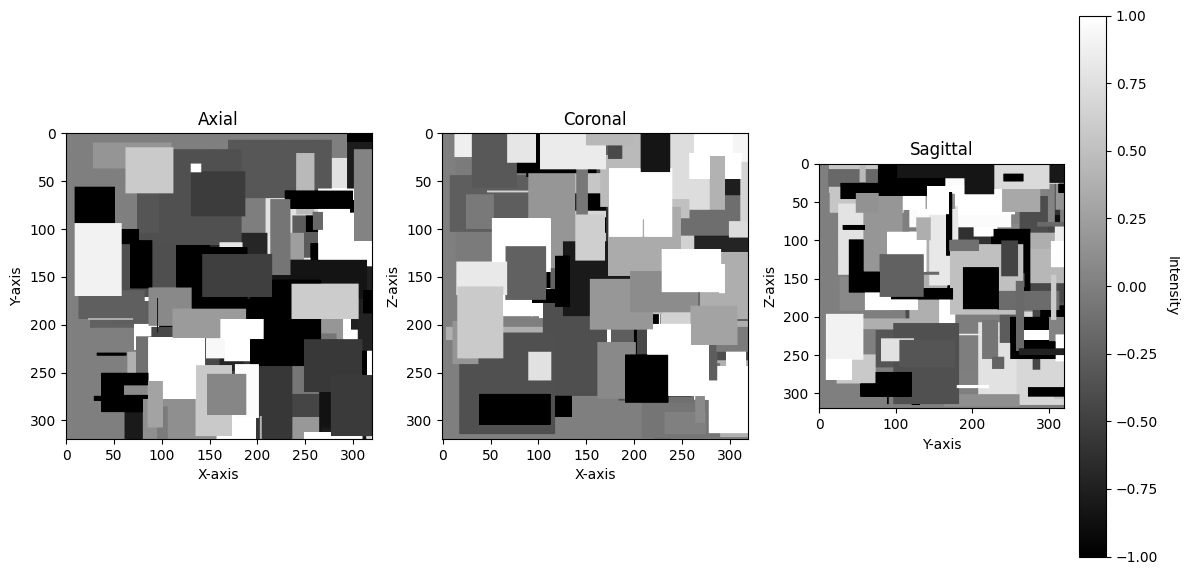

In [10]:
# Simulate tissue phase without padding
simulated_tissue_phase = simulate_mri_tissue_phase_no_padding(sim_gt_full)
view_slices_3d(simulated_tissue_phase, slice_nbr=100, vmin=-1, vmax=1)
view_slices_3d(sim_gt_full, slice_nbr=100, vmin=-1, vmax=1)

#### Training a model to invert the dipole convolution 

###### Prepare patches for training

In [11]:
total_patches = 500
training_dim = 64

# Split patches to train from our simulations in ground truth and forward
simulation_gt_patches = np.zeros((total_patches, training_dim, training_dim, training_dim))
simulation_fw_patches = np.zeros((total_patches, training_dim, training_dim, training_dim))


for patch_idx in range(total_patches):
  simulation_gt_patches[patch_idx, :, :, :], simulation_fw_patches[patch_idx, :, :, :] = create_batch(training_dim, patch_idx,sim_gt_full,simulated_tissue_phase)


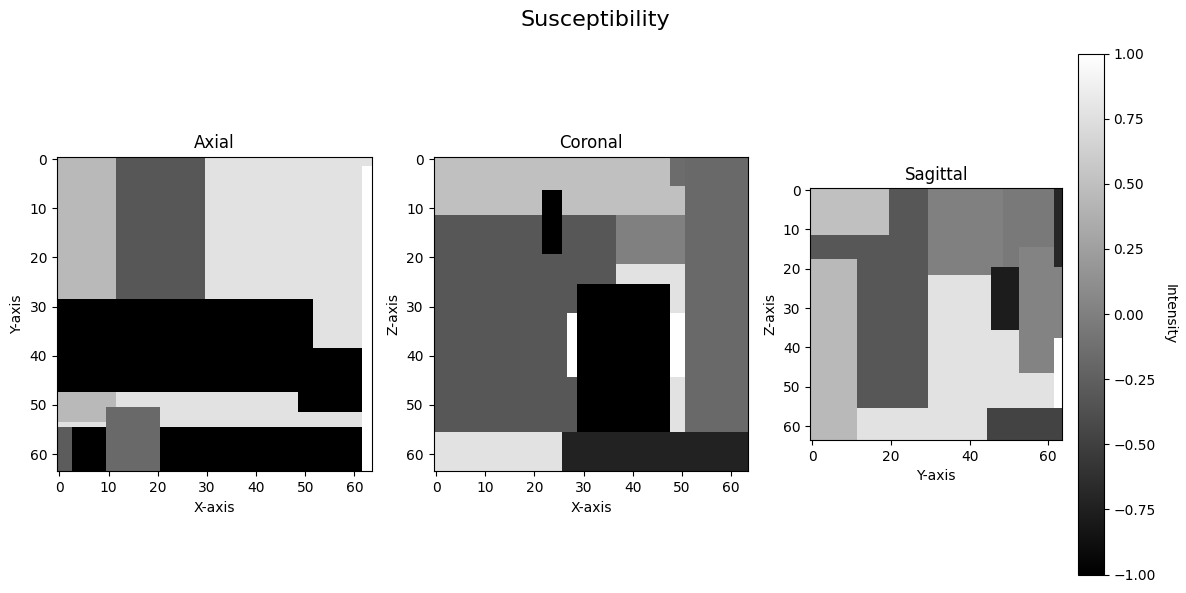

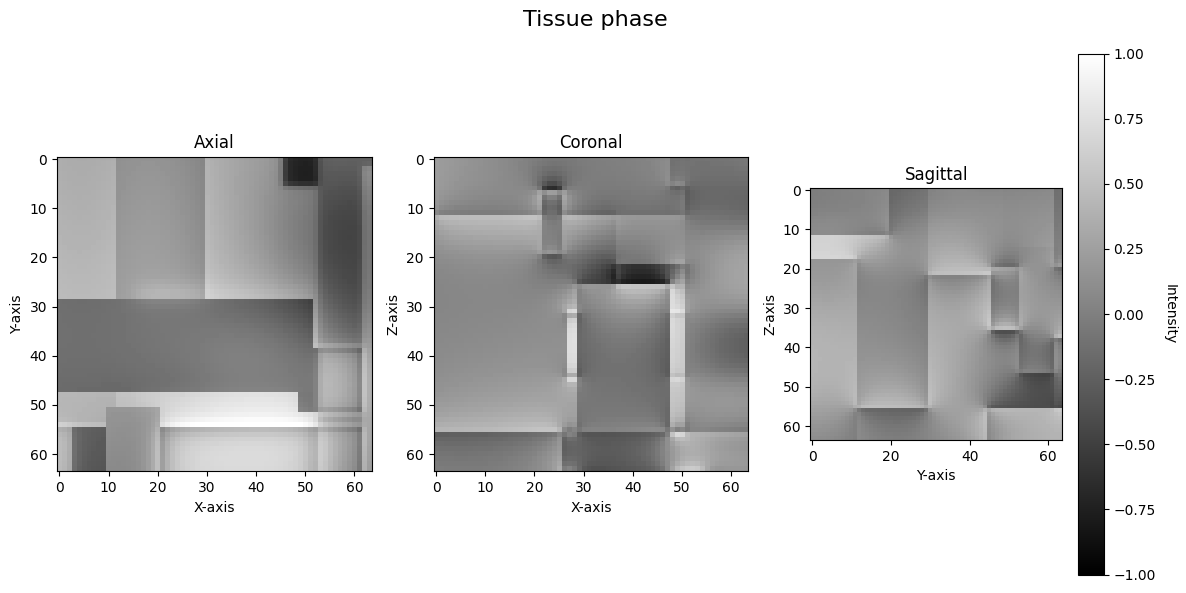

In [12]:
patch_idx = 40
view_slices_3d(simulation_gt_patches[patch_idx, :, :, :], slice_nbr = 16, vmin = -1,vmax = 1, title='Susceptibility')
view_slices_3d(simulation_fw_patches[patch_idx, :, :, :], slice_nbr = 16, vmin = -1,vmax = 1, title='Tissue phase')

##### Building architectures


In [13]:
# Print TensorFlow version
print(tf.__version__)

# Check GPU device availability
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    print('Running without GPU acceleration.')

2.12.0
Found GPU at: /device:GPU:0


###### Utils for architectures

In [30]:
# Utils function to construct the model

def downsample(filters, kernel_size, apply_batch_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    block = tf.keras.Sequential()
    block.add(tf.keras.layers.Conv3D(filters, kernel_size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    if apply_batch_norm:
        block.add(tf.keras.layers.BatchNormalization())
    block.add(tf.keras.layers.LeakyReLU())

    return block


def upsample(filters, kernel_size, apply_dropout=False,dropout=0.5, apply_batch_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    block = tf.keras.Sequential()
    block.add(tf.keras.layers.Conv3DTranspose(filters, kernel_size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    if apply_batch_norm:
        block.add(tf.keras.layers.BatchNormalization())
    if apply_dropout:
        block.add(tf.keras.layers.Dropout(dropout))
    block.add(tf.keras.layers.ReLU())

    return block



class MetricsCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"\nEpoch {epoch+1}:")
        print(f"  - Loss: {logs['loss']:.4f}")
        print(f"  - Mean Squared Error: {logs['mse']:.4f}")


In [16]:
# Testing downsample and upsample functions
inp = simulation_fw_patches[0,:,:,:]
print(f"Origianl shape in fw_pathces: {inp.shape}")
inp = tf.expand_dims(inp,0)
print(f"Expanding shape in fw_pathces first position: {inp.shape}")
inp = tf.expand_dims(inp,4)
print(f"Expanding shape in fw_pathces last position: {inp.shape}")

# Downsample
#(batch,x,y,z,channel)
down_sample = downsample(filters=8, kernel_size=4)
reduction = down_sample(inp)
print(f"Shape in fw_pathces after downsample: {reduction.shape}")

#Upsample
up_sample = upsample(filters=8, kernel_size=4)
expansion = up_sample(reduction)
print(f"Shape in fw_pathces after upsample: {expansion.shape}")

Origianl shape in fw_pathces: (64, 64, 64)
Expanding shape in fw_pathces first position: (1, 64, 64, 64)
Expanding shape in fw_pathces last position: (1, 64, 64, 64, 1)
Shape in fw_pathces after downsample: (1, 32, 32, 32, 8)
Shape in fw_pathces after upsample: (1, 64, 64, 64, 8)


###### ***Parameters***

In [22]:
EPOCHS = 500
PERIOD_TO_STORE = 25
OUTPUT_CHANNELS = 1

###### ***Model 1 - Architecture***

In [18]:
def model_1(filter_base=32, kernel_size=3):
    # Define the downsample blocks
    down_stack = [
        downsample(filter_base, kernel_size, apply_batch_norm=False),  # (base, 32, 32, 32, 64)
        downsample(filter_base * 2, kernel_size),                      # (base, 16, 16, 16, 128)
        downsample(filter_base * 3, kernel_size),                      # (base, 8, 8, 8, 256)
        downsample(filter_base * 4, kernel_size),                      # (base, 4, 4, 4, 512)
        downsample(filter_base * 5, kernel_size),                      # (base, 2, 2, 2, 1024)
    ]

    # Define the upsample blocks
    up_stack = [
        upsample(filter_base * 5, kernel_size, apply_dropout=True),     # (base, 4, 4, 4, 1024)
        upsample(filter_base * 4, kernel_size, apply_dropout=True),     # (base, 8, 8, 8, 512)
        upsample(filter_base * 3, kernel_size, apply_dropout=True),     # (base, 16, 16, 16, 256)
        upsample(filter_base * 2, kernel_size, apply_dropout=True),     # (base, 32, 32, 32, 128)
    ]

    # Define the final layer
    initializer = tf.random_normal_initializer(0., 0.02)
    final_layer = tf.keras.layers.Conv3DTranspose(OUTPUT_CHANNELS,
                                                  kernel_size,
                                                  strides=2,
                                                  padding='same',
                                                  kernel_initializer=initializer,
                                                  activation='tanh')  # (base, 256, 256, 3)

    concatenate = tf.keras.layers.Concatenate()
    inputs = tf.keras.layers.Input(shape=[None, None, None, 1])
    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])  # Reverse the skips for correct order in upsampling

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concatenate([x, skip])

    x = final_layer(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [19]:
from tensorflow.keras.optimizers import Nadam

unet_model1 = model_1()

# Define the learning rate schedule
initial_learning_rate = 0.003
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,  # Adjust this value based on your dataset and training requirements
    decay_rate=0.96  # Adjust this value based on your dataset and training requirements
)

# Create the optimizer with the learning rate schedule
#optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
optimizer = Nadam(learning_rate=lr_schedule)

# Compile the model with the optimizer
unet_model1.compile(loss=losses.mean_squared_error, optimizer=optimizer)
unet_model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 None, 1)]                                                        
                                                                                                  
 sequential_2 (Sequential)      (None, None, None,   864         ['input_1[0][0]']                
                                None, 32)                                                         
                                                                                                  
 sequential_3 (Sequential)      (None, None, None,   55552       ['sequential_2[0][0]']           
                                None, 64)                                                     

###### ***Model 1 - Using the model to predict without training***

Shape of testing data: (1, 64, 64, 64, 1)
1/1 [==============================] - 1s 548ms/step
Shape of testing data: (1, 64, 64, 64, 1)


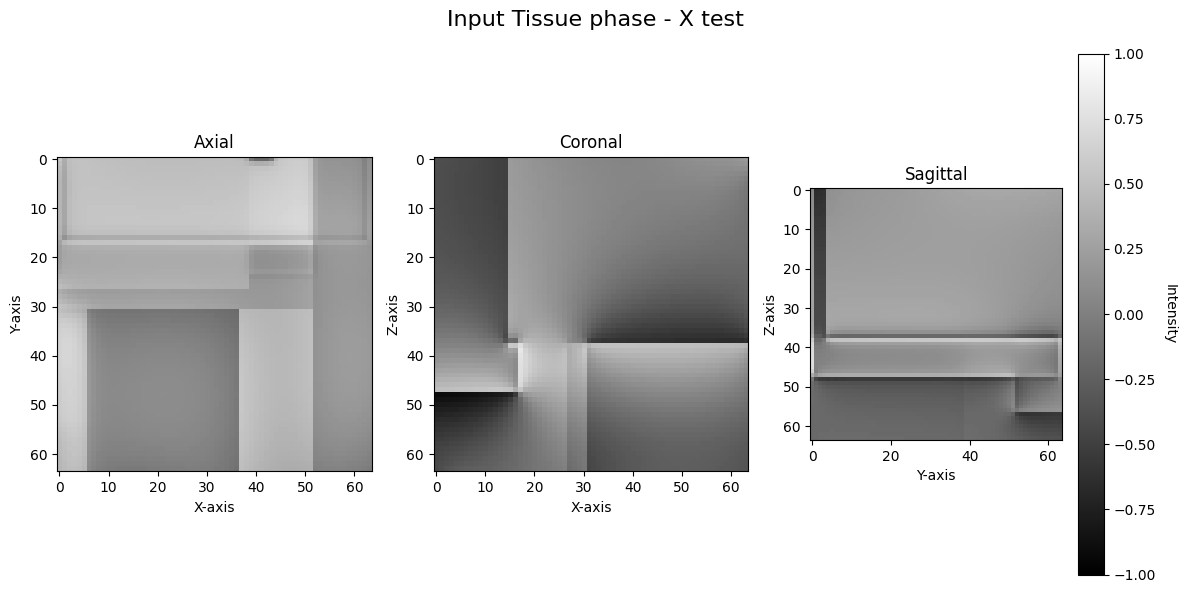

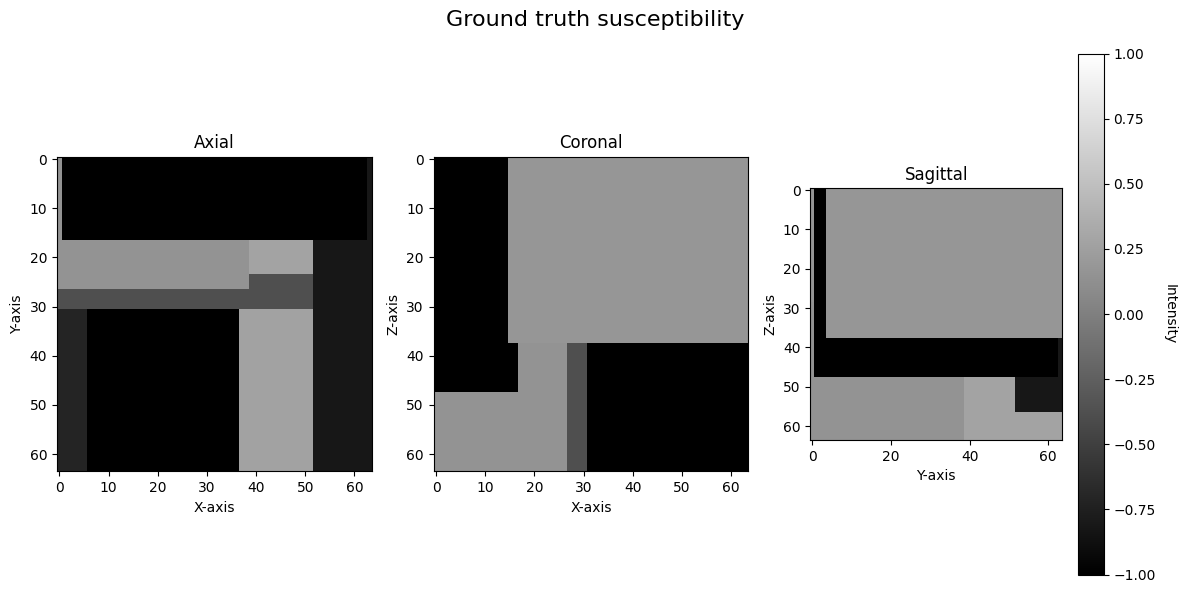

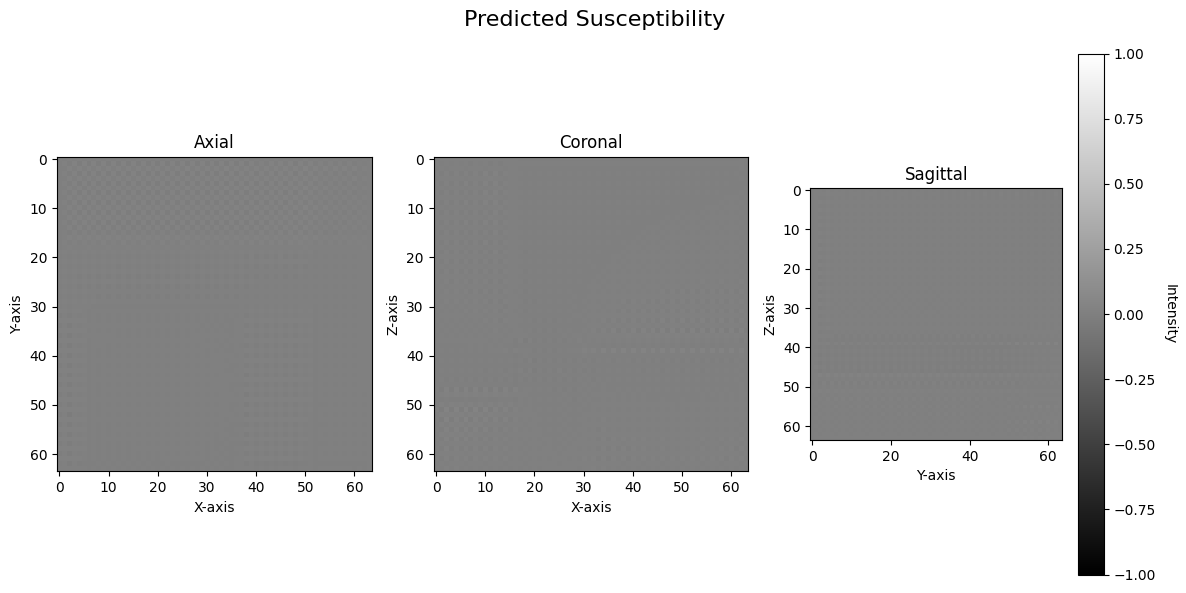

In [ ]:
test_patch_nbr = 10
X_test = simulation_fw_patches[np.newaxis, test_patch_nbr,:,:,:, np.newaxis]
print(f"Shape of testing data: {X_test.shape}")

# Getting prediction from model without training
y_pred = unet_model1.predict(X_test)
print(f"Shape of testing data: {X_test.shape}")
view_slices_3d(X_test[0, :, :, :], slice_nbr = 16, vmin = -1,vmax = 1, title='Input Tissue phase - X test')
view_slices_3d(simulation_gt_patches[test_patch_nbr, :, :, :], slice_nbr = 16, vmin = -1,vmax = 1, title='Ground truth susceptibility')
view_slices_3d(y_pred[0, :, :, :, 0], slice_nbr=16, vmin=-1, vmax=1, title='Predicted Susceptibility')


###### ***Model 1 - Trainning the model***

In [20]:
# Directories to store the checkpoints created
checkpoint_path_1 = "checkpoint_model_1/cp-{epoch:04d}.ckpt"
checkpoint_dir1 = os.path.dirname(checkpoint_path_1)

# Callback to save checkpoints
cp_callback = ModelCheckpoint(
    checkpoint_path_1,
    save_weights_only=True,
    save_freq='epoch',
    verbose=1
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    verbose=1
)

# Split data into training and validation sets
validation_split = 0.2
split_index = int(len(simulation_fw_patches) * (1 - validation_split))
train_images = tf.expand_dims(simulation_fw_patches[:split_index], 4)
train_labels = tf.expand_dims(simulation_gt_patches[:split_index], 4)
val_images = tf.expand_dims(simulation_fw_patches[split_index:], 4)
val_labels = tf.expand_dims(simulation_gt_patches[split_index:], 4)

# Train the model with validation data
loss_history_1 = []
val_loss_history_1 = []  # Store validation loss
with tqdm(total=EPOCHS, desc="Training") as pbar:
    for epoch in range(EPOCHS):
        pbar.set_postfix({'Epoch': epoch+1})
        history_1 = unet_model1.fit(
            train_images,
            train_labels,
            epochs=1,
            batch_size=30,
            shuffle=True,
            validation_data=(val_images, val_labels),
            callbacks=[cp_callback, early_stopping_callback]
        )
        
        loss_history_1.append(history_1.history["loss"][0])
        val_loss_history_1.append(history_1.history["val_loss"][0])  # Store validation loss
        
        # Clear memory after each epoch
        del history_1
        tf.keras.backend.clear_session()
        
        pbar.update(1)

# Save loss history
with open('loss_history_1.pickle', 'wb') as f:
    pickle.dump([loss_history_1, val_loss_history_1, len(loss_history_1)], f)

# After training your model
unet_model1.save("qsm_unet_m1.h5")


Training:   0%|          | 0/200 [00:00<?, ?it/s, Epoch=1]

14/14 [==============================] - ETA: 0s - loss: 0.8145
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 13s 192ms/step - loss: 0.8145 - val_loss: 0.7525


Training:   0%|          | 1/200 [00:13<44:55, 13.55s/it, Epoch=2]

13/14 [==========================>...] - ETA: 0s - loss: 0.5772
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.5727 - val_loss: 0.6446


Training:   1%|          | 2/200 [00:15<22:40,  6.87s/it, Epoch=3]

13/14 [==========================>...] - ETA: 0s - loss: 0.4376
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 107ms/step - loss: 0.4354 - val_loss: 0.6396


Training:   2%|▏         | 3/200 [00:17<15:35,  4.75s/it, Epoch=4]

13/14 [==========================>...] - ETA: 0s - loss: 0.3730
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.3732 - val_loss: 0.6928


Training:   2%|▏         | 4/200 [00:20<12:12,  3.74s/it, Epoch=5]

13/14 [==========================>...] - ETA: 0s - loss: 0.3225
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.3206 - val_loss: 0.7114


Training:   2%|▎         | 5/200 [00:22<10:18,  3.17s/it, Epoch=6]

13/14 [==========================>...] - ETA: 0s - loss: 0.2804
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 104ms/step - loss: 0.2836 - val_loss: 0.7035


Training:   3%|▎         | 6/200 [00:24<09:08,  2.83s/it, Epoch=7]

13/14 [==========================>...] - ETA: 0s - loss: 0.2613
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.2614 - val_loss: 0.6404


Training:   4%|▎         | 7/200 [00:26<08:25,  2.62s/it, Epoch=8]

13/14 [==========================>...] - ETA: 0s - loss: 0.2415
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.2420 - val_loss: 0.6113


Training:   4%|▍         | 8/200 [00:28<07:56,  2.48s/it, Epoch=9]

13/14 [==========================>...] - ETA: 0s - loss: 0.2351
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.2333 - val_loss: 0.6009


Training:   4%|▍         | 9/200 [00:31<07:37,  2.39s/it, Epoch=10]

13/14 [==========================>...] - ETA: 0s - loss: 0.2212
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.2205 - val_loss: 0.6285


Training:   5%|▌         | 10/200 [00:33<07:24,  2.34s/it, Epoch=11]

13/14 [==========================>...] - ETA: 0s - loss: 0.2035
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.2054 - val_loss: 0.5832


Training:   6%|▌         | 11/200 [00:35<07:12,  2.29s/it, Epoch=12]

13/14 [==========================>...] - ETA: 0s - loss: 0.2074
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 103ms/step - loss: 0.2061 - val_loss: 0.5802


Training:   6%|▌         | 12/200 [00:37<07:02,  2.25s/it, Epoch=13]

13/14 [==========================>...] - ETA: 0s - loss: 0.1993
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.2007 - val_loss: 0.5745


Training:   6%|▋         | 13/200 [00:39<06:57,  2.23s/it, Epoch=14]

13/14 [==========================>...] - ETA: 0s - loss: 0.1990
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1979 - val_loss: 0.5165


Training:   7%|▋         | 14/200 [00:42<06:53,  2.22s/it, Epoch=15]

13/14 [==========================>...] - ETA: 0s - loss: 0.1900
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 103ms/step - loss: 0.1899 - val_loss: 0.5198


Training:   8%|▊         | 15/200 [00:44<06:47,  2.20s/it, Epoch=16]

13/14 [==========================>...] - ETA: 0s - loss: 0.1887
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1891 - val_loss: 0.4932


Training:   8%|▊         | 16/200 [00:46<06:45,  2.21s/it, Epoch=17]

13/14 [==========================>...] - ETA: 0s - loss: 0.1848
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1845 - val_loss: 0.4690


Training:   8%|▊         | 17/200 [00:48<06:42,  2.20s/it, Epoch=18]

13/14 [==========================>...] - ETA: 0s - loss: 0.1821
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1815 - val_loss: 0.4343


Training:   9%|▉         | 18/200 [00:50<06:39,  2.20s/it, Epoch=19]

13/14 [==========================>...] - ETA: 0s - loss: 0.1819
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1808 - val_loss: 0.4223


Training:  10%|▉         | 19/200 [00:52<06:36,  2.19s/it, Epoch=20]

13/14 [==========================>...] - ETA: 0s - loss: 0.1770
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1770 - val_loss: 0.3937


Training:  10%|█         | 20/200 [00:55<06:34,  2.19s/it, Epoch=21]

13/14 [==========================>...] - ETA: 0s - loss: 0.1771
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1760 - val_loss: 0.3633


Training:  10%|█         | 21/200 [00:57<06:32,  2.19s/it, Epoch=22]

13/14 [==========================>...] - ETA: 0s - loss: 0.1752
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1759 - val_loss: 0.3593


Training:  11%|█         | 22/200 [00:59<06:30,  2.19s/it, Epoch=23]

13/14 [==========================>...] - ETA: 0s - loss: 0.1737
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 104ms/step - loss: 0.1746 - val_loss: 0.3269


Training:  12%|█▏        | 23/200 [01:01<06:27,  2.19s/it, Epoch=24]

13/14 [==========================>...] - ETA: 0s - loss: 0.1694
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1705 - val_loss: 0.3152


Training:  12%|█▏        | 24/200 [01:03<06:25,  2.19s/it, Epoch=25]

13/14 [==========================>...] - ETA: 0s - loss: 0.1688
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1715 - val_loss: 0.2961


Training:  12%|█▎        | 25/200 [01:06<06:23,  2.19s/it, Epoch=26]

13/14 [==========================>...] - ETA: 0s - loss: 0.1690
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 104ms/step - loss: 0.1694 - val_loss: 0.2790


Training:  13%|█▎        | 26/200 [01:08<06:20,  2.19s/it, Epoch=27]

13/14 [==========================>...] - ETA: 0s - loss: 0.1726
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1715 - val_loss: 0.2708


Training:  14%|█▎        | 27/200 [01:10<06:18,  2.19s/it, Epoch=28]

13/14 [==========================>...] - ETA: 0s - loss: 0.1690
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1696 - val_loss: 0.2589


Training:  14%|█▍        | 28/200 [01:12<06:17,  2.19s/it, Epoch=29]

13/14 [==========================>...] - ETA: 0s - loss: 0.1694
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1688 - val_loss: 0.2479


Training:  14%|█▍        | 29/200 [01:14<06:15,  2.20s/it, Epoch=30]

13/14 [==========================>...] - ETA: 0s - loss: 0.1640
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1666 - val_loss: 0.2410


Training:  15%|█▌        | 30/200 [01:17<06:14,  2.20s/it, Epoch=31]

13/14 [==========================>...] - ETA: 0s - loss: 0.1688
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1689 - val_loss: 0.2331


Training:  16%|█▌        | 31/200 [01:19<06:10,  2.19s/it, Epoch=32]

13/14 [==========================>...] - ETA: 0s - loss: 0.1679
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1661 - val_loss: 0.2343


Training:  16%|█▌        | 32/200 [01:21<06:08,  2.19s/it, Epoch=33]

13/14 [==========================>...] - ETA: 0s - loss: 0.1677
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1668 - val_loss: 0.2163


Training:  16%|█▋        | 33/200 [01:23<06:05,  2.19s/it, Epoch=34]

13/14 [==========================>...] - ETA: 0s - loss: 0.1639
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1644 - val_loss: 0.2265


Training:  17%|█▋        | 34/200 [01:25<06:04,  2.19s/it, Epoch=35]

13/14 [==========================>...] - ETA: 0s - loss: 0.1648
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1664 - val_loss: 0.2281


Training:  18%|█▊        | 35/200 [01:28<06:03,  2.20s/it, Epoch=36]

13/14 [==========================>...] - ETA: 0s - loss: 0.1655
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1648 - val_loss: 0.2145


Training:  18%|█▊        | 36/200 [01:30<06:00,  2.20s/it, Epoch=37]

13/14 [==========================>...] - ETA: 0s - loss: 0.1592
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1623 - val_loss: 0.2076


Training:  18%|█▊        | 37/200 [01:32<05:58,  2.20s/it, Epoch=38]

13/14 [==========================>...] - ETA: 0s - loss: 0.1622
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1616 - val_loss: 0.2056


Training:  19%|█▉        | 38/200 [01:34<05:55,  2.19s/it, Epoch=39]

13/14 [==========================>...] - ETA: 0s - loss: 0.1599
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1605 - val_loss: 0.2051


Training:  20%|█▉        | 39/200 [01:36<05:52,  2.19s/it, Epoch=40]

13/14 [==========================>...] - ETA: 0s - loss: 0.1610
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1607 - val_loss: 0.1992


Training:  20%|██        | 40/200 [01:38<05:50,  2.19s/it, Epoch=41]

13/14 [==========================>...] - ETA: 0s - loss: 0.1608
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1609 - val_loss: 0.2010


Training:  20%|██        | 41/200 [01:41<05:47,  2.19s/it, Epoch=42]

13/14 [==========================>...] - ETA: 0s - loss: 0.1634
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1639 - val_loss: 0.2079


Training:  21%|██        | 42/200 [01:43<05:45,  2.19s/it, Epoch=43]

13/14 [==========================>...] - ETA: 0s - loss: 0.1597
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1595 - val_loss: 0.2029


Training:  22%|██▏       | 43/200 [01:45<05:43,  2.19s/it, Epoch=44]

13/14 [==========================>...] - ETA: 0s - loss: 0.1598
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 104ms/step - loss: 0.1580 - val_loss: 0.2017


Training:  22%|██▏       | 44/200 [01:47<05:40,  2.18s/it, Epoch=45]

13/14 [==========================>...] - ETA: 0s - loss: 0.1624
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 107ms/step - loss: 0.1628 - val_loss: 0.2021


Training:  22%|██▎       | 45/200 [01:49<05:39,  2.19s/it, Epoch=46]

13/14 [==========================>...] - ETA: 0s - loss: 0.1612
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1597 - val_loss: 0.1990


Training:  23%|██▎       | 46/200 [01:52<05:38,  2.20s/it, Epoch=47]

13/14 [==========================>...] - ETA: 0s - loss: 0.1631
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 112ms/step - loss: 0.1621 - val_loss: 0.2029


Training:  24%|██▎       | 47/200 [01:54<05:41,  2.23s/it, Epoch=48]

13/14 [==========================>...] - ETA: 0s - loss: 0.1594
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1598 - val_loss: 0.1972


Training:  24%|██▍       | 48/200 [01:56<05:38,  2.22s/it, Epoch=49]

13/14 [==========================>...] - ETA: 0s - loss: 0.1597
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1591 - val_loss: 0.2000


Training:  24%|██▍       | 49/200 [01:58<05:34,  2.21s/it, Epoch=50]

13/14 [==========================>...] - ETA: 0s - loss: 0.1616
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1603 - val_loss: 0.2044


Training:  25%|██▌       | 50/200 [02:01<05:31,  2.21s/it, Epoch=51]

13/14 [==========================>...] - ETA: 0s - loss: 0.1599
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1623 - val_loss: 0.2046


Training:  26%|██▌       | 51/200 [02:03<05:28,  2.20s/it, Epoch=52]

13/14 [==========================>...] - ETA: 0s - loss: 0.1623
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1652 - val_loss: 0.2083


Training:  26%|██▌       | 52/200 [02:05<05:25,  2.20s/it, Epoch=53]

13/14 [==========================>...] - ETA: 0s - loss: 0.1645
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1620 - val_loss: 0.2070


Training:  26%|██▋       | 53/200 [02:07<05:23,  2.20s/it, Epoch=54]

13/14 [==========================>...] - ETA: 0s - loss: 0.1606
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 104ms/step - loss: 0.1605 - val_loss: 0.1984


Training:  27%|██▋       | 54/200 [02:09<05:20,  2.19s/it, Epoch=55]

13/14 [==========================>...] - ETA: 0s - loss: 0.1553
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1569 - val_loss: 0.1994


Training:  28%|██▊       | 55/200 [02:12<05:18,  2.20s/it, Epoch=56]

13/14 [==========================>...] - ETA: 0s - loss: 0.1572
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1565 - val_loss: 0.2061


Training:  28%|██▊       | 56/200 [02:14<05:16,  2.20s/it, Epoch=57]

13/14 [==========================>...] - ETA: 0s - loss: 0.1570
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1567 - val_loss: 0.1999


Training:  28%|██▊       | 57/200 [02:16<05:15,  2.20s/it, Epoch=58]

13/14 [==========================>...] - ETA: 0s - loss: 0.1565
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1585 - val_loss: 0.1951


Training:  29%|██▉       | 58/200 [02:18<05:11,  2.20s/it, Epoch=59]

13/14 [==========================>...] - ETA: 0s - loss: 0.1557
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 107ms/step - loss: 0.1575 - val_loss: 0.1988


Training:  30%|██▉       | 59/200 [02:20<05:09,  2.20s/it, Epoch=60]

13/14 [==========================>...] - ETA: 0s - loss: 0.1583
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 107ms/step - loss: 0.1570 - val_loss: 0.1958


Training:  30%|███       | 60/200 [02:23<05:08,  2.21s/it, Epoch=61]

13/14 [==========================>...] - ETA: 0s - loss: 0.1557
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1545 - val_loss: 0.1934


Training:  30%|███       | 61/200 [02:25<05:07,  2.21s/it, Epoch=62]

13/14 [==========================>...] - ETA: 0s - loss: 0.1563
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 104ms/step - loss: 0.1553 - val_loss: 0.1968


Training:  31%|███       | 62/200 [02:27<05:04,  2.21s/it, Epoch=63]

13/14 [==========================>...] - ETA: 0s - loss: 0.1541
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1554 - val_loss: 0.1951


Training:  32%|███▏      | 63/200 [02:29<05:02,  2.21s/it, Epoch=64]

13/14 [==========================>...] - ETA: 0s - loss: 0.1575
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1570 - val_loss: 0.1956


Training:  32%|███▏      | 64/200 [02:31<04:59,  2.20s/it, Epoch=65]

13/14 [==========================>...] - ETA: 0s - loss: 0.1552
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1580 - val_loss: 0.1973


Training:  32%|███▎      | 65/200 [02:34<04:56,  2.20s/it, Epoch=66]

13/14 [==========================>...] - ETA: 0s - loss: 0.1541
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1549 - val_loss: 0.1963


Training:  33%|███▎      | 66/200 [02:36<04:55,  2.20s/it, Epoch=67]

13/14 [==========================>...] - ETA: 0s - loss: 0.1568
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 104ms/step - loss: 0.1557 - val_loss: 0.1939


Training:  34%|███▎      | 67/200 [02:38<04:51,  2.19s/it, Epoch=68]

13/14 [==========================>...] - ETA: 0s - loss: 0.1560
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1546 - val_loss: 0.1956


Training:  34%|███▍      | 68/200 [02:40<04:49,  2.19s/it, Epoch=69]

13/14 [==========================>...] - ETA: 0s - loss: 0.1528
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1525 - val_loss: 0.1951


Training:  34%|███▍      | 69/200 [02:42<04:46,  2.19s/it, Epoch=70]

13/14 [==========================>...] - ETA: 0s - loss: 0.1546
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 104ms/step - loss: 0.1528 - val_loss: 0.1941


Training:  35%|███▌      | 70/200 [02:44<04:43,  2.18s/it, Epoch=71]

13/14 [==========================>...] - ETA: 0s - loss: 0.1542
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1532 - val_loss: 0.1947


Training:  36%|███▌      | 71/200 [02:47<04:41,  2.18s/it, Epoch=72]

13/14 [==========================>...] - ETA: 0s - loss: 0.1510
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1530 - val_loss: 0.1905


Training:  36%|███▌      | 72/200 [02:49<04:39,  2.19s/it, Epoch=73]

13/14 [==========================>...] - ETA: 0s - loss: 0.1559
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1571 - val_loss: 0.1961


Training:  36%|███▋      | 73/200 [02:51<04:38,  2.19s/it, Epoch=74]

13/14 [==========================>...] - ETA: 0s - loss: 0.1529
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 104ms/step - loss: 0.1528 - val_loss: 0.1937


Training:  37%|███▋      | 74/200 [02:53<04:35,  2.19s/it, Epoch=75]

13/14 [==========================>...] - ETA: 0s - loss: 0.1539
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1528 - val_loss: 0.1915


Training:  38%|███▊      | 75/200 [02:55<04:32,  2.18s/it, Epoch=76]

13/14 [==========================>...] - ETA: 0s - loss: 0.1525
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1522 - val_loss: 0.1926


Training:  38%|███▊      | 76/200 [02:58<04:30,  2.18s/it, Epoch=77]

13/14 [==========================>...] - ETA: 0s - loss: 0.1488
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1529 - val_loss: 0.1949


Training:  38%|███▊      | 77/200 [03:00<04:28,  2.18s/it, Epoch=78]

13/14 [==========================>...] - ETA: 0s - loss: 0.1530
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1521 - val_loss: 0.1915


Training:  39%|███▉      | 78/200 [03:02<04:25,  2.18s/it, Epoch=79]

13/14 [==========================>...] - ETA: 0s - loss: 0.1515
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1511 - val_loss: 0.1919


Training:  40%|███▉      | 79/200 [03:04<04:23,  2.18s/it, Epoch=80]

13/14 [==========================>...] - ETA: 0s - loss: 0.1511
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 104ms/step - loss: 0.1522 - val_loss: 0.1958


Training:  40%|████      | 80/200 [03:06<04:20,  2.17s/it, Epoch=81]

13/14 [==========================>...] - ETA: 0s - loss: 0.1540
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1545 - val_loss: 0.1937


Training:  40%|████      | 81/200 [03:08<04:19,  2.18s/it, Epoch=82]

13/14 [==========================>...] - ETA: 0s - loss: 0.1487
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 104ms/step - loss: 0.1511 - val_loss: 0.1917


Training:  41%|████      | 82/200 [03:11<04:17,  2.18s/it, Epoch=83]

13/14 [==========================>...] - ETA: 0s - loss: 0.1537
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1519 - val_loss: 0.1953


Training:  42%|████▏     | 83/200 [03:13<04:15,  2.18s/it, Epoch=84]

13/14 [==========================>...] - ETA: 0s - loss: 0.1539
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1527 - val_loss: 0.1962


Training:  42%|████▏     | 84/200 [03:15<04:13,  2.18s/it, Epoch=85]

13/14 [==========================>...] - ETA: 0s - loss: 0.1527
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1520 - val_loss: 0.1961


Training:  42%|████▎     | 85/200 [03:17<04:11,  2.18s/it, Epoch=86]

13/14 [==========================>...] - ETA: 0s - loss: 0.1501
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1516 - val_loss: 0.1924


Training:  43%|████▎     | 86/200 [03:19<04:09,  2.19s/it, Epoch=87]

13/14 [==========================>...] - ETA: 0s - loss: 0.1500
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1504 - val_loss: 0.1928


Training:  44%|████▎     | 87/200 [03:22<04:07,  2.19s/it, Epoch=88]

13/14 [==========================>...] - ETA: 0s - loss: 0.1513
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 104ms/step - loss: 0.1501 - val_loss: 0.1930


Training:  44%|████▍     | 88/200 [03:24<04:04,  2.19s/it, Epoch=89]

13/14 [==========================>...] - ETA: 0s - loss: 0.1482
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1495 - val_loss: 0.1932


Training:  44%|████▍     | 89/200 [03:26<04:02,  2.19s/it, Epoch=90]

13/14 [==========================>...] - ETA: 0s - loss: 0.1495
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1514 - val_loss: 0.2061


Training:  45%|████▌     | 90/200 [03:28<04:00,  2.19s/it, Epoch=91]

13/14 [==========================>...] - ETA: 0s - loss: 0.1535
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1544 - val_loss: 0.1966


Training:  46%|████▌     | 91/200 [03:30<03:59,  2.20s/it, Epoch=92]

13/14 [==========================>...] - ETA: 0s - loss: 0.1541
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1534 - val_loss: 0.1935


Training:  46%|████▌     | 92/200 [03:33<03:57,  2.20s/it, Epoch=93]

13/14 [==========================>...] - ETA: 0s - loss: 0.1515
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1522 - val_loss: 0.2021


Training:  46%|████▋     | 93/200 [03:35<03:54,  2.19s/it, Epoch=94]

13/14 [==========================>...] - ETA: 0s - loss: 0.1536
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1527 - val_loss: 0.1925


Training:  47%|████▋     | 94/200 [03:37<03:52,  2.19s/it, Epoch=95]

13/14 [==========================>...] - ETA: 0s - loss: 0.1510
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1512 - val_loss: 0.1948


Training:  48%|████▊     | 95/200 [03:39<03:49,  2.19s/it, Epoch=96]

13/14 [==========================>...] - ETA: 0s - loss: 0.1519
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 3s 110ms/step - loss: 0.1515 - val_loss: 0.1916


Training:  48%|████▊     | 96/200 [03:42<04:16,  2.46s/it, Epoch=97]

13/14 [==========================>...] - ETA: 0s - loss: 0.1523
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 3s 109ms/step - loss: 0.1515 - val_loss: 0.1921


Training:  48%|████▊     | 97/200 [03:45<04:20,  2.53s/it, Epoch=98]

13/14 [==========================>...] - ETA: 0s - loss: 0.1495
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1502 - val_loss: 0.1956


Training:  49%|████▉     | 98/200 [03:47<04:15,  2.51s/it, Epoch=99]

13/14 [==========================>...] - ETA: 0s - loss: 0.1550
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1537 - val_loss: 0.1950


Training:  50%|████▉     | 99/200 [03:50<04:08,  2.46s/it, Epoch=100]

13/14 [==========================>...] - ETA: 0s - loss: 0.1525
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1523 - val_loss: 0.1913


Training:  50%|█████     | 100/200 [03:52<04:01,  2.42s/it, Epoch=101]

13/14 [==========================>...] - ETA: 0s - loss: 0.1499
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1517 - val_loss: 0.1939


Training:  50%|█████     | 101/200 [03:54<03:54,  2.37s/it, Epoch=102]

13/14 [==========================>...] - ETA: 0s - loss: 0.1488
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 104ms/step - loss: 0.1503 - val_loss: 0.1897


Training:  51%|█████     | 102/200 [03:57<03:47,  2.32s/it, Epoch=103]

13/14 [==========================>...] - ETA: 0s - loss: 0.1505
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1502 - val_loss: 0.1917


Training:  52%|█████▏    | 103/200 [03:59<03:41,  2.29s/it, Epoch=104]

13/14 [==========================>...] - ETA: 0s - loss: 0.1492
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1486 - val_loss: 0.1919


Training:  52%|█████▏    | 104/200 [04:01<03:36,  2.26s/it, Epoch=105]

13/14 [==========================>...] - ETA: 0s - loss: 0.1537
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 104ms/step - loss: 0.1526 - val_loss: 0.1944


Training:  52%|█████▎    | 105/200 [04:03<03:32,  2.23s/it, Epoch=106]

13/14 [==========================>...] - ETA: 0s - loss: 0.1512
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 107ms/step - loss: 0.1500 - val_loss: 0.1944


Training:  53%|█████▎    | 106/200 [04:05<03:29,  2.22s/it, Epoch=107]

13/14 [==========================>...] - ETA: 0s - loss: 0.1506
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1495 - val_loss: 0.1941


Training:  54%|█████▎    | 107/200 [04:07<03:25,  2.21s/it, Epoch=108]

13/14 [==========================>...] - ETA: 0s - loss: 0.1496
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1492 - val_loss: 0.1955


Training:  54%|█████▍    | 108/200 [04:10<03:22,  2.20s/it, Epoch=109]

13/14 [==========================>...] - ETA: 0s - loss: 0.1476
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1491 - val_loss: 0.1949


Training:  55%|█████▍    | 109/200 [04:12<03:20,  2.20s/it, Epoch=110]

13/14 [==========================>...] - ETA: 0s - loss: 0.1483
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1492 - val_loss: 0.1976


Training:  55%|█████▌    | 110/200 [04:14<03:17,  2.20s/it, Epoch=111]

13/14 [==========================>...] - ETA: 0s - loss: 0.1508
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1499 - val_loss: 0.1933


Training:  56%|█████▌    | 111/200 [04:16<03:15,  2.20s/it, Epoch=112]

13/14 [==========================>...] - ETA: 0s - loss: 0.1513
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1497 - val_loss: 0.1928


Training:  56%|█████▌    | 112/200 [04:18<03:13,  2.20s/it, Epoch=113]

13/14 [==========================>...] - ETA: 0s - loss: 0.1482
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1486 - val_loss: 0.1955


Training:  56%|█████▋    | 113/200 [04:21<03:11,  2.20s/it, Epoch=114]

13/14 [==========================>...] - ETA: 0s - loss: 0.1503
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1505 - val_loss: 0.1943


Training:  57%|█████▋    | 114/200 [04:23<03:09,  2.21s/it, Epoch=115]

13/14 [==========================>...] - ETA: 0s - loss: 0.1471
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1497 - val_loss: 0.1998


Training:  57%|█████▊    | 115/200 [04:25<03:07,  2.20s/it, Epoch=116]

13/14 [==========================>...] - ETA: 0s - loss: 0.1519
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1508 - val_loss: 0.1968


Training:  58%|█████▊    | 116/200 [04:27<03:04,  2.20s/it, Epoch=117]

13/14 [==========================>...] - ETA: 0s - loss: 0.1518
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1513 - val_loss: 0.1934


Training:  58%|█████▊    | 117/200 [04:29<03:02,  2.20s/it, Epoch=118]

13/14 [==========================>...] - ETA: 0s - loss: 0.1498
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 104ms/step - loss: 0.1493 - val_loss: 0.1903


Training:  59%|█████▉    | 118/200 [04:32<03:00,  2.20s/it, Epoch=119]

13/14 [==========================>...] - ETA: 0s - loss: 0.1491
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1480 - val_loss: 0.1912


Training:  60%|█████▉    | 119/200 [04:34<02:57,  2.19s/it, Epoch=120]

13/14 [==========================>...] - ETA: 0s - loss: 0.1477
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1475 - val_loss: 0.1916


Training:  60%|██████    | 120/200 [04:36<02:55,  2.19s/it, Epoch=121]

13/14 [==========================>...] - ETA: 0s - loss: 0.1481
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 104ms/step - loss: 0.1480 - val_loss: 0.1940


Training:  60%|██████    | 121/200 [04:38<02:52,  2.19s/it, Epoch=122]

13/14 [==========================>...] - ETA: 0s - loss: 0.1485
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 107ms/step - loss: 0.1489 - val_loss: 0.1964


Training:  61%|██████    | 122/200 [04:40<02:51,  2.19s/it, Epoch=123]

13/14 [==========================>...] - ETA: 0s - loss: 0.1459
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1482 - val_loss: 0.1957


Training:  62%|██████▏   | 123/200 [04:43<02:49,  2.20s/it, Epoch=124]

13/14 [==========================>...] - ETA: 0s - loss: 0.1452
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1479 - val_loss: 0.1945


Training:  62%|██████▏   | 124/200 [04:45<02:47,  2.20s/it, Epoch=125]

13/14 [==========================>...] - ETA: 0s - loss: 0.1508
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1485 - val_loss: 0.1925


Training:  62%|██████▎   | 125/200 [04:47<02:45,  2.21s/it, Epoch=126]

13/14 [==========================>...] - ETA: 0s - loss: 0.1510
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1500 - val_loss: 0.1955


Training:  63%|██████▎   | 126/200 [04:49<02:43,  2.21s/it, Epoch=127]

13/14 [==========================>...] - ETA: 0s - loss: 0.1491
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1503 - val_loss: 0.1948


Training:  64%|██████▎   | 127/200 [04:51<02:41,  2.21s/it, Epoch=128]

13/14 [==========================>...] - ETA: 0s - loss: 0.1490
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 104ms/step - loss: 0.1476 - val_loss: 0.1900


Training:  64%|██████▍   | 128/200 [04:54<02:39,  2.21s/it, Epoch=129]

13/14 [==========================>...] - ETA: 0s - loss: 0.1494
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1491 - val_loss: 0.1937


Training:  64%|██████▍   | 129/200 [04:56<02:36,  2.20s/it, Epoch=130]

13/14 [==========================>...] - ETA: 0s - loss: 0.1475
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1471 - val_loss: 0.1949


Training:  65%|██████▌   | 130/200 [04:58<02:33,  2.20s/it, Epoch=131]

13/14 [==========================>...] - ETA: 0s - loss: 0.1475
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1483 - val_loss: 0.1950


Training:  66%|██████▌   | 131/200 [05:00<02:31,  2.19s/it, Epoch=132]

13/14 [==========================>...] - ETA: 0s - loss: 0.1498
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1484 - val_loss: 0.1938


Training:  66%|██████▌   | 132/200 [05:02<02:29,  2.20s/it, Epoch=133]

13/14 [==========================>...] - ETA: 0s - loss: 0.1516
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1499 - val_loss: 0.1940


Training:  66%|██████▋   | 133/200 [05:05<02:27,  2.20s/it, Epoch=134]

13/14 [==========================>...] - ETA: 0s - loss: 0.1487
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1470 - val_loss: 0.1958


Training:  67%|██████▋   | 134/200 [05:07<02:25,  2.20s/it, Epoch=135]

13/14 [==========================>...] - ETA: 0s - loss: 0.1476
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1486 - val_loss: 0.1937


Training:  68%|██████▊   | 135/200 [05:09<02:23,  2.20s/it, Epoch=136]

13/14 [==========================>...] - ETA: 0s - loss: 0.1502
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1490 - val_loss: 0.1962


Training:  68%|██████▊   | 136/200 [05:11<02:20,  2.20s/it, Epoch=137]

13/14 [==========================>...] - ETA: 0s - loss: 0.1503
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1489 - val_loss: 0.1956


Training:  68%|██████▊   | 137/200 [05:13<02:18,  2.20s/it, Epoch=138]

13/14 [==========================>...] - ETA: 0s - loss: 0.1483
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1493 - val_loss: 0.2244


Training:  69%|██████▉   | 138/200 [05:16<02:16,  2.20s/it, Epoch=139]

13/14 [==========================>...] - ETA: 0s - loss: 0.1545
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1533 - val_loss: 0.1987


Training:  70%|██████▉   | 139/200 [05:18<02:14,  2.20s/it, Epoch=140]

13/14 [==========================>...] - ETA: 0s - loss: 0.1506
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1504 - val_loss: 0.1896


Training:  70%|███████   | 140/200 [05:20<02:11,  2.20s/it, Epoch=141]

13/14 [==========================>...] - ETA: 0s - loss: 0.1503
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 104ms/step - loss: 0.1497 - val_loss: 0.1946


Training:  70%|███████   | 141/200 [05:22<02:09,  2.19s/it, Epoch=142]

13/14 [==========================>...] - ETA: 0s - loss: 0.1493
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1481 - val_loss: 0.1931


Training:  71%|███████   | 142/200 [05:24<02:07,  2.20s/it, Epoch=143]

13/14 [==========================>...] - ETA: 0s - loss: 0.1490
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1478 - val_loss: 0.1935


Training:  72%|███████▏  | 143/200 [05:27<02:05,  2.20s/it, Epoch=144]

13/14 [==========================>...] - ETA: 0s - loss: 0.1491
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1475 - val_loss: 0.1964


Training:  72%|███████▏  | 144/200 [05:29<02:02,  2.20s/it, Epoch=145]

13/14 [==========================>...] - ETA: 0s - loss: 0.1490
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1473 - val_loss: 0.1943


Training:  72%|███████▎  | 145/200 [05:31<02:00,  2.19s/it, Epoch=146]

13/14 [==========================>...] - ETA: 0s - loss: 0.1463
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 104ms/step - loss: 0.1467 - val_loss: 0.1912


Training:  73%|███████▎  | 146/200 [05:33<01:58,  2.19s/it, Epoch=147]

13/14 [==========================>...] - ETA: 0s - loss: 0.1462
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1476 - val_loss: 0.1961


Training:  74%|███████▎  | 147/200 [05:35<01:56,  2.20s/it, Epoch=148]

13/14 [==========================>...] - ETA: 0s - loss: 0.1488
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1485 - val_loss: 0.1962


Training:  74%|███████▍  | 148/200 [05:38<01:54,  2.20s/it, Epoch=149]

13/14 [==========================>...] - ETA: 0s - loss: 0.1493
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 104ms/step - loss: 0.1473 - val_loss: 0.1945


Training:  74%|███████▍  | 149/200 [05:40<01:52,  2.20s/it, Epoch=150]

13/14 [==========================>...] - ETA: 0s - loss: 0.1472
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1480 - val_loss: 0.1964


Training:  75%|███████▌  | 150/200 [05:42<01:50,  2.20s/it, Epoch=151]

13/14 [==========================>...] - ETA: 0s - loss: 0.1482
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1470 - val_loss: 0.1945


Training:  76%|███████▌  | 151/200 [05:44<01:47,  2.20s/it, Epoch=152]

13/14 [==========================>...] - ETA: 0s - loss: 0.1449
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1468 - val_loss: 0.1920


Training:  76%|███████▌  | 152/200 [05:46<01:45,  2.20s/it, Epoch=153]

13/14 [==========================>...] - ETA: 0s - loss: 0.1470
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1467 - val_loss: 0.1947


Training:  76%|███████▋  | 153/200 [05:49<01:43,  2.20s/it, Epoch=154]

13/14 [==========================>...] - ETA: 0s - loss: 0.1479
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 104ms/step - loss: 0.1465 - val_loss: 0.2013


Training:  77%|███████▋  | 154/200 [05:51<01:41,  2.20s/it, Epoch=155]

13/14 [==========================>...] - ETA: 0s - loss: 0.1482
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 104ms/step - loss: 0.1478 - val_loss: 0.1924


Training:  78%|███████▊  | 155/200 [05:53<01:38,  2.19s/it, Epoch=156]

13/14 [==========================>...] - ETA: 0s - loss: 0.1497
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 104ms/step - loss: 0.1476 - val_loss: 0.2000


Training:  78%|███████▊  | 156/200 [05:55<01:35,  2.18s/it, Epoch=157]

13/14 [==========================>...] - ETA: 0s - loss: 0.1484
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1474 - val_loss: 0.1959


Training:  78%|███████▊  | 157/200 [05:57<01:33,  2.18s/it, Epoch=158]

13/14 [==========================>...] - ETA: 0s - loss: 0.1486
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1466 - val_loss: 0.1950


Training:  79%|███████▉  | 158/200 [06:00<01:32,  2.19s/it, Epoch=159]

13/14 [==========================>...] - ETA: 0s - loss: 0.1461
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1458 - val_loss: 0.1944


Training:  80%|███████▉  | 159/200 [06:02<01:30,  2.20s/it, Epoch=160]

13/14 [==========================>...] - ETA: 0s - loss: 0.1440
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 104ms/step - loss: 0.1469 - val_loss: 0.1943


Training:  80%|████████  | 160/200 [06:04<01:27,  2.19s/it, Epoch=161]

13/14 [==========================>...] - ETA: 0s - loss: 0.1468
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 104ms/step - loss: 0.1467 - val_loss: 0.1989


Training:  80%|████████  | 161/200 [06:06<01:25,  2.19s/it, Epoch=162]

13/14 [==========================>...] - ETA: 0s - loss: 0.1467
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 104ms/step - loss: 0.1470 - val_loss: 0.2074


Training:  81%|████████  | 162/200 [06:08<01:23,  2.19s/it, Epoch=163]

13/14 [==========================>...] - ETA: 0s - loss: 0.1501
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 104ms/step - loss: 0.1517 - val_loss: 0.2052


Training:  82%|████████▏ | 163/200 [06:10<01:20,  2.18s/it, Epoch=164]

13/14 [==========================>...] - ETA: 0s - loss: 0.1500
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1508 - val_loss: 0.1961


Training:  82%|████████▏ | 164/200 [06:13<01:18,  2.19s/it, Epoch=165]

13/14 [==========================>...] - ETA: 0s - loss: 0.1496
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1487 - val_loss: 0.1942


Training:  82%|████████▎ | 165/200 [06:15<01:16,  2.19s/it, Epoch=166]

13/14 [==========================>...] - ETA: 0s - loss: 0.1474
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1473 - val_loss: 0.1938


Training:  83%|████████▎ | 166/200 [06:17<01:14,  2.19s/it, Epoch=167]

13/14 [==========================>...] - ETA: 0s - loss: 0.1487
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1475 - val_loss: 0.1933


Training:  84%|████████▎ | 167/200 [06:19<01:12,  2.19s/it, Epoch=168]

13/14 [==========================>...] - ETA: 0s - loss: 0.1486
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1472 - val_loss: 0.1963


Training:  84%|████████▍ | 168/200 [06:21<01:10,  2.19s/it, Epoch=169]

13/14 [==========================>...] - ETA: 0s - loss: 0.1466
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1468 - val_loss: 0.1915


Training:  84%|████████▍ | 169/200 [06:24<01:07,  2.19s/it, Epoch=170]

13/14 [==========================>...] - ETA: 0s - loss: 0.1469
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 104ms/step - loss: 0.1459 - val_loss: 0.1906


Training:  85%|████████▌ | 170/200 [06:26<01:05,  2.19s/it, Epoch=171]

13/14 [==========================>...] - ETA: 0s - loss: 0.1442
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 104ms/step - loss: 0.1464 - val_loss: 0.1926


Training:  86%|████████▌ | 171/200 [06:28<01:03,  2.19s/it, Epoch=172]

13/14 [==========================>...] - ETA: 0s - loss: 0.1485
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1468 - val_loss: 0.1975


Training:  86%|████████▌ | 172/200 [06:30<01:01,  2.19s/it, Epoch=173]

13/14 [==========================>...] - ETA: 0s - loss: 0.1489
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 104ms/step - loss: 0.1470 - val_loss: 0.1950


Training:  86%|████████▋ | 173/200 [06:32<00:59,  2.19s/it, Epoch=174]

13/14 [==========================>...] - ETA: 0s - loss: 0.1458
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1466 - val_loss: 0.1953


Training:  87%|████████▋ | 174/200 [06:35<00:56,  2.19s/it, Epoch=175]

13/14 [==========================>...] - ETA: 0s - loss: 0.1468
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1467 - val_loss: 0.1951


Training:  88%|████████▊ | 175/200 [06:37<00:54,  2.19s/it, Epoch=176]

13/14 [==========================>...] - ETA: 0s - loss: 0.1440
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1459 - val_loss: 0.1957


Training:  88%|████████▊ | 176/200 [06:39<00:52,  2.18s/it, Epoch=177]

13/14 [==========================>...] - ETA: 0s - loss: 0.1437
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1456 - val_loss: 0.1930


Training:  88%|████████▊ | 177/200 [06:41<00:50,  2.19s/it, Epoch=178]

13/14 [==========================>...] - ETA: 0s - loss: 0.1459
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1450 - val_loss: 0.1936


Training:  89%|████████▉ | 178/200 [06:43<00:48,  2.19s/it, Epoch=179]

13/14 [==========================>...] - ETA: 0s - loss: 0.1420
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1448 - val_loss: 0.1968


Training:  90%|████████▉ | 179/200 [06:46<00:46,  2.21s/it, Epoch=180]

13/14 [==========================>...] - ETA: 0s - loss: 0.1468
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1457 - val_loss: 0.1961


Training:  90%|█████████ | 180/200 [06:48<00:44,  2.21s/it, Epoch=181]

13/14 [==========================>...] - ETA: 0s - loss: 0.1448
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1454 - val_loss: 0.1957


Training:  90%|█████████ | 181/200 [06:50<00:42,  2.21s/it, Epoch=182]

13/14 [==========================>...] - ETA: 0s - loss: 0.1469
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 104ms/step - loss: 0.1456 - val_loss: 0.1968


Training:  91%|█████████ | 182/200 [06:52<00:39,  2.20s/it, Epoch=183]

13/14 [==========================>...] - ETA: 0s - loss: 0.1466
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1460 - val_loss: 0.1941


Training:  92%|█████████▏| 183/200 [06:54<00:37,  2.19s/it, Epoch=184]

13/14 [==========================>...] - ETA: 0s - loss: 0.1461
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1457 - val_loss: 0.1971


Training:  92%|█████████▏| 184/200 [06:57<00:35,  2.19s/it, Epoch=185]

13/14 [==========================>...] - ETA: 0s - loss: 0.1436
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1452 - val_loss: 0.1978


Training:  92%|█████████▎| 185/200 [06:59<00:32,  2.20s/it, Epoch=186]

13/14 [==========================>...] - ETA: 0s - loss: 0.1463
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1454 - val_loss: 0.1969


Training:  93%|█████████▎| 186/200 [07:01<00:30,  2.20s/it, Epoch=187]

13/14 [==========================>...] - ETA: 0s - loss: 0.1472
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 117ms/step - loss: 0.1452 - val_loss: 0.1964


Training:  94%|█████████▎| 187/200 [07:03<00:29,  2.25s/it, Epoch=188]

13/14 [==========================>...] - ETA: 0s - loss: 0.1453
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 104ms/step - loss: 0.1458 - val_loss: 0.1965


Training:  94%|█████████▍| 188/200 [07:06<00:26,  2.23s/it, Epoch=189]

13/14 [==========================>...] - ETA: 0s - loss: 0.1457
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 104ms/step - loss: 0.1454 - val_loss: 0.1940


Training:  94%|█████████▍| 189/200 [07:08<00:24,  2.21s/it, Epoch=190]

13/14 [==========================>...] - ETA: 0s - loss: 0.1438
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1446 - val_loss: 0.1920


Training:  95%|█████████▌| 190/200 [07:10<00:22,  2.21s/it, Epoch=191]

13/14 [==========================>...] - ETA: 0s - loss: 0.1465
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 107ms/step - loss: 0.1452 - val_loss: 0.1957


Training:  96%|█████████▌| 191/200 [07:12<00:19,  2.22s/it, Epoch=192]

13/14 [==========================>...] - ETA: 0s - loss: 0.1460
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 107ms/step - loss: 0.1448 - val_loss: 0.1945


Training:  96%|█████████▌| 192/200 [07:14<00:17,  2.23s/it, Epoch=193]

13/14 [==========================>...] - ETA: 0s - loss: 0.1430
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 107ms/step - loss: 0.1452 - val_loss: 0.1967


Training:  96%|█████████▋| 193/200 [07:17<00:15,  2.25s/it, Epoch=194]

13/14 [==========================>...] - ETA: 0s - loss: 0.1448
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 108ms/step - loss: 0.1450 - val_loss: 0.1954


Training:  97%|█████████▋| 194/200 [07:19<00:13,  2.25s/it, Epoch=195]

13/14 [==========================>...] - ETA: 0s - loss: 0.1449
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 106ms/step - loss: 0.1453 - val_loss: 0.1999


Training:  98%|█████████▊| 195/200 [07:21<00:11,  2.24s/it, Epoch=196]

13/14 [==========================>...] - ETA: 0s - loss: 0.1485
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1465 - val_loss: 0.2038


Training:  98%|█████████▊| 196/200 [07:23<00:08,  2.23s/it, Epoch=197]

13/14 [==========================>...] - ETA: 0s - loss: 0.1485
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1477 - val_loss: 0.2032


Training:  98%|█████████▊| 197/200 [07:26<00:06,  2.22s/it, Epoch=198]

13/14 [==========================>...] - ETA: 0s - loss: 0.1473
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 107ms/step - loss: 0.1458 - val_loss: 0.1950


Training:  99%|█████████▉| 198/200 [07:28<00:04,  2.22s/it, Epoch=199]

13/14 [==========================>...] - ETA: 0s - loss: 0.1445
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 105ms/step - loss: 0.1452 - val_loss: 0.1970


Training: 100%|█████████▉| 199/200 [07:30<00:02,  2.22s/it, Epoch=200]

13/14 [==========================>...] - ETA: 0s - loss: 0.1439
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
14/14 [==============================] - 2s 107ms/step - loss: 0.1449 - val_loss: 0.1971


Training: 100%|██████████| 200/200 [07:32<00:00,  2.26s/it, Epoch=200]


##### Adam optimizer 20% of validation data - Dropout of 0.4

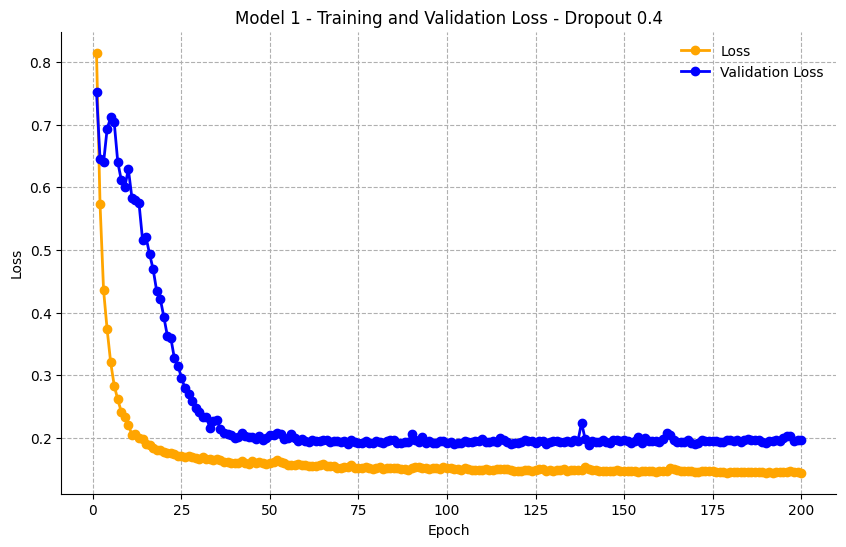

In [21]:
# Load stored data
checkpoint_path1 = "/content/checkpoint_model_1/cp-{epoch:04d}.ckpt"
checkpoint_dir1 = os.path.dirname(checkpoint_path1)
model1 = model_1()
model1.compile(loss='mean_squared_error', optimizer='adam')
latest1 = tf.train.latest_checkpoint(checkpoint_dir1)
#print(latest1)
model1.load_weights(latest1)

# Load loss history
with open('loss_history_1.pickle', 'rb') as f:
    data = pickle.load(f)
    if len(data) == 2:
        loss_history1, val_loss_history1 = data
        epochs_train1 = len(loss_history1)
    elif len(data) == 3:
        loss_history1, val_loss_history1, epochs_train1 = data
    else:
        raise ValueError("Invalid data format in the pickle file.")

# Visualize training
def get_figure():
    """
    Returns figure and axis objects to plot on.
    Removes top and right border and ticks because those are ugly.
    """
    fig, ax = plt.subplots(1, figsize=(10, 6))  # Adjust the figsize as desired
    plt.tick_params(top=False, right=False, which='both')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return fig, ax

# Plot loss history
fig, ax = get_figure()
ax.plot(np.arange(epochs_train1) + 1, loss_history1, marker="o", linewidth=2, color="orange", label="Loss")
ax.plot(np.arange(epochs_train1) + 1, val_loss_history1, marker="o", linewidth=2, color="blue", label="Validation Loss")
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(frameon=False)
ax.set_title('Model 1 - Training and Validation Loss - Dropout 0.4')
ax.grid(True, linestyle='--')
plt.show()

##### Adam optimizer 20% of validation data - Dropout of 0.6

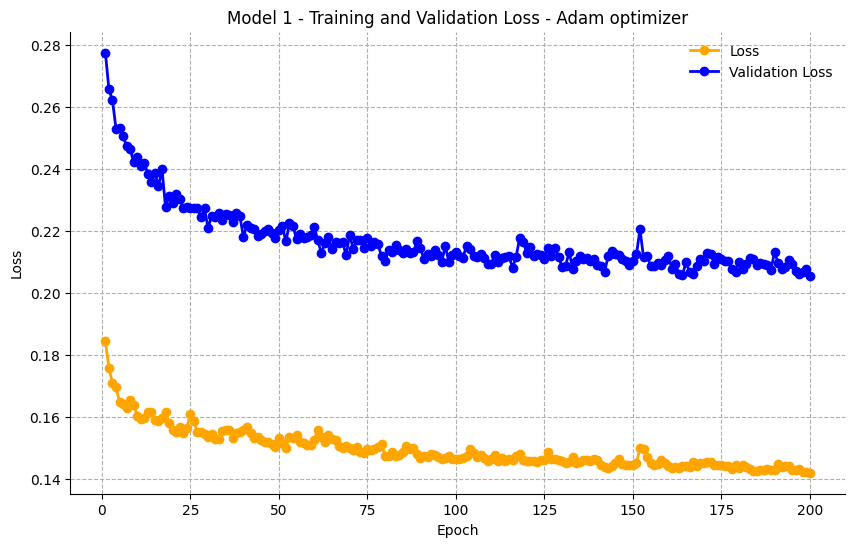

In [ ]:
# Load stored data
checkpoint_path1 = "/content/checkpoint_model_1/cp-{epoch:04d}.ckpt"
checkpoint_dir1 = os.path.dirname(checkpoint_path1)
model1 = model_1()
model1.compile(loss='mean_squared_error', optimizer='adam')
latest1 = tf.train.latest_checkpoint(checkpoint_dir1)
#print(latest1)
model1.load_weights(latest1)

# Load loss history
with open('loss_history_1.pickle', 'rb') as f:
    data = pickle.load(f)
    if len(data) == 2:
        loss_history1, val_loss_history1 = data
        epochs_train1 = len(loss_history1)
    elif len(data) == 3:
        loss_history1, val_loss_history1, epochs_train1 = data
    else:
        raise ValueError("Invalid data format in the pickle file.")

# Visualize training
def get_figure():
    """
    Returns figure and axis objects to plot on.
    Removes top and right border and ticks because those are ugly.
    """
    fig, ax = plt.subplots(1, figsize=(10, 6))  # Adjust the figsize as desired
    plt.tick_params(top=False, right=False, which='both')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return fig, ax

# Plot loss history
fig, ax = get_figure()
ax.plot(np.arange(epochs_train1) + 1, loss_history1, marker="o", linewidth=2, color="orange", label="Loss")
ax.plot(np.arange(epochs_train1) + 1, val_loss_history1, marker="o", linewidth=2, color="blue", label="Validation Loss")
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(frameon=False)
ax.set_title('Model 1 - Training and Validation Loss - Adam optimizer')
ax.grid(True, linestyle='--')
plt.show()

##### Nadam optimizer 20% in validation

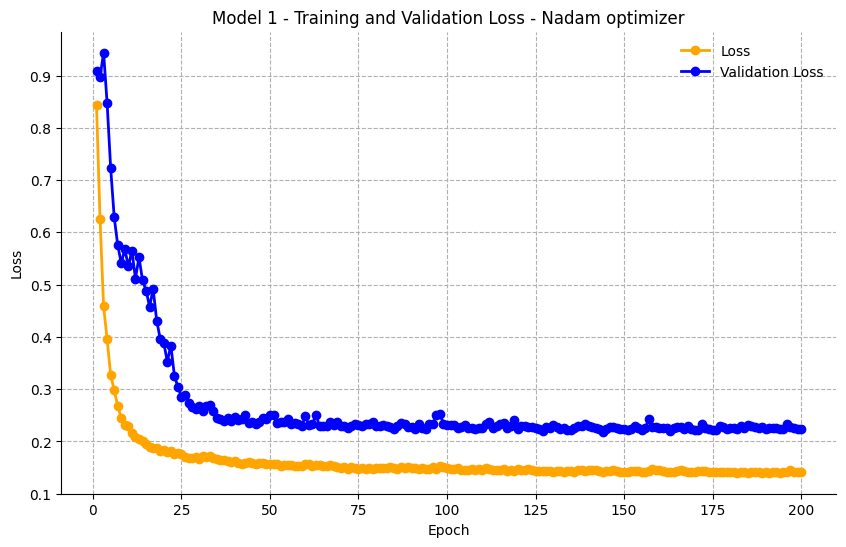

In [ ]:
# Load stored data
checkpoint_path1 = "/content/checkpoint_model_1/cp-{epoch:04d}.ckpt"
checkpoint_dir1 = os.path.dirname(checkpoint_path1)
model1 = model_1()
model1.compile(loss='mean_squared_error', optimizer='adam')
latest1 = tf.train.latest_checkpoint(checkpoint_dir1)
#print(latest1)
model1.load_weights(latest1)

# Load loss history
with open('loss_history_1.pickle', 'rb') as f:
    data = pickle.load(f)
    if len(data) == 2:
        loss_history1, val_loss_history1 = data
        epochs_train1 = len(loss_history1)
    elif len(data) == 3:
        loss_history1, val_loss_history1, epochs_train1 = data
    else:
        raise ValueError("Invalid data format in the pickle file.")

# Visualize training
def get_figure():
    """
    Returns figure and axis objects to plot on.
    Removes top and right border and ticks because those are ugly.
    """
    fig, ax = plt.subplots(1, figsize=(10, 6))  # Adjust the figsize as desired
    plt.tick_params(top=False, right=False, which='both')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return fig, ax

# Plot loss history
fig, ax = get_figure()
ax.plot(np.arange(epochs_train1) + 1, loss_history1, marker="o", linewidth=2, color="orange", label="Loss")
ax.plot(np.arange(epochs_train1) + 1, val_loss_history1, marker="o", linewidth=2, color="blue", label="Validation Loss")
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(frameon=False)
ax.set_title('Model 1 - Training and Validation Loss - Nadam optimizer')
ax.grid(True, linestyle='--')
plt.show()

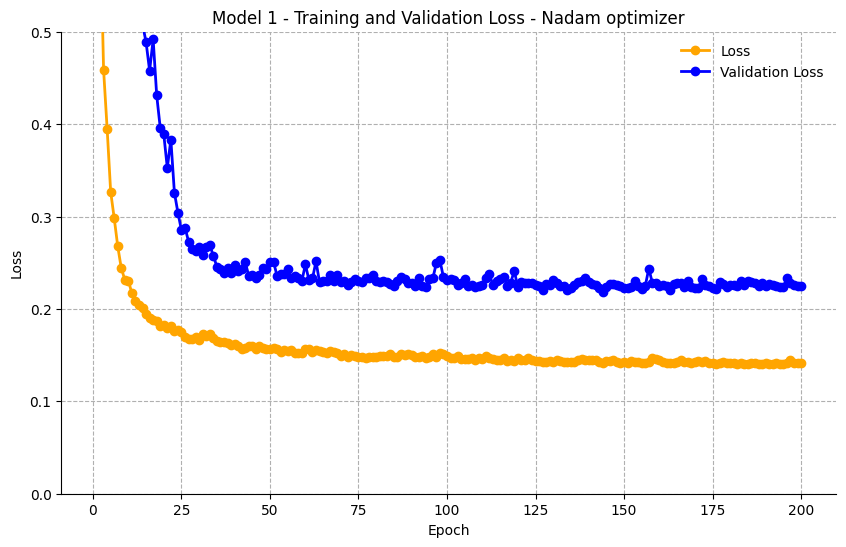

In [ ]:
# Load stored data
checkpoint_path1 = "/content/checkpoint_model_1/cp-{epoch:04d}.ckpt"
checkpoint_dir1 = os.path.dirname(checkpoint_path1)
model1 = model_1()
model1.compile(loss='mean_squared_error', optimizer='adam')
latest1 = tf.train.latest_checkpoint(checkpoint_dir1)
#print(latest1)
model1.load_weights(latest1)

# Load loss history
with open('loss_history_1.pickle', 'rb') as f:
    data = pickle.load(f)
    if len(data) == 2:
        loss_history1, val_loss_history1 = data
        epochs_train1 = len(loss_history1)
    elif len(data) == 3:
        loss_history1, val_loss_history1, epochs_train1 = data
    else:
        raise ValueError("Invalid data format in the pickle file.")

# Visualize training
def get_figure():
    """
    Returns figure and axis objects to plot on.
    Removes top and right border and ticks because those are ugly.
    """
    fig, ax = plt.subplots(1, figsize=(10, 6))  # Adjust the figsize as desired
    plt.tick_params(top=False, right=False, which='both')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return fig, ax

# Plot loss history
fig, ax = get_figure()
ax.plot(np.arange(epochs_train1) + 1, loss_history1, marker="o", linewidth=2, color="orange", label="Loss")
ax.plot(np.arange(epochs_train1) + 1, val_loss_history1, marker="o", linewidth=2, color="blue", label="Validation Loss")
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(frameon=False)
ax.set_title('Model 1 - Training and Validation Loss - Nadam optimizer')
ax.grid(True, linestyle='--')
plt.ylim((0, 0.5))
plt.show()



##### Adam optimizer with validation data of 10%

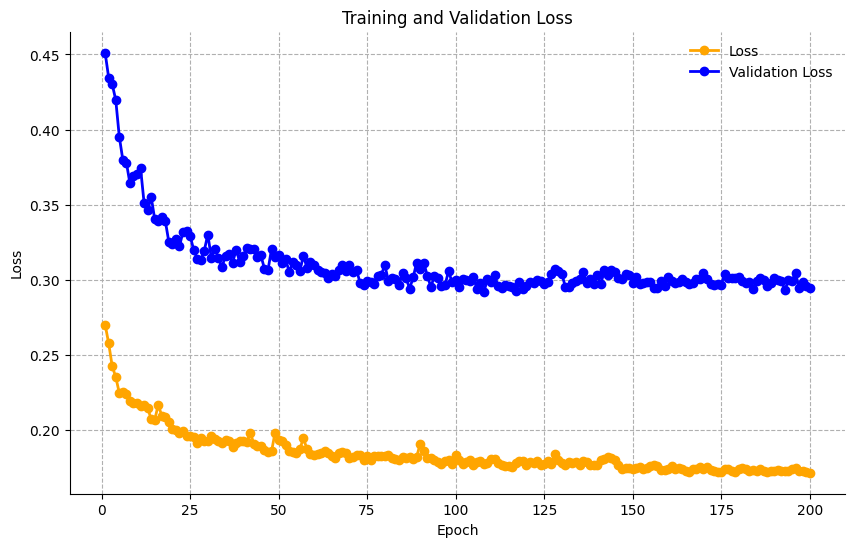

In [ ]:
# Load stored data
checkpoint_path1 = "/content/checkpoint_model_1/cp-{epoch:04d}.ckpt"
checkpoint_dir1 = os.path.dirname(checkpoint_path1)
model1 = model_1()
model1.compile(loss='mean_squared_error', optimizer='adam')
latest1 = tf.train.latest_checkpoint(checkpoint_dir1)
#print(latest1)
model1.load_weights(latest1)

# Load loss history
with open('loss_history_1.pickle', 'rb') as f:
    data = pickle.load(f)
    if len(data) == 2:
        loss_history1, val_loss_history1 = data
        epochs_train1 = len(loss_history1)
    elif len(data) == 3:
        loss_history1, val_loss_history1, epochs_train1 = data
    else:
        raise ValueError("Invalid data format in the pickle file.")

# Visualize training
def get_figure():
    """
    Returns figure and axis objects to plot on.
    Removes top and right border and ticks because those are ugly.
    """
    fig, ax = plt.subplots(1, figsize=(10, 6))  # Adjust the figsize as desired
    plt.tick_params(top=False, right=False, which='both')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return fig, ax

# Plot loss history
fig, ax = get_figure()
ax.plot(np.arange(epochs_train1) + 1, loss_history1, marker="o", linewidth=2, color="orange", label="Loss")
ax.plot(np.arange(epochs_train1) + 1, val_loss_history1, marker="o", linewidth=2, color="blue", label="Validation Loss")
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(frameon=False)
ax.set_title('Training and Validation Loss - Model 1 ')
ax.grid(True, linestyle='--')
plt.show()

/content/checkpoint_model_1/cp-0001.ckpt


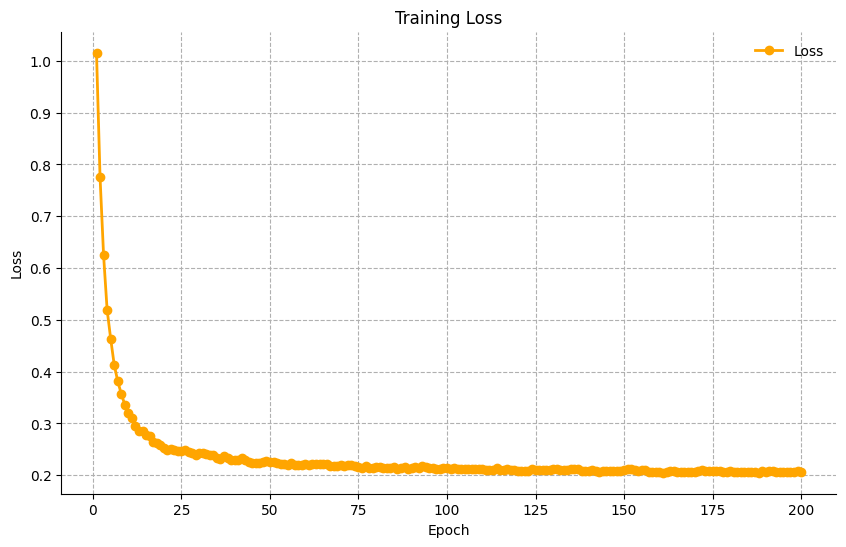

In [ ]:
# Load stored data
checkpoint_path1 = "/content/checkpoint_model_1/cp-{epoch:04d}.ckpt"
checkpoint_dir1 = os.path.dirname(checkpoint_path1)
model1 = model_1()
model1.compile(loss='mean_squared_error', optimizer='adam')
latest1 = tf.train.latest_checkpoint(checkpoint_dir1)
print(latest1)
model1.load_weights(latest1)

# Load loss history
with open('loss_history_1.pickle', 'rb') as f:
    [loss_history1, epochs_train1] = pickle.load(f)

# Visualize training
def get_figure():
    """
    Returns figure and axis objects to plot on. 
    Removes top and right border and ticks because those are ugly.
    """
    fig, ax = plt.subplots(1, figsize=(10, 6))  # Adjust the figsize as desired
    plt.tick_params(top=False, right=False, which='both') 
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return fig, ax
  
fig, ax = get_figure()

# Plot loss history
ax.plot(np.arange(epochs_train1) + 1, loss_history1, marker="o", linewidth=2, color="orange", label="Loss")
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(frameon=False)

# Add title and gridlines
ax.set_title('Training Loss')
ax.grid(True, linestyle='--')

# Show the plot
plt.show()

###### ***Model 2 - Architecture***

In [35]:
def model_2(filter_base=64, kernel_size=3):
    # Define the downsample blocks
    down_stack = [
        downsample(filter_base, kernel_size, apply_batch_norm=False),  # (base, 32, 32, 32, 64)
        downsample(filter_base * 2, kernel_size),                      # (base, 16, 16, 16, 128)
        downsample(filter_base * 3, kernel_size),                      # (base, 8, 8, 8, 256)
        downsample(filter_base * 4, kernel_size),                      # (base, 4, 4, 4, 512)
        downsample(filter_base * 5, kernel_size),                      # (base, 2, 2, 2, 1024)
    ]

    # Define the upsample blocks
    up_stack = [
        upsample(filter_base * 5, kernel_size, apply_dropout=True,dropout=0.6),     # (base, 4, 4, 4, 1024)
        upsample(filter_base * 4, kernel_size, apply_dropout=True,dropout=0.4),     # (base, 8, 8, 8, 512)
        upsample(filter_base * 3, kernel_size, apply_dropout=True,dropout=0.3),     # (base, 16, 16, 16, 256)
        upsample(filter_base * 2, kernel_size, apply_dropout=True,dropout=0.4),     # (base, 32, 32, 32, 128)
    ]

    # Define the final layer
    initializer = tf.random_normal_initializer(0., 0.02)
    final_layer = tf.keras.layers.Conv3DTranspose(OUTPUT_CHANNELS,
                                                  kernel_size,
                                                  strides=2,
                                                  padding='same',
                                                  kernel_initializer=initializer,
                                                  activation='tanh')  # (base, 256, 256, 3)

    concatenate = tf.keras.layers.Concatenate()
    inputs = tf.keras.layers.Input(shape=[None, None, None, 1])
    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])  # Reverse the skips for correct order in upsampling

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concatenate([x, skip])

    x = final_layer(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [36]:
unet_model2 = model_2()

# Define the learning rate schedule
initial_learning_rate = 0.003
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,  # Adjust this value based on your dataset and training requirements
    decay_rate=0.96  # Adjust this value based on your dataset and training requirements
)

# Create the optimizer with the learning rate schedule
#optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
optimizer = Nadam(learning_rate=lr_schedule)

# Compile the model with the optimizer
unet_model2.compile(loss=losses.mean_squared_error, optimizer=optimizer)
unet_model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 None, 1)]                                                        
                                                                                                  
 sequential_9 (Sequential)      (None, None, None,   1728        ['input_2[0][0]']                
                                None, 64)                                                         
                                                                                                  
 sequential_10 (Sequential)     (None, None, None,   221696      ['sequential_9[0][0]']           
                                None, 128)                                                  

###### ***Model 2 - Trainning the model***

In [37]:
# Directories to store the checkpoints created
checkpoint_path_2 = "checkpoint_model_2/cp-{epoch:04d}.ckpt"
checkpoint_dir2 = os.path.dirname(checkpoint_path_2)

# Callback to save checkpoints
cp_callback = ModelCheckpoint(
    checkpoint_path_2,
    save_weights_only=True,
    save_freq='epoch',
    verbose=1
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    verbose=1
)

# Train the model with validation data
loss_history_2 = []
val_loss_history_2 = []  # Store validation loss
with tqdm(total=EPOCHS, desc="Training") as pbar:
    for epoch in range(EPOCHS):
        pbar.set_postfix({'Epoch': epoch+1})
        history_2 = unet_model2.fit(
            train_images,
            train_labels,
            epochs=1,
            batch_size=30,
            shuffle=True,
            validation_data=(val_images, val_labels),
            callbacks=[cp_callback, early_stopping_callback]
        )
        
        loss_history_2.append(history_2.history["loss"][0])
        val_loss_history_2.append(history_2.history["val_loss"][0])  # Store validation loss
        
        # Clear memory after each epoch
        del history_2
        tf.keras.backend.clear_session()
        
        pbar.update(1)

# Save loss history
with open('loss_history_2.pickle', 'wb') as f:
    pickle.dump([loss_history_2, val_loss_history_2, len(loss_history_2)], f)

# After training your model
unet_model1.save("qsm_unet_m2.h5")

Training:   0%|          | 0/500 [00:00<?, ?it/s, Epoch=1]

13/14 [==========================>...] - ETA: 0s - loss: 0.8125
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 9s 171ms/step - loss: 0.8092 - val_loss: 1.0765


Training:   0%|          | 1/500 [00:08<1:14:17,  8.93s/it, Epoch=2]

13/14 [==========================>...] - ETA: 0s - loss: 0.5786
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 156ms/step - loss: 0.5771 - val_loss: 1.0256


Training:   0%|          | 2/500 [00:11<45:08,  5.44s/it, Epoch=3]

13/14 [==========================>...] - ETA: 0s - loss: 0.4525
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 172ms/step - loss: 0.4476 - val_loss: 0.8261


Training:   1%|          | 3/500 [00:15<36:17,  4.38s/it, Epoch=4]

13/14 [==========================>...] - ETA: 0s - loss: 0.3627
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.3592 - val_loss: 0.6814


Training:   1%|          | 4/500 [00:17<31:21,  3.79s/it, Epoch=5]

13/14 [==========================>...] - ETA: 0s - loss: 0.3150
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 153ms/step - loss: 0.3139 - val_loss: 0.6685


Training:   1%|          | 5/500 [00:20<28:31,  3.46s/it, Epoch=6]

13/14 [==========================>...] - ETA: 0s - loss: 0.2764
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.2759 - val_loss: 0.5553


Training:   1%|          | 6/500 [00:23<26:54,  3.27s/it, Epoch=7]

13/14 [==========================>...] - ETA: 0s - loss: 0.2505
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.2513 - val_loss: 0.4572


Training:   1%|▏         | 7/500 [00:26<25:46,  3.14s/it, Epoch=8]

13/14 [==========================>...] - ETA: 0s - loss: 0.2312
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.2296 - val_loss: 0.4447


Training:   2%|▏         | 8/500 [00:29<25:02,  3.05s/it, Epoch=9]

13/14 [==========================>...] - ETA: 0s - loss: 0.2170
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 153ms/step - loss: 0.2165 - val_loss: 0.4056


Training:   2%|▏         | 9/500 [00:32<24:30,  2.99s/it, Epoch=10]

13/14 [==========================>...] - ETA: 0s - loss: 0.2055
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.2055 - val_loss: 0.4043


Training:   2%|▏         | 10/500 [00:35<24:10,  2.96s/it, Epoch=11]

13/14 [==========================>...] - ETA: 0s - loss: 0.2054
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 185ms/step - loss: 0.2049 - val_loss: 0.3672


Training:   2%|▏         | 11/500 [00:38<24:55,  3.06s/it, Epoch=12]

13/14 [==========================>...] - ETA: 0s - loss: 0.1965
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 156ms/step - loss: 0.1964 - val_loss: 0.3518


Training:   2%|▏         | 12/500 [00:41<24:33,  3.02s/it, Epoch=13]

13/14 [==========================>...] - ETA: 0s - loss: 0.1902
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 156ms/step - loss: 0.1908 - val_loss: 0.3612


Training:   3%|▎         | 13/500 [00:44<24:14,  2.99s/it, Epoch=14]

13/14 [==========================>...] - ETA: 0s - loss: 0.1924
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1911 - val_loss: 0.3461


Training:   3%|▎         | 14/500 [00:47<23:59,  2.96s/it, Epoch=15]

13/14 [==========================>...] - ETA: 0s - loss: 0.1835
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 167ms/step - loss: 0.1856 - val_loss: 0.3187


Training:   3%|▎         | 15/500 [00:50<24:09,  2.99s/it, Epoch=16]

13/14 [==========================>...] - ETA: 0s - loss: 0.1762
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1781 - val_loss: 0.3190


Training:   3%|▎         | 16/500 [00:53<23:55,  2.97s/it, Epoch=17]

13/14 [==========================>...] - ETA: 0s - loss: 0.1747
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 156ms/step - loss: 0.1747 - val_loss: 0.3022


Training:   3%|▎         | 17/500 [00:56<23:44,  2.95s/it, Epoch=18]

13/14 [==========================>...] - ETA: 0s - loss: 0.1759
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 156ms/step - loss: 0.1770 - val_loss: 0.2972


Training:   4%|▎         | 18/500 [00:59<23:35,  2.94s/it, Epoch=19]

13/14 [==========================>...] - ETA: 0s - loss: 0.1730
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 153ms/step - loss: 0.1737 - val_loss: 0.2852


Training:   4%|▍         | 19/500 [01:01<23:23,  2.92s/it, Epoch=20]

13/14 [==========================>...] - ETA: 0s - loss: 0.1822
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1813 - val_loss: 0.2642


Training:   4%|▍         | 20/500 [01:04<23:13,  2.90s/it, Epoch=21]

13/14 [==========================>...] - ETA: 0s - loss: 0.1734
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 190ms/step - loss: 0.1724 - val_loss: 0.2483


Training:   4%|▍         | 21/500 [01:08<24:12,  3.03s/it, Epoch=22]

13/14 [==========================>...] - ETA: 0s - loss: 0.1671
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 156ms/step - loss: 0.1669 - val_loss: 0.2417


Training:   4%|▍         | 22/500 [01:11<23:54,  3.00s/it, Epoch=23]

13/14 [==========================>...] - ETA: 0s - loss: 0.1715
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1714 - val_loss: 0.2398


Training:   5%|▍         | 23/500 [01:13<23:34,  2.96s/it, Epoch=24]

13/14 [==========================>...] - ETA: 0s - loss: 0.1654
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1668 - val_loss: 0.2238


Training:   5%|▍         | 24/500 [01:16<23:21,  2.95s/it, Epoch=25]

13/14 [==========================>...] - ETA: 0s - loss: 0.1654
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 157ms/step - loss: 0.1659 - val_loss: 0.2252


Training:   5%|▌         | 25/500 [01:19<23:17,  2.94s/it, Epoch=26]

13/14 [==========================>...] - ETA: 0s - loss: 0.1630
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1639 - val_loss: 0.2187


Training:   5%|▌         | 26/500 [01:22<23:08,  2.93s/it, Epoch=27]

13/14 [==========================>...] - ETA: 0s - loss: 0.1583
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1614 - val_loss: 0.2215


Training:   5%|▌         | 27/500 [01:25<22:58,  2.91s/it, Epoch=28]

13/14 [==========================>...] - ETA: 0s - loss: 0.1646
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1635 - val_loss: 0.2093


Training:   6%|▌         | 28/500 [01:28<22:49,  2.90s/it, Epoch=29]

13/14 [==========================>...] - ETA: 0s - loss: 0.1648
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 175ms/step - loss: 0.1638 - val_loss: 0.2086


Training:   6%|▌         | 29/500 [01:31<23:20,  2.97s/it, Epoch=30]

13/14 [==========================>...] - ETA: 0s - loss: 0.1654
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1642 - val_loss: 0.2134


Training:   6%|▌         | 30/500 [01:34<23:05,  2.95s/it, Epoch=31]

13/14 [==========================>...] - ETA: 0s - loss: 0.1661
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 157ms/step - loss: 0.1640 - val_loss: 0.2022


Training:   6%|▌         | 31/500 [01:37<22:56,  2.93s/it, Epoch=32]

13/14 [==========================>...] - ETA: 0s - loss: 0.1609
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1608 - val_loss: 0.1993


Training:   6%|▋         | 32/500 [01:40<22:43,  2.91s/it, Epoch=33]

13/14 [==========================>...] - ETA: 0s - loss: 0.1626
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1638 - val_loss: 0.2104


Training:   7%|▋         | 33/500 [01:43<22:34,  2.90s/it, Epoch=34]

13/14 [==========================>...] - ETA: 0s - loss: 0.1599
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1602 - val_loss: 0.2025


Training:   7%|▋         | 34/500 [01:45<22:28,  2.89s/it, Epoch=35]

13/14 [==========================>...] - ETA: 0s - loss: 0.1658
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 177ms/step - loss: 0.1648 - val_loss: 0.2014


Training:   7%|▋         | 35/500 [01:49<23:04,  2.98s/it, Epoch=36]

13/14 [==========================>...] - ETA: 0s - loss: 0.1584
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1598 - val_loss: 0.1936


Training:   7%|▋         | 36/500 [01:51<22:50,  2.95s/it, Epoch=37]

13/14 [==========================>...] - ETA: 0s - loss: 0.1620
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1629 - val_loss: 0.1954


Training:   7%|▋         | 37/500 [01:54<22:38,  2.93s/it, Epoch=38]

13/14 [==========================>...] - ETA: 0s - loss: 0.1627
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1612 - val_loss: 0.1961


Training:   8%|▊         | 38/500 [01:57<22:30,  2.92s/it, Epoch=39]

13/14 [==========================>...] - ETA: 0s - loss: 0.1536
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 188ms/step - loss: 0.1570 - val_loss: 0.1918


Training:   8%|▊         | 39/500 [02:01<23:21,  3.04s/it, Epoch=40]

13/14 [==========================>...] - ETA: 0s - loss: 0.1569
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 156ms/step - loss: 0.1561 - val_loss: 0.1938


Training:   8%|▊         | 40/500 [02:04<23:03,  3.01s/it, Epoch=41]

13/14 [==========================>...] - ETA: 0s - loss: 0.1563
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1560 - val_loss: 0.1930


Training:   8%|▊         | 41/500 [02:06<22:48,  2.98s/it, Epoch=42]

13/14 [==========================>...] - ETA: 0s - loss: 0.1559
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 168ms/step - loss: 0.1564 - val_loss: 0.1893


Training:   8%|▊         | 42/500 [02:10<22:56,  3.01s/it, Epoch=43]

13/14 [==========================>...] - ETA: 0s - loss: 0.1558
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 163ms/step - loss: 0.1579 - val_loss: 0.1911


Training:   9%|▊         | 43/500 [02:12<22:49,  3.00s/it, Epoch=44]

13/14 [==========================>...] - ETA: 0s - loss: 0.1563
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 156ms/step - loss: 0.1552 - val_loss: 0.1930


Training:   9%|▉         | 44/500 [02:15<22:33,  2.97s/it, Epoch=45]

13/14 [==========================>...] - ETA: 0s - loss: 0.1575
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 175ms/step - loss: 0.1575 - val_loss: 0.1973


Training:   9%|▉         | 45/500 [02:19<22:54,  3.02s/it, Epoch=46]

13/14 [==========================>...] - ETA: 0s - loss: 0.1553
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1567 - val_loss: 0.1925


Training:   9%|▉         | 46/500 [02:21<22:32,  2.98s/it, Epoch=47]

13/14 [==========================>...] - ETA: 0s - loss: 0.1524
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1552 - val_loss: 0.1909


Training:   9%|▉         | 47/500 [02:24<22:16,  2.95s/it, Epoch=48]

13/14 [==========================>...] - ETA: 0s - loss: 0.1565
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 156ms/step - loss: 0.1568 - val_loss: 0.1913


Training:  10%|▉         | 48/500 [02:27<22:04,  2.93s/it, Epoch=49]

13/14 [==========================>...] - ETA: 0s - loss: 0.1539
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 208ms/step - loss: 0.1539 - val_loss: 0.1904


Training:  10%|▉         | 49/500 [02:31<23:27,  3.12s/it, Epoch=50]

13/14 [==========================>...] - ETA: 0s - loss: 0.1542
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1543 - val_loss: 0.1930


Training:  10%|█         | 50/500 [02:34<22:53,  3.05s/it, Epoch=51]

13/14 [==========================>...] - ETA: 0s - loss: 0.1563
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1556 - val_loss: 0.1888


Training:  10%|█         | 51/500 [02:37<22:25,  3.00s/it, Epoch=52]

13/14 [==========================>...] - ETA: 0s - loss: 0.1594
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 167ms/step - loss: 0.1590 - val_loss: 0.1929


Training:  10%|█         | 52/500 [02:40<22:28,  3.01s/it, Epoch=53]

13/14 [==========================>...] - ETA: 0s - loss: 0.1554
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 171ms/step - loss: 0.1550 - val_loss: 0.1918


Training:  11%|█         | 53/500 [02:43<22:36,  3.04s/it, Epoch=54]

13/14 [==========================>...] - ETA: 0s - loss: 0.1525
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1536 - val_loss: 0.1844


Training:  11%|█         | 54/500 [02:46<22:12,  2.99s/it, Epoch=55]

13/14 [==========================>...] - ETA: 0s - loss: 0.1518
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 162ms/step - loss: 0.1522 - val_loss: 0.1886


Training:  11%|█         | 55/500 [02:49<22:09,  2.99s/it, Epoch=56]

13/14 [==========================>...] - ETA: 0s - loss: 0.1505
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1536 - val_loss: 0.1892


Training:  11%|█         | 56/500 [02:51<21:54,  2.96s/it, Epoch=57]

13/14 [==========================>...] - ETA: 0s - loss: 0.1514
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 167ms/step - loss: 0.1518 - val_loss: 0.1874


Training:  11%|█▏        | 57/500 [02:54<22:04,  2.99s/it, Epoch=58]

13/14 [==========================>...] - ETA: 0s - loss: 0.1516
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1521 - val_loss: 0.1914


Training:  12%|█▏        | 58/500 [02:57<21:46,  2.96s/it, Epoch=59]

13/14 [==========================>...] - ETA: 0s - loss: 0.1528
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 193ms/step - loss: 0.1537 - val_loss: 0.2021


Training:  12%|█▏        | 59/500 [03:01<22:38,  3.08s/it, Epoch=60]

13/14 [==========================>...] - ETA: 0s - loss: 0.1568
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1558 - val_loss: 0.1908


Training:  12%|█▏        | 60/500 [03:04<22:10,  3.02s/it, Epoch=61]

13/14 [==========================>...] - ETA: 0s - loss: 0.1540
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 191ms/step - loss: 0.1554 - val_loss: 0.1954


Training:  12%|█▏        | 61/500 [03:07<22:52,  3.13s/it, Epoch=62]

13/14 [==========================>...] - ETA: 0s - loss: 0.1523
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 156ms/step - loss: 0.1535 - val_loss: 0.1892


Training:  12%|█▏        | 62/500 [03:10<22:19,  3.06s/it, Epoch=63]

13/14 [==========================>...] - ETA: 0s - loss: 0.1523
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1522 - val_loss: 0.1872


Training:  13%|█▎        | 63/500 [03:13<21:52,  3.00s/it, Epoch=64]

13/14 [==========================>...] - ETA: 0s - loss: 0.1529
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1522 - val_loss: 0.1885


Training:  13%|█▎        | 64/500 [03:16<21:31,  2.96s/it, Epoch=65]

13/14 [==========================>...] - ETA: 0s - loss: 0.1517
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 199ms/step - loss: 0.1512 - val_loss: 0.1882


Training:  13%|█▎        | 65/500 [03:19<22:32,  3.11s/it, Epoch=66]

13/14 [==========================>...] - ETA: 0s - loss: 0.1493
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 156ms/step - loss: 0.1517 - val_loss: 0.1897


Training:  13%|█▎        | 66/500 [03:22<22:06,  3.06s/it, Epoch=67]

13/14 [==========================>...] - ETA: 0s - loss: 0.1491
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 177ms/step - loss: 0.1514 - val_loss: 0.1872


Training:  13%|█▎        | 67/500 [03:25<22:16,  3.09s/it, Epoch=68]

13/14 [==========================>...] - ETA: 0s - loss: 0.1508
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1505 - val_loss: 0.1893


Training:  14%|█▎        | 68/500 [03:28<21:43,  3.02s/it, Epoch=69]

13/14 [==========================>...] - ETA: 0s - loss: 0.1489
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1494 - val_loss: 0.1852


Training:  14%|█▍        | 69/500 [03:31<21:19,  2.97s/it, Epoch=70]

13/14 [==========================>...] - ETA: 0s - loss: 0.1478
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1478 - val_loss: 0.1893


Training:  14%|█▍        | 70/500 [03:34<21:04,  2.94s/it, Epoch=71]

13/14 [==========================>...] - ETA: 0s - loss: 0.1492
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1487 - val_loss: 0.1856


Training:  14%|█▍        | 71/500 [03:37<20:55,  2.93s/it, Epoch=72]

13/14 [==========================>...] - ETA: 0s - loss: 0.1495
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 156ms/step - loss: 0.1505 - val_loss: 0.1871


Training:  14%|█▍        | 72/500 [03:40<20:48,  2.92s/it, Epoch=73]

13/14 [==========================>...] - ETA: 0s - loss: 0.1508
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1496 - val_loss: 0.1844


Training:  15%|█▍        | 73/500 [03:42<20:40,  2.91s/it, Epoch=74]

13/14 [==========================>...] - ETA: 0s - loss: 0.1476
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 193ms/step - loss: 0.1498 - val_loss: 0.1884


Training:  15%|█▍        | 74/500 [03:46<21:36,  3.04s/it, Epoch=75]

13/14 [==========================>...] - ETA: 0s - loss: 0.1507
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 4s 168ms/step - loss: 0.1512 - val_loss: 0.1897


Training:  15%|█▌        | 75/500 [03:50<23:42,  3.35s/it, Epoch=76]

13/14 [==========================>...] - ETA: 0s - loss: 0.1494
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 4s 167ms/step - loss: 0.1506 - val_loss: 0.1885


Training:  15%|█▌        | 76/500 [03:54<25:07,  3.55s/it, Epoch=77]

13/14 [==========================>...] - ETA: 0s - loss: 0.1506
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 4s 163ms/step - loss: 0.1500 - val_loss: 0.1864


Training:  15%|█▌        | 77/500 [03:58<25:41,  3.64s/it, Epoch=78]

13/14 [==========================>...] - ETA: 0s - loss: 0.1495
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 160ms/step - loss: 0.1483 - val_loss: 0.1861


Training:  16%|█▌        | 78/500 [04:01<25:28,  3.62s/it, Epoch=79]

13/14 [==========================>...] - ETA: 0s - loss: 0.1494
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 160ms/step - loss: 0.1498 - val_loss: 0.1860


Training:  16%|█▌        | 79/500 [04:05<25:08,  3.58s/it, Epoch=80]

13/14 [==========================>...] - ETA: 0s - loss: 0.1465
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 159ms/step - loss: 0.1491 - val_loss: 0.1869


Training:  16%|█▌        | 80/500 [04:08<24:31,  3.50s/it, Epoch=81]

13/14 [==========================>...] - ETA: 0s - loss: 0.1476
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 159ms/step - loss: 0.1486 - val_loss: 0.1894


Training:  16%|█▌        | 81/500 [04:11<24:03,  3.44s/it, Epoch=82]

13/14 [==========================>...] - ETA: 0s - loss: 0.1480
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 157ms/step - loss: 0.1477 - val_loss: 0.1920


Training:  16%|█▋        | 82/500 [04:15<23:19,  3.35s/it, Epoch=83]

13/14 [==========================>...] - ETA: 0s - loss: 0.1498
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1488 - val_loss: 0.1876


Training:  17%|█▋        | 83/500 [04:18<22:34,  3.25s/it, Epoch=84]

13/14 [==========================>...] - ETA: 0s - loss: 0.1506
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1502 - val_loss: 0.1878


Training:  17%|█▋        | 84/500 [04:21<21:57,  3.17s/it, Epoch=85]

13/14 [==========================>...] - ETA: 0s - loss: 0.1441
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 173ms/step - loss: 0.1470 - val_loss: 0.1878


Training:  17%|█▋        | 85/500 [04:24<21:52,  3.16s/it, Epoch=86]

13/14 [==========================>...] - ETA: 0s - loss: 0.1506
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1514 - val_loss: 0.1882


Training:  17%|█▋        | 86/500 [04:27<21:16,  3.08s/it, Epoch=87]

13/14 [==========================>...] - ETA: 0s - loss: 0.1490
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 153ms/step - loss: 0.1484 - val_loss: 0.1871


Training:  17%|█▋        | 87/500 [04:29<20:45,  3.02s/it, Epoch=88]

13/14 [==========================>...] - ETA: 0s - loss: 0.1490
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1487 - val_loss: 0.1886


Training:  18%|█▊        | 88/500 [04:32<20:27,  2.98s/it, Epoch=89]

13/14 [==========================>...] - ETA: 0s - loss: 0.1472
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 163ms/step - loss: 0.1507 - val_loss: 0.1918


Training:  18%|█▊        | 89/500 [04:35<20:28,  2.99s/it, Epoch=90]

13/14 [==========================>...] - ETA: 0s - loss: 0.1482
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1488 - val_loss: 0.1911


Training:  18%|█▊        | 90/500 [04:38<20:13,  2.96s/it, Epoch=91]

13/14 [==========================>...] - ETA: 0s - loss: 0.1512
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 153ms/step - loss: 0.1517 - val_loss: 0.1879


Training:  18%|█▊        | 91/500 [04:41<19:58,  2.93s/it, Epoch=92]

13/14 [==========================>...] - ETA: 0s - loss: 0.1475
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1482 - val_loss: 0.1875


Training:  18%|█▊        | 92/500 [04:44<19:49,  2.92s/it, Epoch=93]

13/14 [==========================>...] - ETA: 0s - loss: 0.1484
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 186ms/step - loss: 0.1482 - val_loss: 0.1846


Training:  19%|█▊        | 93/500 [04:47<20:33,  3.03s/it, Epoch=94]

13/14 [==========================>...] - ETA: 0s - loss: 0.1491
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 156ms/step - loss: 0.1495 - val_loss: 0.1906


Training:  19%|█▉        | 94/500 [04:50<20:20,  3.01s/it, Epoch=95]

13/14 [==========================>...] - ETA: 0s - loss: 0.1510
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1494 - val_loss: 0.1872


Training:  19%|█▉        | 95/500 [04:53<20:03,  2.97s/it, Epoch=96]

13/14 [==========================>...] - ETA: 0s - loss: 0.1483
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 156ms/step - loss: 0.1495 - val_loss: 0.1882


Training:  19%|█▉        | 96/500 [04:56<19:51,  2.95s/it, Epoch=97]

13/14 [==========================>...] - ETA: 0s - loss: 0.1501
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 187ms/step - loss: 0.1493 - val_loss: 0.1861


Training:  19%|█▉        | 97/500 [04:59<20:30,  3.05s/it, Epoch=98]

13/14 [==========================>...] - ETA: 0s - loss: 0.1449
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1477 - val_loss: 0.1839


Training:  20%|█▉        | 98/500 [05:02<20:06,  3.00s/it, Epoch=99]

13/14 [==========================>...] - ETA: 0s - loss: 0.1534
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1521 - val_loss: 0.1907


Training:  20%|█▉        | 99/500 [05:05<19:49,  2.97s/it, Epoch=100]

13/14 [==========================>...] - ETA: 0s - loss: 0.1480
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1480 - val_loss: 0.1854


Training:  20%|██        | 100/500 [05:08<19:35,  2.94s/it, Epoch=101]

13/14 [==========================>...] - ETA: 0s - loss: 0.1479
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 153ms/step - loss: 0.1487 - val_loss: 0.1906


Training:  20%|██        | 101/500 [05:11<19:26,  2.92s/it, Epoch=102]

13/14 [==========================>...] - ETA: 0s - loss: 0.1502
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1497 - val_loss: 0.1900


Training:  20%|██        | 102/500 [05:14<19:17,  2.91s/it, Epoch=103]

13/14 [==========================>...] - ETA: 0s - loss: 0.1482
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1481 - val_loss: 0.1871


Training:  21%|██        | 103/500 [05:17<19:10,  2.90s/it, Epoch=104]

13/14 [==========================>...] - ETA: 0s - loss: 0.1471
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1471 - val_loss: 0.1881


Training:  21%|██        | 104/500 [05:19<19:05,  2.89s/it, Epoch=105]

13/14 [==========================>...] - ETA: 0s - loss: 0.1483
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 178ms/step - loss: 0.1475 - val_loss: 0.1873


Training:  21%|██        | 105/500 [05:23<19:37,  2.98s/it, Epoch=106]

13/14 [==========================>...] - ETA: 0s - loss: 0.1473
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1460 - val_loss: 0.1833


Training:  21%|██        | 106/500 [05:26<19:24,  2.96s/it, Epoch=107]

13/14 [==========================>...] - ETA: 0s - loss: 0.1441
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1447 - val_loss: 0.1855


Training:  21%|██▏       | 107/500 [05:28<19:11,  2.93s/it, Epoch=108]

13/14 [==========================>...] - ETA: 0s - loss: 0.1434
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 153ms/step - loss: 0.1451 - val_loss: 0.1903


Training:  22%|██▏       | 108/500 [05:31<19:01,  2.91s/it, Epoch=109]

13/14 [==========================>...] - ETA: 0s - loss: 0.1477
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 172ms/step - loss: 0.1478 - val_loss: 0.1887


Training:  22%|██▏       | 109/500 [05:34<19:21,  2.97s/it, Epoch=110]

13/14 [==========================>...] - ETA: 0s - loss: 0.1412
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1454 - val_loss: 0.1886


Training:  22%|██▏       | 110/500 [05:37<19:05,  2.94s/it, Epoch=111]

13/14 [==========================>...] - ETA: 0s - loss: 0.1464
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 153ms/step - loss: 0.1477 - val_loss: 0.1938


Training:  22%|██▏       | 111/500 [05:40<18:53,  2.91s/it, Epoch=112]

13/14 [==========================>...] - ETA: 0s - loss: 0.1518
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1515 - val_loss: 0.1885


Training:  22%|██▏       | 112/500 [05:43<18:48,  2.91s/it, Epoch=113]

13/14 [==========================>...] - ETA: 0s - loss: 0.1474
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 187ms/step - loss: 0.1475 - val_loss: 0.1887


Training:  23%|██▎       | 113/500 [05:46<19:31,  3.03s/it, Epoch=114]

13/14 [==========================>...] - ETA: 0s - loss: 0.1450
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 156ms/step - loss: 0.1454 - val_loss: 0.1865


Training:  23%|██▎       | 114/500 [05:49<19:14,  2.99s/it, Epoch=115]

13/14 [==========================>...] - ETA: 0s - loss: 0.1463
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1456 - val_loss: 0.1842


Training:  23%|██▎       | 115/500 [05:52<18:56,  2.95s/it, Epoch=116]

13/14 [==========================>...] - ETA: 0s - loss: 0.1453
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1461 - val_loss: 0.1890


Training:  23%|██▎       | 116/500 [05:55<18:43,  2.93s/it, Epoch=117]

13/14 [==========================>...] - ETA: 0s - loss: 0.1465
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 183ms/step - loss: 0.1458 - val_loss: 0.1846


Training:  23%|██▎       | 117/500 [05:58<19:18,  3.03s/it, Epoch=118]

13/14 [==========================>...] - ETA: 0s - loss: 0.1474
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 157ms/step - loss: 0.1458 - val_loss: 0.1896


Training:  24%|██▎       | 118/500 [06:01<19:05,  3.00s/it, Epoch=119]

13/14 [==========================>...] - ETA: 0s - loss: 0.1488
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 157ms/step - loss: 0.1482 - val_loss: 0.1882


Training:  24%|██▍       | 119/500 [06:04<18:57,  2.98s/it, Epoch=120]

13/14 [==========================>...] - ETA: 0s - loss: 0.1465
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 156ms/step - loss: 0.1469 - val_loss: 0.1892


Training:  24%|██▍       | 120/500 [06:07<18:45,  2.96s/it, Epoch=121]

13/14 [==========================>...] - ETA: 0s - loss: 0.1461
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 153ms/step - loss: 0.1458 - val_loss: 0.1858


Training:  24%|██▍       | 121/500 [06:10<18:35,  2.94s/it, Epoch=122]

13/14 [==========================>...] - ETA: 0s - loss: 0.1465
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1462 - val_loss: 0.1848


Training:  24%|██▍       | 122/500 [06:13<18:27,  2.93s/it, Epoch=123]

13/14 [==========================>...] - ETA: 0s - loss: 0.1466
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1455 - val_loss: 0.1832


Training:  25%|██▍       | 123/500 [06:16<18:21,  2.92s/it, Epoch=124]

13/14 [==========================>...] - ETA: 0s - loss: 0.1457
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1448 - val_loss: 0.1882


Training:  25%|██▍       | 124/500 [06:19<18:17,  2.92s/it, Epoch=125]

13/14 [==========================>...] - ETA: 0s - loss: 0.1456
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1443 - val_loss: 0.1848


Training:  25%|██▌       | 125/500 [06:21<18:10,  2.91s/it, Epoch=126]

13/14 [==========================>...] - ETA: 0s - loss: 0.1457
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1447 - val_loss: 0.1901


Training:  25%|██▌       | 126/500 [06:24<18:04,  2.90s/it, Epoch=127]

13/14 [==========================>...] - ETA: 0s - loss: 0.1453
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1447 - val_loss: 0.1905


Training:  25%|██▌       | 127/500 [06:27<17:57,  2.89s/it, Epoch=128]

13/14 [==========================>...] - ETA: 0s - loss: 0.1463
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 181ms/step - loss: 0.1453 - val_loss: 0.1887


Training:  26%|██▌       | 128/500 [06:30<18:30,  2.99s/it, Epoch=129]

13/14 [==========================>...] - ETA: 0s - loss: 0.1446
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 174ms/step - loss: 0.1442 - val_loss: 0.1891


Training:  26%|██▌       | 129/500 [06:34<18:42,  3.03s/it, Epoch=130]

13/14 [==========================>...] - ETA: 0s - loss: 0.1447
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 156ms/step - loss: 0.1450 - val_loss: 0.1883


Training:  26%|██▌       | 130/500 [06:36<18:23,  2.98s/it, Epoch=131]

13/14 [==========================>...] - ETA: 0s - loss: 0.1434
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1450 - val_loss: 0.1937


Training:  26%|██▌       | 131/500 [06:39<18:09,  2.95s/it, Epoch=132]

13/14 [==========================>...] - ETA: 0s - loss: 0.1464
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1469 - val_loss: 0.1912


Training:  26%|██▋       | 132/500 [06:42<17:56,  2.92s/it, Epoch=133]

13/14 [==========================>...] - ETA: 0s - loss: 0.1457
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1450 - val_loss: 0.1868


Training:  27%|██▋       | 133/500 [06:45<17:50,  2.92s/it, Epoch=134]

13/14 [==========================>...] - ETA: 0s - loss: 0.1470
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1459 - val_loss: 0.1867


Training:  27%|██▋       | 134/500 [06:48<17:44,  2.91s/it, Epoch=135]

13/14 [==========================>...] - ETA: 0s - loss: 0.1438
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 166ms/step - loss: 0.1440 - val_loss: 0.1877


Training:  27%|██▋       | 135/500 [06:51<17:54,  2.95s/it, Epoch=136]

13/14 [==========================>...] - ETA: 0s - loss: 0.1436
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1443 - val_loss: 0.1873


Training:  27%|██▋       | 136/500 [06:54<17:43,  2.92s/it, Epoch=137]

13/14 [==========================>...] - ETA: 0s - loss: 0.1429
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 152ms/step - loss: 0.1435 - val_loss: 0.1871


Training:  27%|██▋       | 137/500 [06:57<17:32,  2.90s/it, Epoch=138]

13/14 [==========================>...] - ETA: 0s - loss: 0.1449
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1445 - val_loss: 0.1903


Training:  28%|██▊       | 138/500 [07:00<17:27,  2.89s/it, Epoch=139]

13/14 [==========================>...] - ETA: 0s - loss: 0.1442
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1444 - val_loss: 0.1912


Training:  28%|██▊       | 139/500 [07:02<17:24,  2.89s/it, Epoch=140]

13/14 [==========================>...] - ETA: 0s - loss: 0.1459
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 153ms/step - loss: 0.1450 - val_loss: 0.1919


Training:  28%|██▊       | 140/500 [07:05<17:18,  2.88s/it, Epoch=141]

13/14 [==========================>...] - ETA: 0s - loss: 0.1446
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 179ms/step - loss: 0.1436 - val_loss: 0.1867


Training:  28%|██▊       | 141/500 [07:09<17:49,  2.98s/it, Epoch=142]

13/14 [==========================>...] - ETA: 0s - loss: 0.1450
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1442 - val_loss: 0.1901


Training:  28%|██▊       | 142/500 [07:11<17:39,  2.96s/it, Epoch=143]

13/14 [==========================>...] - ETA: 0s - loss: 0.1452
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1457 - val_loss: 0.1901


Training:  29%|██▊       | 143/500 [07:14<17:28,  2.94s/it, Epoch=144]

13/14 [==========================>...] - ETA: 0s - loss: 0.1427
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1440 - val_loss: 0.1898


Training:  29%|██▉       | 144/500 [07:17<17:18,  2.92s/it, Epoch=145]

13/14 [==========================>...] - ETA: 0s - loss: 0.1434
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 185ms/step - loss: 0.1431 - val_loss: 0.1870


Training:  29%|██▉       | 145/500 [07:21<17:54,  3.03s/it, Epoch=146]

13/14 [==========================>...] - ETA: 0s - loss: 0.1439
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1447 - val_loss: 0.1928


Training:  29%|██▉       | 146/500 [07:23<17:36,  2.99s/it, Epoch=147]

13/14 [==========================>...] - ETA: 0s - loss: 0.1441
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 156ms/step - loss: 0.1440 - val_loss: 0.1915


Training:  29%|██▉       | 147/500 [07:26<17:27,  2.97s/it, Epoch=148]

13/14 [==========================>...] - ETA: 0s - loss: 0.1437
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1448 - val_loss: 0.1918


Training:  30%|██▉       | 148/500 [07:29<17:17,  2.95s/it, Epoch=149]

13/14 [==========================>...] - ETA: 0s - loss: 0.1441
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1435 - val_loss: 0.1925


Training:  30%|██▉       | 149/500 [07:32<17:06,  2.93s/it, Epoch=150]

13/14 [==========================>...] - ETA: 0s - loss: 0.1457
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 156ms/step - loss: 0.1446 - val_loss: 0.1903


Training:  30%|███       | 150/500 [07:35<17:00,  2.92s/it, Epoch=151]

13/14 [==========================>...] - ETA: 0s - loss: 0.1434
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 189ms/step - loss: 0.1437 - val_loss: 0.1917


Training:  30%|███       | 151/500 [07:38<17:40,  3.04s/it, Epoch=152]

13/14 [==========================>...] - ETA: 0s - loss: 0.1422
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1439 - val_loss: 0.1901


Training:  30%|███       | 152/500 [07:41<17:22,  3.00s/it, Epoch=153]

13/14 [==========================>...] - ETA: 0s - loss: 0.1427
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 153ms/step - loss: 0.1444 - val_loss: 0.1962


Training:  31%|███       | 153/500 [07:44<17:06,  2.96s/it, Epoch=154]

13/14 [==========================>...] - ETA: 0s - loss: 0.1442
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 156ms/step - loss: 0.1439 - val_loss: 0.1913


Training:  31%|███       | 154/500 [07:47<16:57,  2.94s/it, Epoch=155]

13/14 [==========================>...] - ETA: 0s - loss: 0.1449
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 191ms/step - loss: 0.1442 - val_loss: 0.1902


Training:  31%|███       | 155/500 [07:50<17:39,  3.07s/it, Epoch=156]

13/14 [==========================>...] - ETA: 0s - loss: 0.1445
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1441 - val_loss: 0.1876


Training:  31%|███       | 156/500 [07:53<17:17,  3.02s/it, Epoch=157]

13/14 [==========================>...] - ETA: 0s - loss: 0.1424
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1437 - val_loss: 0.1962


Training:  31%|███▏      | 157/500 [07:56<17:02,  2.98s/it, Epoch=158]

13/14 [==========================>...] - ETA: 0s - loss: 0.1465
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 156ms/step - loss: 0.1484 - val_loss: 0.2091


Training:  32%|███▏      | 158/500 [07:59<16:50,  2.95s/it, Epoch=159]

13/14 [==========================>...] - ETA: 0s - loss: 0.1534
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 153ms/step - loss: 0.1520 - val_loss: 0.1929


Training:  32%|███▏      | 159/500 [08:02<16:38,  2.93s/it, Epoch=160]

13/14 [==========================>...] - ETA: 0s - loss: 0.1475
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 153ms/step - loss: 0.1481 - val_loss: 0.2189


Training:  32%|███▏      | 160/500 [08:05<16:28,  2.91s/it, Epoch=161]

13/14 [==========================>...] - ETA: 0s - loss: 0.1521
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1518 - val_loss: 0.2036


Training:  32%|███▏      | 161/500 [08:08<16:20,  2.89s/it, Epoch=162]

13/14 [==========================>...] - ETA: 0s - loss: 0.1445
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1464 - val_loss: 0.1908


Training:  32%|███▏      | 162/500 [08:11<16:16,  2.89s/it, Epoch=163]

13/14 [==========================>...] - ETA: 0s - loss: 0.1455
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 157ms/step - loss: 0.1452 - val_loss: 0.1882


Training:  33%|███▎      | 163/500 [08:13<16:17,  2.90s/it, Epoch=164]

13/14 [==========================>...] - ETA: 0s - loss: 0.1447
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1450 - val_loss: 0.1867


Training:  33%|███▎      | 164/500 [08:16<16:12,  2.89s/it, Epoch=165]

13/14 [==========================>...] - ETA: 0s - loss: 0.1429
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 180ms/step - loss: 0.1435 - val_loss: 0.1874


Training:  33%|███▎      | 165/500 [08:20<16:41,  2.99s/it, Epoch=166]

13/14 [==========================>...] - ETA: 0s - loss: 0.1438
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1433 - val_loss: 0.1873


Training:  33%|███▎      | 166/500 [08:22<16:29,  2.96s/it, Epoch=167]

13/14 [==========================>...] - ETA: 0s - loss: 0.1431
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1435 - val_loss: 0.1867


Training:  33%|███▎      | 167/500 [08:25<16:19,  2.94s/it, Epoch=168]

13/14 [==========================>...] - ETA: 0s - loss: 0.1439
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1440 - val_loss: 0.1878


Training:  34%|███▎      | 168/500 [08:28<16:11,  2.93s/it, Epoch=169]

13/14 [==========================>...] - ETA: 0s - loss: 0.1444
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 164ms/step - loss: 0.1434 - val_loss: 0.1906


Training:  34%|███▍      | 169/500 [08:31<16:15,  2.95s/it, Epoch=170]

13/14 [==========================>...] - ETA: 0s - loss: 0.1444
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 156ms/step - loss: 0.1434 - val_loss: 0.1907


Training:  34%|███▍      | 170/500 [08:34<16:06,  2.93s/it, Epoch=171]

13/14 [==========================>...] - ETA: 0s - loss: 0.1418
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 187ms/step - loss: 0.1428 - val_loss: 0.1885


Training:  34%|███▍      | 171/500 [08:37<16:41,  3.04s/it, Epoch=172]

13/14 [==========================>...] - ETA: 0s - loss: 0.1422
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1428 - val_loss: 0.1887


Training:  34%|███▍      | 172/500 [08:40<16:24,  3.00s/it, Epoch=173]

13/14 [==========================>...] - ETA: 0s - loss: 0.1429
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1425 - val_loss: 0.1888


Training:  35%|███▍      | 173/500 [08:43<16:11,  2.97s/it, Epoch=174]

13/14 [==========================>...] - ETA: 0s - loss: 0.1448
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1426 - val_loss: 0.1896


Training:  35%|███▍      | 174/500 [08:46<16:01,  2.95s/it, Epoch=175]

13/14 [==========================>...] - ETA: 0s - loss: 0.1422
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 188ms/step - loss: 0.1426 - val_loss: 0.1943


Training:  35%|███▌      | 175/500 [08:49<16:33,  3.06s/it, Epoch=176]

13/14 [==========================>...] - ETA: 0s - loss: 0.1433
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1434 - val_loss: 0.1919


Training:  35%|███▌      | 176/500 [08:52<16:16,  3.02s/it, Epoch=177]

13/14 [==========================>...] - ETA: 0s - loss: 0.1438
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1423 - val_loss: 0.1912


Training:  35%|███▌      | 177/500 [08:55<16:02,  2.98s/it, Epoch=178]

13/14 [==========================>...] - ETA: 0s - loss: 0.1430
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1422 - val_loss: 0.1923


Training:  36%|███▌      | 178/500 [08:58<15:52,  2.96s/it, Epoch=179]

13/14 [==========================>...] - ETA: 0s - loss: 0.1402
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 156ms/step - loss: 0.1428 - val_loss: 0.1929


Training:  36%|███▌      | 179/500 [09:01<15:43,  2.94s/it, Epoch=180]

13/14 [==========================>...] - ETA: 0s - loss: 0.1422
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 156ms/step - loss: 0.1424 - val_loss: 0.1920


Training:  36%|███▌      | 180/500 [09:04<15:36,  2.93s/it, Epoch=181]

13/14 [==========================>...] - ETA: 0s - loss: 0.1419
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1423 - val_loss: 0.1954


Training:  36%|███▌      | 181/500 [09:07<15:29,  2.92s/it, Epoch=182]

13/14 [==========================>...] - ETA: 0s - loss: 0.1427
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 153ms/step - loss: 0.1430 - val_loss: 0.1950


Training:  36%|███▋      | 182/500 [09:10<15:22,  2.90s/it, Epoch=183]

13/14 [==========================>...] - ETA: 0s - loss: 0.1423
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1428 - val_loss: 0.1964


Training:  37%|███▋      | 183/500 [09:13<15:18,  2.90s/it, Epoch=184]

13/14 [==========================>...] - ETA: 0s - loss: 0.1422
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1424 - val_loss: 0.1975


Training:  37%|███▋      | 184/500 [09:15<15:15,  2.90s/it, Epoch=185]

13/14 [==========================>...] - ETA: 0s - loss: 0.1471
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 177ms/step - loss: 0.1469 - val_loss: 0.1965


Training:  37%|███▋      | 185/500 [09:19<15:40,  2.98s/it, Epoch=186]

13/14 [==========================>...] - ETA: 0s - loss: 0.1440
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1441 - val_loss: 0.1893


Training:  37%|███▋      | 186/500 [09:22<15:29,  2.96s/it, Epoch=187]

13/14 [==========================>...] - ETA: 0s - loss: 0.1423
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 153ms/step - loss: 0.1430 - val_loss: 0.1900


Training:  37%|███▋      | 187/500 [09:24<15:19,  2.94s/it, Epoch=188]

13/14 [==========================>...] - ETA: 0s - loss: 0.1418
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1424 - val_loss: 0.1927


Training:  38%|███▊      | 188/500 [09:27<15:10,  2.92s/it, Epoch=189]

13/14 [==========================>...] - ETA: 0s - loss: 0.1440
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 4s 211ms/step - loss: 0.1425 - val_loss: 0.1882


Training:  38%|███▊      | 189/500 [09:31<16:11,  3.12s/it, Epoch=190]

13/14 [==========================>...] - ETA: 0s - loss: 0.1425
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 156ms/step - loss: 0.1420 - val_loss: 0.1925


Training:  38%|███▊      | 190/500 [09:34<15:46,  3.05s/it, Epoch=191]

13/14 [==========================>...] - ETA: 0s - loss: 0.1384
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 156ms/step - loss: 0.1419 - val_loss: 0.1917


Training:  38%|███▊      | 191/500 [09:37<15:29,  3.01s/it, Epoch=192]

13/14 [==========================>...] - ETA: 0s - loss: 0.1412
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1418 - val_loss: 0.1905


Training:  38%|███▊      | 192/500 [09:40<15:14,  2.97s/it, Epoch=193]

13/14 [==========================>...] - ETA: 0s - loss: 0.1431
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 159ms/step - loss: 0.1419 - val_loss: 0.1934


Training:  39%|███▊      | 193/500 [09:43<15:09,  2.96s/it, Epoch=194]

13/14 [==========================>...] - ETA: 0s - loss: 0.1427
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1419 - val_loss: 0.1951


Training:  39%|███▉      | 194/500 [09:45<15:01,  2.94s/it, Epoch=195]

13/14 [==========================>...] - ETA: 0s - loss: 0.1429
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 176ms/step - loss: 0.1421 - val_loss: 0.1920


Training:  39%|███▉      | 195/500 [09:49<15:17,  3.01s/it, Epoch=196]

13/14 [==========================>...] - ETA: 0s - loss: 0.1422
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 156ms/step - loss: 0.1418 - val_loss: 0.1902


Training:  39%|███▉      | 196/500 [09:51<15:04,  2.98s/it, Epoch=197]

13/14 [==========================>...] - ETA: 0s - loss: 0.1415
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1422 - val_loss: 0.1899


Training:  39%|███▉      | 197/500 [09:54<14:55,  2.96s/it, Epoch=198]

13/14 [==========================>...] - ETA: 0s - loss: 0.1421
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1425 - val_loss: 0.1937


Training:  40%|███▉      | 198/500 [09:57<14:46,  2.94s/it, Epoch=199]

13/14 [==========================>...] - ETA: 0s - loss: 0.1380
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 208ms/step - loss: 0.1419 - val_loss: 0.1949


Training:  40%|███▉      | 199/500 [10:01<15:41,  3.13s/it, Epoch=200]

13/14 [==========================>...] - ETA: 0s - loss: 0.1415
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1428 - val_loss: 0.1917


Training:  40%|████      | 200/500 [10:04<15:17,  3.06s/it, Epoch=201]

13/14 [==========================>...] - ETA: 0s - loss: 0.1410
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1421 - val_loss: 0.1914


Training:  40%|████      | 201/500 [10:07<14:59,  3.01s/it, Epoch=202]

13/14 [==========================>...] - ETA: 0s - loss: 0.1434
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1413 - val_loss: 0.1892


Training:  40%|████      | 202/500 [10:10<14:47,  2.98s/it, Epoch=203]

13/14 [==========================>...] - ETA: 0s - loss: 0.1405
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 173ms/step - loss: 0.1411 - val_loss: 0.1908


Training:  41%|████      | 203/500 [10:13<14:57,  3.02s/it, Epoch=204]

13/14 [==========================>...] - ETA: 0s - loss: 0.1413
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1417 - val_loss: 0.1918


Training:  41%|████      | 204/500 [10:16<14:41,  2.98s/it, Epoch=205]

13/14 [==========================>...] - ETA: 0s - loss: 0.1433
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 153ms/step - loss: 0.1420 - val_loss: 0.1909


Training:  41%|████      | 205/500 [10:18<14:29,  2.95s/it, Epoch=206]

13/14 [==========================>...] - ETA: 0s - loss: 0.1434
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1430 - val_loss: 0.1922


Training:  41%|████      | 206/500 [10:21<14:21,  2.93s/it, Epoch=207]

13/14 [==========================>...] - ETA: 0s - loss: 0.1423
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1418 - val_loss: 0.1976


Training:  41%|████▏     | 207/500 [10:24<14:13,  2.91s/it, Epoch=208]

13/14 [==========================>...] - ETA: 0s - loss: 0.1420
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1428 - val_loss: 0.1909


Training:  42%|████▏     | 208/500 [10:27<14:08,  2.91s/it, Epoch=209]

13/14 [==========================>...] - ETA: 0s - loss: 0.1410
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 207ms/step - loss: 0.1418 - val_loss: 0.1933


Training:  42%|████▏     | 209/500 [10:31<15:03,  3.10s/it, Epoch=210]

13/14 [==========================>...] - ETA: 0s - loss: 0.1411
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1416 - val_loss: 0.1910


Training:  42%|████▏     | 210/500 [10:34<14:42,  3.04s/it, Epoch=211]

13/14 [==========================>...] - ETA: 0s - loss: 0.1421
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1413 - val_loss: 0.1917


Training:  42%|████▏     | 211/500 [10:36<14:24,  2.99s/it, Epoch=212]

13/14 [==========================>...] - ETA: 0s - loss: 0.1418
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 169ms/step - loss: 0.1419 - val_loss: 0.1943


Training:  42%|████▏     | 212/500 [10:39<14:27,  3.01s/it, Epoch=213]

13/14 [==========================>...] - ETA: 0s - loss: 0.1432
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 160ms/step - loss: 0.1412 - val_loss: 0.1900


Training:  43%|████▎     | 213/500 [10:42<14:18,  2.99s/it, Epoch=214]

13/14 [==========================>...] - ETA: 0s - loss: 0.1415
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1411 - val_loss: 0.1904


Training:  43%|████▎     | 214/500 [10:45<14:06,  2.96s/it, Epoch=215]

13/14 [==========================>...] - ETA: 0s - loss: 0.1404
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 201ms/step - loss: 0.1412 - val_loss: 0.1917


Training:  43%|████▎     | 215/500 [10:49<14:47,  3.11s/it, Epoch=216]

13/14 [==========================>...] - ETA: 0s - loss: 0.1427
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1414 - val_loss: 0.1930


Training:  43%|████▎     | 216/500 [10:52<14:25,  3.05s/it, Epoch=217]

13/14 [==========================>...] - ETA: 0s - loss: 0.1425
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 187ms/step - loss: 0.1413 - val_loss: 0.1913


Training:  43%|████▎     | 217/500 [10:55<14:43,  3.12s/it, Epoch=218]

13/14 [==========================>...] - ETA: 0s - loss: 0.1418
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1411 - val_loss: 0.1916


Training:  44%|████▎     | 218/500 [10:58<14:18,  3.04s/it, Epoch=219]

13/14 [==========================>...] - ETA: 0s - loss: 0.1397
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1409 - val_loss: 0.1931


Training:  44%|████▍     | 219/500 [11:01<14:00,  2.99s/it, Epoch=220]

13/14 [==========================>...] - ETA: 0s - loss: 0.1418
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1412 - val_loss: 0.1905


Training:  44%|████▍     | 220/500 [11:04<13:48,  2.96s/it, Epoch=221]

13/14 [==========================>...] - ETA: 0s - loss: 0.1427
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 198ms/step - loss: 0.1412 - val_loss: 0.1919


Training:  44%|████▍     | 221/500 [11:07<14:25,  3.10s/it, Epoch=222]

13/14 [==========================>...] - ETA: 0s - loss: 0.1417
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1408 - val_loss: 0.1909


Training:  44%|████▍     | 222/500 [11:10<14:04,  3.04s/it, Epoch=223]

13/14 [==========================>...] - ETA: 0s - loss: 0.1408
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 152ms/step - loss: 0.1411 - val_loss: 0.1958


Training:  45%|████▍     | 223/500 [11:13<13:45,  2.98s/it, Epoch=224]

13/14 [==========================>...] - ETA: 0s - loss: 0.1397
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1409 - val_loss: 0.1996


Training:  45%|████▍     | 224/500 [11:16<13:34,  2.95s/it, Epoch=225]

13/14 [==========================>...] - ETA: 0s - loss: 0.1427
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 180ms/step - loss: 0.1419 - val_loss: 0.1966


Training:  45%|████▌     | 225/500 [11:19<13:53,  3.03s/it, Epoch=226]

13/14 [==========================>...] - ETA: 0s - loss: 0.1414
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 193ms/step - loss: 0.1421 - val_loss: 0.1926


Training:  45%|████▌     | 226/500 [11:22<14:19,  3.14s/it, Epoch=227]

13/14 [==========================>...] - ETA: 0s - loss: 0.1397
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 4s 167ms/step - loss: 0.1410 - val_loss: 0.1902


Training:  45%|████▌     | 227/500 [11:26<15:19,  3.37s/it, Epoch=228]

13/14 [==========================>...] - ETA: 0s - loss: 0.1414
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 4s 163ms/step - loss: 0.1408 - val_loss: 0.1897


Training:  46%|████▌     | 228/500 [11:30<15:42,  3.46s/it, Epoch=229]

13/14 [==========================>...] - ETA: 0s - loss: 0.1409
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 161ms/step - loss: 0.1407 - val_loss: 0.1892


Training:  46%|████▌     | 229/500 [11:33<15:51,  3.51s/it, Epoch=230]

13/14 [==========================>...] - ETA: 0s - loss: 0.1415
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 159ms/step - loss: 0.1407 - val_loss: 0.1902


Training:  46%|████▌     | 230/500 [11:37<15:39,  3.48s/it, Epoch=231]

13/14 [==========================>...] - ETA: 0s - loss: 0.1382
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 166ms/step - loss: 0.1410 - val_loss: 0.1920


Training:  46%|████▌     | 231/500 [11:40<15:27,  3.45s/it, Epoch=232]

13/14 [==========================>...] - ETA: 0s - loss: 0.1422
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 157ms/step - loss: 0.1412 - val_loss: 0.1934


Training:  46%|████▋     | 232/500 [11:43<15:04,  3.38s/it, Epoch=233]

13/14 [==========================>...] - ETA: 0s - loss: 0.1396
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 156ms/step - loss: 0.1411 - val_loss: 0.1960


Training:  47%|████▋     | 233/500 [11:47<14:37,  3.29s/it, Epoch=234]

13/14 [==========================>...] - ETA: 0s - loss: 0.1409
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 156ms/step - loss: 0.1414 - val_loss: 0.1928


Training:  47%|████▋     | 234/500 [11:50<14:15,  3.22s/it, Epoch=235]

13/14 [==========================>...] - ETA: 0s - loss: 0.1415
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1409 - val_loss: 0.1895


Training:  47%|████▋     | 235/500 [11:53<13:52,  3.14s/it, Epoch=236]

13/14 [==========================>...] - ETA: 0s - loss: 0.1388
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1406 - val_loss: 0.1899


Training:  47%|████▋     | 236/500 [11:55<13:32,  3.08s/it, Epoch=237]

13/14 [==========================>...] - ETA: 0s - loss: 0.1394
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 182ms/step - loss: 0.1406 - val_loss: 0.1911


Training:  47%|████▋     | 237/500 [11:59<13:43,  3.13s/it, Epoch=238]

13/14 [==========================>...] - ETA: 0s - loss: 0.1399
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 156ms/step - loss: 0.1411 - val_loss: 0.1888


Training:  48%|████▊     | 238/500 [12:02<13:25,  3.08s/it, Epoch=239]

13/14 [==========================>...] - ETA: 0s - loss: 0.1420
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1413 - val_loss: 0.1909


Training:  48%|████▊     | 239/500 [12:05<13:08,  3.02s/it, Epoch=240]

13/14 [==========================>...] - ETA: 0s - loss: 0.1381
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1410 - val_loss: 0.2010


Training:  48%|████▊     | 240/500 [12:07<12:54,  2.98s/it, Epoch=241]

13/14 [==========================>...] - ETA: 0s - loss: 0.1436
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1422 - val_loss: 0.1913


Training:  48%|████▊     | 241/500 [12:10<12:44,  2.95s/it, Epoch=242]

13/14 [==========================>...] - ETA: 0s - loss: 0.1415
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1416 - val_loss: 0.1988


Training:  48%|████▊     | 242/500 [12:13<12:36,  2.93s/it, Epoch=243]

13/14 [==========================>...] - ETA: 0s - loss: 0.1435
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1421 - val_loss: 0.1936


Training:  49%|████▊     | 243/500 [12:16<12:28,  2.91s/it, Epoch=244]

13/14 [==========================>...] - ETA: 0s - loss: 0.1420
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1418 - val_loss: 0.1883


Training:  49%|████▉     | 244/500 [12:19<12:22,  2.90s/it, Epoch=245]

13/14 [==========================>...] - ETA: 0s - loss: 0.1404
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 188ms/step - loss: 0.1409 - val_loss: 0.1930


Training:  49%|████▉     | 245/500 [12:22<12:50,  3.02s/it, Epoch=246]

13/14 [==========================>...] - ETA: 0s - loss: 0.1405
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1412 - val_loss: 0.1912


Training:  49%|████▉     | 246/500 [12:25<12:36,  2.98s/it, Epoch=247]

13/14 [==========================>...] - ETA: 0s - loss: 0.1409
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1406 - val_loss: 0.1933


Training:  49%|████▉     | 247/500 [12:28<12:27,  2.95s/it, Epoch=248]

13/14 [==========================>...] - ETA: 0s - loss: 0.1410
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1409 - val_loss: 0.1946


Training:  50%|████▉     | 248/500 [12:31<12:18,  2.93s/it, Epoch=249]

13/14 [==========================>...] - ETA: 0s - loss: 0.1422
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 156ms/step - loss: 0.1407 - val_loss: 0.1933


Training:  50%|████▉     | 249/500 [12:34<12:12,  2.92s/it, Epoch=250]

13/14 [==========================>...] - ETA: 0s - loss: 0.1400
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1406 - val_loss: 0.1940


Training:  50%|█████     | 250/500 [12:37<12:07,  2.91s/it, Epoch=251]

13/14 [==========================>...] - ETA: 0s - loss: 0.1388
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 178ms/step - loss: 0.1404 - val_loss: 0.1928


Training:  50%|█████     | 251/500 [12:40<12:24,  2.99s/it, Epoch=252]

13/14 [==========================>...] - ETA: 0s - loss: 0.1420
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1407 - val_loss: 0.1934


Training:  50%|█████     | 252/500 [12:43<12:13,  2.96s/it, Epoch=253]

13/14 [==========================>...] - ETA: 0s - loss: 0.1401
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1404 - val_loss: 0.1920


Training:  51%|█████     | 253/500 [12:46<12:05,  2.94s/it, Epoch=254]

13/14 [==========================>...] - ETA: 0s - loss: 0.1401
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1405 - val_loss: 0.1935


Training:  51%|█████     | 254/500 [12:49<11:57,  2.92s/it, Epoch=255]

13/14 [==========================>...] - ETA: 0s - loss: 0.1421
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 171ms/step - loss: 0.1407 - val_loss: 0.1936


Training:  51%|█████     | 255/500 [12:52<12:08,  2.97s/it, Epoch=256]

13/14 [==========================>...] - ETA: 0s - loss: 0.1417
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1406 - val_loss: 0.1908


Training:  51%|█████     | 256/500 [12:54<11:57,  2.94s/it, Epoch=257]

13/14 [==========================>...] - ETA: 0s - loss: 0.1413
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1407 - val_loss: 0.1910


Training:  51%|█████▏    | 257/500 [12:57<11:50,  2.92s/it, Epoch=258]

13/14 [==========================>...] - ETA: 0s - loss: 0.1415
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 170ms/step - loss: 0.1410 - val_loss: 0.2016


Training:  52%|█████▏    | 258/500 [13:00<11:59,  2.97s/it, Epoch=259]

13/14 [==========================>...] - ETA: 0s - loss: 0.1412
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 173ms/step - loss: 0.1424 - val_loss: 0.1947


Training:  52%|█████▏    | 259/500 [13:04<12:08,  3.02s/it, Epoch=260]

13/14 [==========================>...] - ETA: 0s - loss: 0.1397
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 156ms/step - loss: 0.1408 - val_loss: 0.1901


Training:  52%|█████▏    | 260/500 [13:06<11:56,  2.98s/it, Epoch=261]

13/14 [==========================>...] - ETA: 0s - loss: 0.1398
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 156ms/step - loss: 0.1408 - val_loss: 0.1905


Training:  52%|█████▏    | 261/500 [13:09<11:46,  2.96s/it, Epoch=262]

13/14 [==========================>...] - ETA: 0s - loss: 0.1405
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1404 - val_loss: 0.1910


Training:  52%|█████▏    | 262/500 [13:12<11:38,  2.94s/it, Epoch=263]

13/14 [==========================>...] - ETA: 0s - loss: 0.1412
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1402 - val_loss: 0.1903


Training:  53%|█████▎    | 263/500 [13:15<11:32,  2.92s/it, Epoch=264]

13/14 [==========================>...] - ETA: 0s - loss: 0.1398
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1402 - val_loss: 0.1888


Training:  53%|█████▎    | 264/500 [13:18<11:26,  2.91s/it, Epoch=265]

13/14 [==========================>...] - ETA: 0s - loss: 0.1409
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 167ms/step - loss: 0.1404 - val_loss: 0.1933


Training:  53%|█████▎    | 265/500 [13:21<11:33,  2.95s/it, Epoch=266]

13/14 [==========================>...] - ETA: 0s - loss: 0.1408
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1405 - val_loss: 0.1957


Training:  53%|█████▎    | 266/500 [13:24<11:25,  2.93s/it, Epoch=267]

13/14 [==========================>...] - ETA: 0s - loss: 0.1408
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 153ms/step - loss: 0.1410 - val_loss: 0.1953


Training:  53%|█████▎    | 267/500 [13:27<11:19,  2.92s/it, Epoch=268]

13/14 [==========================>...] - ETA: 0s - loss: 0.1423
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 153ms/step - loss: 0.1405 - val_loss: 0.1931


Training:  54%|█████▎    | 268/500 [13:30<11:13,  2.90s/it, Epoch=269]

13/14 [==========================>...] - ETA: 0s - loss: 0.1418
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1403 - val_loss: 0.1927


Training:  54%|█████▍    | 269/500 [13:33<11:10,  2.90s/it, Epoch=270]

13/14 [==========================>...] - ETA: 0s - loss: 0.1405
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1404 - val_loss: 0.1928


Training:  54%|█████▍    | 270/500 [13:36<11:05,  2.89s/it, Epoch=271]

13/14 [==========================>...] - ETA: 0s - loss: 0.1390
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 180ms/step - loss: 0.1402 - val_loss: 0.1918


Training:  54%|█████▍    | 271/500 [13:39<11:26,  3.00s/it, Epoch=272]

13/14 [==========================>...] - ETA: 0s - loss: 0.1384
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1402 - val_loss: 0.1958


Training:  54%|█████▍    | 272/500 [13:42<11:18,  2.97s/it, Epoch=273]

13/14 [==========================>...] - ETA: 0s - loss: 0.1411
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 156ms/step - loss: 0.1405 - val_loss: 0.1974


Training:  55%|█████▍    | 273/500 [13:45<11:10,  2.95s/it, Epoch=274]

13/14 [==========================>...] - ETA: 0s - loss: 0.1406
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1405 - val_loss: 0.1956


Training:  55%|█████▍    | 274/500 [13:47<11:02,  2.93s/it, Epoch=275]

13/14 [==========================>...] - ETA: 0s - loss: 0.1405
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 173ms/step - loss: 0.1404 - val_loss: 0.1923


Training:  55%|█████▌    | 275/500 [13:51<11:11,  2.99s/it, Epoch=276]

13/14 [==========================>...] - ETA: 0s - loss: 0.1407
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1407 - val_loss: 0.1918


Training:  55%|█████▌    | 276/500 [13:53<11:03,  2.96s/it, Epoch=277]

13/14 [==========================>...] - ETA: 0s - loss: 0.1378
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1405 - val_loss: 0.1989


Training:  55%|█████▌    | 277/500 [13:56<10:55,  2.94s/it, Epoch=278]

13/14 [==========================>...] - ETA: 0s - loss: 0.1418
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1427 - val_loss: 0.1927


Training:  56%|█████▌    | 278/500 [13:59<10:47,  2.92s/it, Epoch=279]

13/14 [==========================>...] - ETA: 0s - loss: 0.1418
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 153ms/step - loss: 0.1418 - val_loss: 0.1903


Training:  56%|█████▌    | 279/500 [14:02<10:40,  2.90s/it, Epoch=280]

13/14 [==========================>...] - ETA: 0s - loss: 0.1407
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 156ms/step - loss: 0.1411 - val_loss: 0.1889


Training:  56%|█████▌    | 280/500 [14:05<10:38,  2.90s/it, Epoch=281]

13/14 [==========================>...] - ETA: 0s - loss: 0.1410
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 187ms/step - loss: 0.1407 - val_loss: 0.1894


Training:  56%|█████▌    | 281/500 [14:08<11:01,  3.02s/it, Epoch=282]

13/14 [==========================>...] - ETA: 0s - loss: 0.1397
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 157ms/step - loss: 0.1401 - val_loss: 0.1909


Training:  56%|█████▋    | 282/500 [14:11<10:54,  3.00s/it, Epoch=283]

13/14 [==========================>...] - ETA: 0s - loss: 0.1391
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 156ms/step - loss: 0.1401 - val_loss: 0.1938


Training:  57%|█████▋    | 283/500 [14:14<10:46,  2.98s/it, Epoch=284]

13/14 [==========================>...] - ETA: 0s - loss: 0.1396
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 156ms/step - loss: 0.1401 - val_loss: 0.1951


Training:  57%|█████▋    | 284/500 [14:17<10:38,  2.96s/it, Epoch=285]

13/14 [==========================>...] - ETA: 0s - loss: 0.1397
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 189ms/step - loss: 0.1404 - val_loss: 0.1961


Training:  57%|█████▋    | 285/500 [14:20<10:59,  3.07s/it, Epoch=286]

13/14 [==========================>...] - ETA: 0s - loss: 0.1425
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1408 - val_loss: 0.1913


Training:  57%|█████▋    | 286/500 [14:23<10:44,  3.01s/it, Epoch=287]

13/14 [==========================>...] - ETA: 0s - loss: 0.1413
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1406 - val_loss: 0.1969


Training:  57%|█████▋    | 287/500 [14:26<10:34,  2.98s/it, Epoch=288]

13/14 [==========================>...] - ETA: 0s - loss: 0.1404
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 156ms/step - loss: 0.1405 - val_loss: 0.1910


Training:  58%|█████▊    | 288/500 [14:29<10:25,  2.95s/it, Epoch=289]

13/14 [==========================>...] - ETA: 0s - loss: 0.1407
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1403 - val_loss: 0.1929


Training:  58%|█████▊    | 289/500 [14:32<10:18,  2.93s/it, Epoch=290]

13/14 [==========================>...] - ETA: 0s - loss: 0.1380
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 153ms/step - loss: 0.1403 - val_loss: 0.1898


Training:  58%|█████▊    | 290/500 [14:35<10:10,  2.91s/it, Epoch=291]

13/14 [==========================>...] - ETA: 0s - loss: 0.1415
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1402 - val_loss: 0.1929


Training:  58%|█████▊    | 291/500 [14:38<10:04,  2.89s/it, Epoch=292]

13/14 [==========================>...] - ETA: 0s - loss: 0.1371
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 156ms/step - loss: 0.1406 - val_loss: 0.1950


Training:  58%|█████▊    | 292/500 [14:41<10:02,  2.90s/it, Epoch=293]

13/14 [==========================>...] - ETA: 0s - loss: 0.1401
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 153ms/step - loss: 0.1407 - val_loss: 0.1944


Training:  59%|█████▊    | 293/500 [14:43<09:58,  2.89s/it, Epoch=294]

13/14 [==========================>...] - ETA: 0s - loss: 0.1408
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1401 - val_loss: 0.1938


Training:  59%|█████▉    | 294/500 [14:46<09:54,  2.88s/it, Epoch=295]

13/14 [==========================>...] - ETA: 0s - loss: 0.1414
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 189ms/step - loss: 0.1400 - val_loss: 0.1927


Training:  59%|█████▉    | 295/500 [14:50<10:18,  3.02s/it, Epoch=296]

13/14 [==========================>...] - ETA: 0s - loss: 0.1391
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1399 - val_loss: 0.1916


Training:  59%|█████▉    | 296/500 [14:53<10:08,  2.98s/it, Epoch=297]

13/14 [==========================>...] - ETA: 0s - loss: 0.1414
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1399 - val_loss: 0.1942


Training:  59%|█████▉    | 297/500 [14:55<09:59,  2.95s/it, Epoch=298]

13/14 [==========================>...] - ETA: 0s - loss: 0.1428
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1412 - val_loss: 0.2007


Training:  60%|█████▉    | 298/500 [14:58<09:51,  2.93s/it, Epoch=299]

13/14 [==========================>...] - ETA: 0s - loss: 0.1407
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1413 - val_loss: 0.1953


Training:  60%|█████▉    | 299/500 [15:01<09:44,  2.91s/it, Epoch=300]

13/14 [==========================>...] - ETA: 0s - loss: 0.1401
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1405 - val_loss: 0.1916


Training:  60%|██████    | 300/500 [15:04<09:39,  2.90s/it, Epoch=301]

13/14 [==========================>...] - ETA: 0s - loss: 0.1393
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1400 - val_loss: 0.1892


Training:  60%|██████    | 301/500 [15:07<09:36,  2.90s/it, Epoch=302]

13/14 [==========================>...] - ETA: 0s - loss: 0.1406
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1397 - val_loss: 0.1919


Training:  60%|██████    | 302/500 [15:10<09:31,  2.89s/it, Epoch=303]

13/14 [==========================>...] - ETA: 0s - loss: 0.1390
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 164ms/step - loss: 0.1397 - val_loss: 0.1951


Training:  61%|██████    | 303/500 [15:13<09:34,  2.92s/it, Epoch=304]

13/14 [==========================>...] - ETA: 0s - loss: 0.1404
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1403 - val_loss: 0.1945


Training:  61%|██████    | 304/500 [15:16<09:29,  2.91s/it, Epoch=305]

13/14 [==========================>...] - ETA: 0s - loss: 0.1385
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1401 - val_loss: 0.1934


Training:  61%|██████    | 305/500 [15:19<09:24,  2.89s/it, Epoch=306]

13/14 [==========================>...] - ETA: 0s - loss: 0.1404
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1401 - val_loss: 0.1932


Training:  61%|██████    | 306/500 [15:21<09:19,  2.88s/it, Epoch=307]

13/14 [==========================>...] - ETA: 0s - loss: 0.1381
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1401 - val_loss: 0.1947


Training:  61%|██████▏   | 307/500 [15:24<09:15,  2.88s/it, Epoch=308]

13/14 [==========================>...] - ETA: 0s - loss: 0.1420
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1403 - val_loss: 0.1945


Training:  62%|██████▏   | 308/500 [15:27<09:12,  2.88s/it, Epoch=309]

13/14 [==========================>...] - ETA: 0s - loss: 0.1391
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 208ms/step - loss: 0.1407 - val_loss: 0.2063


Training:  62%|██████▏   | 309/500 [15:31<09:49,  3.09s/it, Epoch=310]

13/14 [==========================>...] - ETA: 0s - loss: 0.1405
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1420 - val_loss: 0.1947


Training:  62%|██████▏   | 310/500 [15:34<09:35,  3.03s/it, Epoch=311]

13/14 [==========================>...] - ETA: 0s - loss: 0.1425
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1415 - val_loss: 0.1932


Training:  62%|██████▏   | 311/500 [15:36<09:22,  2.98s/it, Epoch=312]

13/14 [==========================>...] - ETA: 0s - loss: 0.1409
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 169ms/step - loss: 0.1408 - val_loss: 0.1911


Training:  62%|██████▏   | 312/500 [15:40<09:25,  3.01s/it, Epoch=313]

13/14 [==========================>...] - ETA: 0s - loss: 0.1407
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 162ms/step - loss: 0.1406 - val_loss: 0.1943


Training:  63%|██████▎   | 313/500 [15:42<09:19,  2.99s/it, Epoch=314]

13/14 [==========================>...] - ETA: 0s - loss: 0.1394
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1402 - val_loss: 0.1980


Training:  63%|██████▎   | 314/500 [15:45<09:09,  2.96s/it, Epoch=315]

13/14 [==========================>...] - ETA: 0s - loss: 0.1422
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 176ms/step - loss: 0.1404 - val_loss: 0.1950


Training:  63%|██████▎   | 315/500 [15:49<09:18,  3.02s/it, Epoch=316]

13/14 [==========================>...] - ETA: 0s - loss: 0.1401
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1403 - val_loss: 0.1912


Training:  63%|██████▎   | 316/500 [15:51<09:09,  2.99s/it, Epoch=317]

13/14 [==========================>...] - ETA: 0s - loss: 0.1412
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1399 - val_loss: 0.1941


Training:  63%|██████▎   | 317/500 [15:54<09:02,  2.96s/it, Epoch=318]

13/14 [==========================>...] - ETA: 0s - loss: 0.1402
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1401 - val_loss: 0.1936


Training:  64%|██████▎   | 318/500 [15:57<08:55,  2.94s/it, Epoch=319]

13/14 [==========================>...] - ETA: 0s - loss: 0.1409
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 203ms/step - loss: 0.1400 - val_loss: 0.1930


Training:  64%|██████▍   | 319/500 [16:01<09:23,  3.11s/it, Epoch=320]

13/14 [==========================>...] - ETA: 0s - loss: 0.1406
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1397 - val_loss: 0.1940


Training:  64%|██████▍   | 320/500 [16:04<09:09,  3.05s/it, Epoch=321]

13/14 [==========================>...] - ETA: 0s - loss: 0.1414
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1395 - val_loss: 0.1938


Training:  64%|██████▍   | 321/500 [16:07<08:57,  3.00s/it, Epoch=322]

13/14 [==========================>...] - ETA: 0s - loss: 0.1407
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 161ms/step - loss: 0.1396 - val_loss: 0.1942


Training:  64%|██████▍   | 322/500 [16:10<08:53,  3.00s/it, Epoch=323]

13/14 [==========================>...] - ETA: 0s - loss: 0.1370
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 174ms/step - loss: 0.1396 - val_loss: 0.1950


Training:  65%|██████▍   | 323/500 [16:13<08:57,  3.04s/it, Epoch=324]

13/14 [==========================>...] - ETA: 0s - loss: 0.1399
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1397 - val_loss: 0.1952


Training:  65%|██████▍   | 324/500 [16:16<08:46,  2.99s/it, Epoch=325]

13/14 [==========================>...] - ETA: 0s - loss: 0.1387
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 163ms/step - loss: 0.1396 - val_loss: 0.1936


Training:  65%|██████▌   | 325/500 [16:19<08:43,  2.99s/it, Epoch=326]

13/14 [==========================>...] - ETA: 0s - loss: 0.1401
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1397 - val_loss: 0.1942


Training:  65%|██████▌   | 326/500 [16:21<08:35,  2.96s/it, Epoch=327]

13/14 [==========================>...] - ETA: 0s - loss: 0.1378
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 153ms/step - loss: 0.1397 - val_loss: 0.1943


Training:  65%|██████▌   | 327/500 [16:24<08:27,  2.94s/it, Epoch=328]

13/14 [==========================>...] - ETA: 0s - loss: 0.1396
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1397 - val_loss: 0.1962


Training:  66%|██████▌   | 328/500 [16:27<08:21,  2.92s/it, Epoch=329]

13/14 [==========================>...] - ETA: 0s - loss: 0.1399
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 207ms/step - loss: 0.1394 - val_loss: 0.1935


Training:  66%|██████▌   | 329/500 [16:31<08:51,  3.11s/it, Epoch=330]

13/14 [==========================>...] - ETA: 0s - loss: 0.1394
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1398 - val_loss: 0.1954


Training:  66%|██████▌   | 330/500 [16:34<08:36,  3.04s/it, Epoch=331]

13/14 [==========================>...] - ETA: 0s - loss: 0.1399
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 153ms/step - loss: 0.1396 - val_loss: 0.1944


Training:  66%|██████▌   | 331/500 [16:36<08:25,  2.99s/it, Epoch=332]

13/14 [==========================>...] - ETA: 0s - loss: 0.1401
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 166ms/step - loss: 0.1398 - val_loss: 0.1938


Training:  66%|██████▋   | 332/500 [16:40<08:24,  3.00s/it, Epoch=333]

13/14 [==========================>...] - ETA: 0s - loss: 0.1386
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1398 - val_loss: 0.1932


Training:  67%|██████▋   | 333/500 [16:42<08:15,  2.97s/it, Epoch=334]

13/14 [==========================>...] - ETA: 0s - loss: 0.1399
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 156ms/step - loss: 0.1396 - val_loss: 0.1972


Training:  67%|██████▋   | 334/500 [16:45<08:09,  2.95s/it, Epoch=335]

13/14 [==========================>...] - ETA: 0s - loss: 0.1385
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 185ms/step - loss: 0.1396 - val_loss: 0.1937


Training:  67%|██████▋   | 335/500 [16:49<08:24,  3.05s/it, Epoch=336]

13/14 [==========================>...] - ETA: 0s - loss: 0.1384
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1395 - val_loss: 0.1964


Training:  67%|██████▋   | 336/500 [16:51<08:12,  3.00s/it, Epoch=337]

13/14 [==========================>...] - ETA: 0s - loss: 0.1397
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1394 - val_loss: 0.1953


Training:  67%|██████▋   | 337/500 [16:54<08:03,  2.96s/it, Epoch=338]

13/14 [==========================>...] - ETA: 0s - loss: 0.1418
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 156ms/step - loss: 0.1397 - val_loss: 0.2074


Training:  68%|██████▊   | 338/500 [16:57<07:56,  2.94s/it, Epoch=339]

13/14 [==========================>...] - ETA: 0s - loss: 0.1423
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 197ms/step - loss: 0.1422 - val_loss: 0.1976


Training:  68%|██████▊   | 339/500 [17:01<08:17,  3.09s/it, Epoch=340]

13/14 [==========================>...] - ETA: 0s - loss: 0.1407
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 156ms/step - loss: 0.1405 - val_loss: 0.1953


Training:  68%|██████▊   | 340/500 [17:04<08:04,  3.03s/it, Epoch=341]

13/14 [==========================>...] - ETA: 0s - loss: 0.1406
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1401 - val_loss: 0.1937


Training:  68%|██████▊   | 341/500 [17:06<07:54,  2.98s/it, Epoch=342]

13/14 [==========================>...] - ETA: 0s - loss: 0.1396
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 169ms/step - loss: 0.1399 - val_loss: 0.1939


Training:  68%|██████▊   | 342/500 [17:10<07:55,  3.01s/it, Epoch=343]

13/14 [==========================>...] - ETA: 0s - loss: 0.1399
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 4s 164ms/step - loss: 0.1397 - val_loss: 0.1948


Training:  69%|██████▊   | 343/500 [17:14<08:42,  3.33s/it, Epoch=344]

13/14 [==========================>...] - ETA: 0s - loss: 0.1413
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 160ms/step - loss: 0.1395 - val_loss: 0.1930


Training:  69%|██████▉   | 344/500 [17:17<08:48,  3.39s/it, Epoch=345]

13/14 [==========================>...] - ETA: 0s - loss: 0.1417
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 160ms/step - loss: 0.1398 - val_loss: 0.1928


Training:  69%|██████▉   | 345/500 [17:21<08:47,  3.41s/it, Epoch=346]

13/14 [==========================>...] - ETA: 0s - loss: 0.1393
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 158ms/step - loss: 0.1397 - val_loss: 0.1946


Training:  69%|██████▉   | 346/500 [17:24<08:37,  3.36s/it, Epoch=347]

13/14 [==========================>...] - ETA: 0s - loss: 0.1407
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 158ms/step - loss: 0.1398 - val_loss: 0.1983


Training:  69%|██████▉   | 347/500 [17:27<08:22,  3.28s/it, Epoch=348]

13/14 [==========================>...] - ETA: 0s - loss: 0.1389
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1398 - val_loss: 0.1973


Training:  70%|██████▉   | 348/500 [17:30<08:07,  3.20s/it, Epoch=349]

13/14 [==========================>...] - ETA: 0s - loss: 0.1404
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1400 - val_loss: 0.1956


Training:  70%|██████▉   | 349/500 [17:33<07:54,  3.14s/it, Epoch=350]

13/14 [==========================>...] - ETA: 0s - loss: 0.1397
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1402 - val_loss: 0.1961


Training:  70%|███████   | 350/500 [17:36<07:41,  3.08s/it, Epoch=351]

13/14 [==========================>...] - ETA: 0s - loss: 0.1406
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1404 - val_loss: 0.1974


Training:  70%|███████   | 351/500 [17:39<07:30,  3.02s/it, Epoch=352]

13/14 [==========================>...] - ETA: 0s - loss: 0.1378
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1400 - val_loss: 0.1961


Training:  70%|███████   | 352/500 [17:42<07:21,  2.99s/it, Epoch=353]

13/14 [==========================>...] - ETA: 0s - loss: 0.1417
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 153ms/step - loss: 0.1402 - val_loss: 0.1950


Training:  71%|███████   | 353/500 [17:45<07:12,  2.94s/it, Epoch=354]

13/14 [==========================>...] - ETA: 0s - loss: 0.1382
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1396 - val_loss: 0.1934


Training:  71%|███████   | 354/500 [17:47<07:06,  2.92s/it, Epoch=355]

13/14 [==========================>...] - ETA: 0s - loss: 0.1398
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 182ms/step - loss: 0.1396 - val_loss: 0.1928


Training:  71%|███████   | 355/500 [17:51<07:17,  3.01s/it, Epoch=356]

13/14 [==========================>...] - ETA: 0s - loss: 0.1393
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1398 - val_loss: 0.1939


Training:  71%|███████   | 356/500 [17:53<07:07,  2.97s/it, Epoch=357]

13/14 [==========================>...] - ETA: 0s - loss: 0.1401
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1396 - val_loss: 0.1948


Training:  71%|███████▏  | 357/500 [17:56<07:00,  2.94s/it, Epoch=358]

13/14 [==========================>...] - ETA: 0s - loss: 0.1394
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1396 - val_loss: 0.1931


Training:  72%|███████▏  | 358/500 [17:59<06:54,  2.92s/it, Epoch=359]

13/14 [==========================>...] - ETA: 0s - loss: 0.1397
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1397 - val_loss: 0.1940


Training:  72%|███████▏  | 359/500 [18:02<06:49,  2.91s/it, Epoch=360]

13/14 [==========================>...] - ETA: 0s - loss: 0.1382
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1397 - val_loss: 0.2003


Training:  72%|███████▏  | 360/500 [18:05<06:45,  2.90s/it, Epoch=361]

13/14 [==========================>...] - ETA: 0s - loss: 0.1394
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 186ms/step - loss: 0.1399 - val_loss: 0.1981


Training:  72%|███████▏  | 361/500 [18:08<06:59,  3.02s/it, Epoch=362]

13/14 [==========================>...] - ETA: 0s - loss: 0.1395
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1399 - val_loss: 0.1949


Training:  72%|███████▏  | 362/500 [18:11<06:51,  2.98s/it, Epoch=363]

13/14 [==========================>...] - ETA: 0s - loss: 0.1403
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 153ms/step - loss: 0.1396 - val_loss: 0.1944


Training:  73%|███████▎  | 363/500 [18:14<06:42,  2.94s/it, Epoch=364]

13/14 [==========================>...] - ETA: 0s - loss: 0.1395
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1393 - val_loss: 0.1965


Training:  73%|███████▎  | 364/500 [18:17<06:37,  2.92s/it, Epoch=365]

13/14 [==========================>...] - ETA: 0s - loss: 0.1395
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 160ms/step - loss: 0.1394 - val_loss: 0.1932


Training:  73%|███████▎  | 365/500 [18:20<06:36,  2.93s/it, Epoch=366]

13/14 [==========================>...] - ETA: 0s - loss: 0.1386
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 156ms/step - loss: 0.1395 - val_loss: 0.1959


Training:  73%|███████▎  | 366/500 [18:23<06:31,  2.92s/it, Epoch=367]

13/14 [==========================>...] - ETA: 0s - loss: 0.1390
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1397 - val_loss: 0.1958


Training:  73%|███████▎  | 367/500 [18:26<06:27,  2.91s/it, Epoch=368]

13/14 [==========================>...] - ETA: 0s - loss: 0.1398
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1395 - val_loss: 0.1974


Training:  74%|███████▎  | 368/500 [18:29<06:22,  2.90s/it, Epoch=369]

13/14 [==========================>...] - ETA: 0s - loss: 0.1409
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 153ms/step - loss: 0.1394 - val_loss: 0.1971


Training:  74%|███████▍  | 369/500 [18:31<06:18,  2.89s/it, Epoch=370]

13/14 [==========================>...] - ETA: 0s - loss: 0.1384
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1393 - val_loss: 0.1947


Training:  74%|███████▍  | 370/500 [18:34<06:14,  2.88s/it, Epoch=371]

13/14 [==========================>...] - ETA: 0s - loss: 0.1395
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1394 - val_loss: 0.1960


Training:  74%|███████▍  | 371/500 [18:37<06:10,  2.88s/it, Epoch=372]

13/14 [==========================>...] - ETA: 0s - loss: 0.1397
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1393 - val_loss: 0.1978


Training:  74%|███████▍  | 372/500 [18:40<06:07,  2.87s/it, Epoch=373]

13/14 [==========================>...] - ETA: 0s - loss: 0.1410
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 172ms/step - loss: 0.1398 - val_loss: 0.1977


Training:  75%|███████▍  | 373/500 [18:43<06:13,  2.94s/it, Epoch=374]

13/14 [==========================>...] - ETA: 0s - loss: 0.1396
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1395 - val_loss: 0.1980


Training:  75%|███████▍  | 374/500 [18:46<06:08,  2.92s/it, Epoch=375]

13/14 [==========================>...] - ETA: 0s - loss: 0.1362
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 153ms/step - loss: 0.1393 - val_loss: 0.1961


Training:  75%|███████▌  | 375/500 [18:49<06:02,  2.90s/it, Epoch=376]

13/14 [==========================>...] - ETA: 0s - loss: 0.1397
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1393 - val_loss: 0.2020


Training:  75%|███████▌  | 376/500 [18:52<06:00,  2.91s/it, Epoch=377]

13/14 [==========================>...] - ETA: 0s - loss: 0.1396
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1395 - val_loss: 0.1958


Training:  75%|███████▌  | 377/500 [18:55<05:57,  2.91s/it, Epoch=378]

13/14 [==========================>...] - ETA: 0s - loss: 0.1390
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1395 - val_loss: 0.1956


Training:  76%|███████▌  | 378/500 [18:57<05:53,  2.90s/it, Epoch=379]

13/14 [==========================>...] - ETA: 0s - loss: 0.1404
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 190ms/step - loss: 0.1397 - val_loss: 0.1968


Training:  76%|███████▌  | 379/500 [19:01<06:06,  3.03s/it, Epoch=380]

13/14 [==========================>...] - ETA: 0s - loss: 0.1406
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 156ms/step - loss: 0.1395 - val_loss: 0.1967


Training:  76%|███████▌  | 380/500 [19:04<05:58,  2.99s/it, Epoch=381]

13/14 [==========================>...] - ETA: 0s - loss: 0.1395
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 153ms/step - loss: 0.1397 - val_loss: 0.1968


Training:  76%|███████▌  | 381/500 [19:07<05:50,  2.95s/it, Epoch=382]

13/14 [==========================>...] - ETA: 0s - loss: 0.1414
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 160ms/step - loss: 0.1394 - val_loss: 0.1944


Training:  76%|███████▋  | 382/500 [19:10<05:47,  2.95s/it, Epoch=383]

13/14 [==========================>...] - ETA: 0s - loss: 0.1408
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 153ms/step - loss: 0.1393 - val_loss: 0.1942


Training:  77%|███████▋  | 383/500 [19:12<05:41,  2.92s/it, Epoch=384]

13/14 [==========================>...] - ETA: 0s - loss: 0.1399
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1393 - val_loss: 0.1993


Training:  77%|███████▋  | 384/500 [19:15<05:37,  2.91s/it, Epoch=385]

13/14 [==========================>...] - ETA: 0s - loss: 0.1405
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 174ms/step - loss: 0.1395 - val_loss: 0.1936


Training:  77%|███████▋  | 385/500 [19:18<05:42,  2.98s/it, Epoch=386]

13/14 [==========================>...] - ETA: 0s - loss: 0.1382
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1392 - val_loss: 0.1950


Training:  77%|███████▋  | 386/500 [19:21<05:35,  2.95s/it, Epoch=387]

13/14 [==========================>...] - ETA: 0s - loss: 0.1390
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1392 - val_loss: 0.1933


Training:  77%|███████▋  | 387/500 [19:24<05:29,  2.92s/it, Epoch=388]

13/14 [==========================>...] - ETA: 0s - loss: 0.1386
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 156ms/step - loss: 0.1394 - val_loss: 0.1972


Training:  78%|███████▊  | 388/500 [19:27<05:26,  2.91s/it, Epoch=389]

13/14 [==========================>...] - ETA: 0s - loss: 0.1406
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 4s 220ms/step - loss: 0.1392 - val_loss: 0.1959


Training:  78%|███████▊  | 389/500 [19:31<05:50,  3.16s/it, Epoch=390]

13/14 [==========================>...] - ETA: 0s - loss: 0.1378
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1393 - val_loss: 0.1975


Training:  78%|███████▊  | 390/500 [19:34<05:38,  3.08s/it, Epoch=391]

13/14 [==========================>...] - ETA: 0s - loss: 0.1381
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 152ms/step - loss: 0.1393 - val_loss: 0.1967


Training:  78%|███████▊  | 391/500 [19:36<05:27,  3.01s/it, Epoch=392]

13/14 [==========================>...] - ETA: 0s - loss: 0.1394
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 164ms/step - loss: 0.1393 - val_loss: 0.1951


Training:  78%|███████▊  | 392/500 [19:40<05:24,  3.01s/it, Epoch=393]

13/14 [==========================>...] - ETA: 0s - loss: 0.1391
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 173ms/step - loss: 0.1393 - val_loss: 0.1953


Training:  79%|███████▊  | 393/500 [19:43<05:25,  3.04s/it, Epoch=394]

13/14 [==========================>...] - ETA: 0s - loss: 0.1399
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1394 - val_loss: 0.1952


Training:  79%|███████▉  | 394/500 [19:46<05:17,  2.99s/it, Epoch=395]

13/14 [==========================>...] - ETA: 0s - loss: 0.1409
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 178ms/step - loss: 0.1404 - val_loss: 0.1972


Training:  79%|███████▉  | 395/500 [19:49<05:19,  3.05s/it, Epoch=396]

13/14 [==========================>...] - ETA: 0s - loss: 0.1401
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1397 - val_loss: 0.1927


Training:  79%|███████▉  | 396/500 [19:52<05:11,  3.00s/it, Epoch=397]

13/14 [==========================>...] - ETA: 0s - loss: 0.1387
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1395 - val_loss: 0.1921


Training:  79%|███████▉  | 397/500 [19:54<05:05,  2.96s/it, Epoch=398]

13/14 [==========================>...] - ETA: 0s - loss: 0.1378
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1398 - val_loss: 0.1945


Training:  80%|███████▉  | 398/500 [19:57<04:59,  2.93s/it, Epoch=399]

13/14 [==========================>...] - ETA: 0s - loss: 0.1408
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 182ms/step - loss: 0.1395 - val_loss: 0.1931


Training:  80%|███████▉  | 399/500 [20:01<05:05,  3.02s/it, Epoch=400]

13/14 [==========================>...] - ETA: 0s - loss: 0.1397
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1393 - val_loss: 0.1927


Training:  80%|████████  | 400/500 [20:03<04:57,  2.98s/it, Epoch=401]

13/14 [==========================>...] - ETA: 0s - loss: 0.1401
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1393 - val_loss: 0.1979


Training:  80%|████████  | 401/500 [20:06<04:52,  2.95s/it, Epoch=402]

13/14 [==========================>...] - ETA: 0s - loss: 0.1405
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 177ms/step - loss: 0.1398 - val_loss: 0.1963


Training:  80%|████████  | 402/500 [20:09<04:56,  3.02s/it, Epoch=403]

13/14 [==========================>...] - ETA: 0s - loss: 0.1380
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1394 - val_loss: 0.1951


Training:  81%|████████  | 403/500 [20:12<04:49,  2.99s/it, Epoch=404]

13/14 [==========================>...] - ETA: 0s - loss: 0.1404
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1391 - val_loss: 0.1935


Training:  81%|████████  | 404/500 [20:15<04:44,  2.96s/it, Epoch=405]

13/14 [==========================>...] - ETA: 0s - loss: 0.1374
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 165ms/step - loss: 0.1391 - val_loss: 0.1945


Training:  81%|████████  | 405/500 [20:18<04:42,  2.98s/it, Epoch=406]

13/14 [==========================>...] - ETA: 0s - loss: 0.1393
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1390 - val_loss: 0.1942


Training:  81%|████████  | 406/500 [20:21<04:37,  2.95s/it, Epoch=407]

13/14 [==========================>...] - ETA: 0s - loss: 0.1396
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 156ms/step - loss: 0.1391 - val_loss: 0.1942


Training:  81%|████████▏ | 407/500 [20:24<04:32,  2.93s/it, Epoch=408]

13/14 [==========================>...] - ETA: 0s - loss: 0.1385
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1392 - val_loss: 0.1941


Training:  82%|████████▏ | 408/500 [20:27<04:28,  2.92s/it, Epoch=409]

13/14 [==========================>...] - ETA: 0s - loss: 0.1389
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 4s 225ms/step - loss: 0.1389 - val_loss: 0.1950


Training:  82%|████████▏ | 409/500 [20:31<04:49,  3.18s/it, Epoch=410]

13/14 [==========================>...] - ETA: 0s - loss: 0.1386
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 156ms/step - loss: 0.1389 - val_loss: 0.1978


Training:  82%|████████▏ | 410/500 [20:34<04:38,  3.10s/it, Epoch=411]

13/14 [==========================>...] - ETA: 0s - loss: 0.1403
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1391 - val_loss: 0.1983


Training:  82%|████████▏ | 411/500 [20:37<04:30,  3.04s/it, Epoch=412]

13/14 [==========================>...] - ETA: 0s - loss: 0.1403
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 161ms/step - loss: 0.1392 - val_loss: 0.2177


Training:  82%|████████▏ | 412/500 [20:40<04:25,  3.01s/it, Epoch=413]

13/14 [==========================>...] - ETA: 0s - loss: 0.1410
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 163ms/step - loss: 0.1407 - val_loss: 0.2039


Training:  83%|████████▎ | 413/500 [20:43<04:21,  3.01s/it, Epoch=414]

13/14 [==========================>...] - ETA: 0s - loss: 0.1386
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1401 - val_loss: 0.1960


Training:  83%|████████▎ | 414/500 [20:45<04:15,  2.97s/it, Epoch=415]

13/14 [==========================>...] - ETA: 0s - loss: 0.1380
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1396 - val_loss: 0.1943


Training:  83%|████████▎ | 415/500 [20:48<04:10,  2.95s/it, Epoch=416]

13/14 [==========================>...] - ETA: 0s - loss: 0.1411
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1395 - val_loss: 0.1990


Training:  83%|████████▎ | 416/500 [20:51<04:05,  2.92s/it, Epoch=417]

13/14 [==========================>...] - ETA: 0s - loss: 0.1380
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1398 - val_loss: 0.1965


Training:  83%|████████▎ | 417/500 [20:54<04:01,  2.91s/it, Epoch=418]

13/14 [==========================>...] - ETA: 0s - loss: 0.1365
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 156ms/step - loss: 0.1395 - val_loss: 0.1949


Training:  84%|████████▎ | 418/500 [20:57<03:58,  2.90s/it, Epoch=419]

13/14 [==========================>...] - ETA: 0s - loss: 0.1399
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 4s 222ms/step - loss: 0.1395 - val_loss: 0.1976


Training:  84%|████████▍ | 419/500 [21:01<04:16,  3.17s/it, Epoch=420]

13/14 [==========================>...] - ETA: 0s - loss: 0.1409
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1392 - val_loss: 0.1947


Training:  84%|████████▍ | 420/500 [21:04<04:06,  3.08s/it, Epoch=421]

13/14 [==========================>...] - ETA: 0s - loss: 0.1397
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1392 - val_loss: 0.1969


Training:  84%|████████▍ | 421/500 [21:06<03:58,  3.02s/it, Epoch=422]

13/14 [==========================>...] - ETA: 0s - loss: 0.1382
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 167ms/step - loss: 0.1391 - val_loss: 0.1974


Training:  84%|████████▍ | 422/500 [21:10<03:56,  3.03s/it, Epoch=423]

13/14 [==========================>...] - ETA: 0s - loss: 0.1392
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 174ms/step - loss: 0.1393 - val_loss: 0.1953


Training:  85%|████████▍ | 423/500 [21:13<03:55,  3.06s/it, Epoch=424]

13/14 [==========================>...] - ETA: 0s - loss: 0.1386
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1393 - val_loss: 0.1970


Training:  85%|████████▍ | 424/500 [21:16<03:48,  3.01s/it, Epoch=425]

13/14 [==========================>...] - ETA: 0s - loss: 0.1386
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 164ms/step - loss: 0.1391 - val_loss: 0.1983


Training:  85%|████████▌ | 425/500 [21:19<03:45,  3.00s/it, Epoch=426]

13/14 [==========================>...] - ETA: 0s - loss: 0.1390
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 156ms/step - loss: 0.1391 - val_loss: 0.1976


Training:  85%|████████▌ | 426/500 [21:21<03:39,  2.97s/it, Epoch=427]

13/14 [==========================>...] - ETA: 0s - loss: 0.1390
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 198ms/step - loss: 0.1389 - val_loss: 0.1971


Training:  85%|████████▌ | 427/500 [21:25<03:47,  3.12s/it, Epoch=428]

13/14 [==========================>...] - ETA: 0s - loss: 0.1389
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1390 - val_loss: 0.1996


Training:  86%|████████▌ | 428/500 [21:28<03:39,  3.05s/it, Epoch=429]

13/14 [==========================>...] - ETA: 0s - loss: 0.1383
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1392 - val_loss: 0.1985


Training:  86%|████████▌ | 429/500 [21:31<03:32,  2.99s/it, Epoch=430]

13/14 [==========================>...] - ETA: 0s - loss: 0.1402
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1393 - val_loss: 0.2035


Training:  86%|████████▌ | 430/500 [21:34<03:26,  2.96s/it, Epoch=431]

13/14 [==========================>...] - ETA: 0s - loss: 0.1367
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 184ms/step - loss: 0.1397 - val_loss: 0.1996


Training:  86%|████████▌ | 431/500 [21:37<03:30,  3.05s/it, Epoch=432]

13/14 [==========================>...] - ETA: 0s - loss: 0.1409
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1394 - val_loss: 0.1970


Training:  86%|████████▋ | 432/500 [21:40<03:23,  3.00s/it, Epoch=433]

13/14 [==========================>...] - ETA: 0s - loss: 0.1393
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1391 - val_loss: 0.1965


Training:  87%|████████▋ | 433/500 [21:43<03:18,  2.96s/it, Epoch=434]

13/14 [==========================>...] - ETA: 0s - loss: 0.1410
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1392 - val_loss: 0.2042


Training:  87%|████████▋ | 434/500 [21:45<03:13,  2.93s/it, Epoch=435]

13/14 [==========================>...] - ETA: 0s - loss: 0.1406
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 179ms/step - loss: 0.1400 - val_loss: 0.1997


Training:  87%|████████▋ | 435/500 [21:49<03:16,  3.02s/it, Epoch=436]

13/14 [==========================>...] - ETA: 0s - loss: 0.1399
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1395 - val_loss: 0.1940


Training:  87%|████████▋ | 436/500 [21:51<03:10,  2.98s/it, Epoch=437]

13/14 [==========================>...] - ETA: 0s - loss: 0.1409
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1395 - val_loss: 0.2049


Training:  87%|████████▋ | 437/500 [21:54<03:05,  2.95s/it, Epoch=438]

13/14 [==========================>...] - ETA: 0s - loss: 0.1398
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 153ms/step - loss: 0.1405 - val_loss: 0.2003


Training:  88%|████████▊ | 438/500 [21:57<03:01,  2.92s/it, Epoch=439]

13/14 [==========================>...] - ETA: 0s - loss: 0.1407
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 196ms/step - loss: 0.1394 - val_loss: 0.1949


Training:  88%|████████▊ | 439/500 [22:01<03:07,  3.07s/it, Epoch=440]

13/14 [==========================>...] - ETA: 0s - loss: 0.1368
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1393 - val_loss: 0.1945


Training:  88%|████████▊ | 440/500 [22:04<03:01,  3.02s/it, Epoch=441]

13/14 [==========================>...] - ETA: 0s - loss: 0.1388
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1391 - val_loss: 0.1954


Training:  88%|████████▊ | 441/500 [22:06<02:55,  2.97s/it, Epoch=442]

13/14 [==========================>...] - ETA: 0s - loss: 0.1389
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 169ms/step - loss: 0.1390 - val_loss: 0.1965


Training:  88%|████████▊ | 442/500 [22:10<02:54,  3.01s/it, Epoch=443]

13/14 [==========================>...] - ETA: 0s - loss: 0.1400
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 171ms/step - loss: 0.1390 - val_loss: 0.1943


Training:  89%|████████▊ | 443/500 [22:13<02:52,  3.03s/it, Epoch=444]

13/14 [==========================>...] - ETA: 0s - loss: 0.1390
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1390 - val_loss: 0.1995


Training:  89%|████████▉ | 444/500 [22:15<02:47,  2.98s/it, Epoch=445]

13/14 [==========================>...] - ETA: 0s - loss: 0.1408
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 167ms/step - loss: 0.1395 - val_loss: 0.1968


Training:  89%|████████▉ | 445/500 [22:19<02:45,  3.00s/it, Epoch=446]

13/14 [==========================>...] - ETA: 0s - loss: 0.1375
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1392 - val_loss: 0.1959


Training:  89%|████████▉ | 446/500 [22:21<02:40,  2.97s/it, Epoch=447]

13/14 [==========================>...] - ETA: 0s - loss: 0.1357
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1391 - val_loss: 0.1964


Training:  89%|████████▉ | 447/500 [22:24<02:35,  2.94s/it, Epoch=448]

13/14 [==========================>...] - ETA: 0s - loss: 0.1393
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1389 - val_loss: 0.1944


Training:  90%|████████▉ | 448/500 [22:27<02:31,  2.92s/it, Epoch=449]

13/14 [==========================>...] - ETA: 0s - loss: 0.1410
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 199ms/step - loss: 0.1390 - val_loss: 0.1985


Training:  90%|████████▉ | 449/500 [22:31<02:36,  3.08s/it, Epoch=450]

13/14 [==========================>...] - ETA: 0s - loss: 0.1397
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1390 - val_loss: 0.1975


Training:  90%|█████████ | 450/500 [22:33<02:31,  3.02s/it, Epoch=451]

13/14 [==========================>...] - ETA: 0s - loss: 0.1409
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 153ms/step - loss: 0.1390 - val_loss: 0.1958


Training:  90%|█████████ | 451/500 [22:36<02:25,  2.97s/it, Epoch=452]

13/14 [==========================>...] - ETA: 0s - loss: 0.1403
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 174ms/step - loss: 0.1390 - val_loss: 0.1971


Training:  90%|█████████ | 452/500 [22:39<02:25,  3.03s/it, Epoch=453]

13/14 [==========================>...] - ETA: 0s - loss: 0.1392
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 156ms/step - loss: 0.1388 - val_loss: 0.1999


Training:  91%|█████████ | 453/500 [22:42<02:20,  2.99s/it, Epoch=454]

13/14 [==========================>...] - ETA: 0s - loss: 0.1391
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1390 - val_loss: 0.1993


Training:  91%|█████████ | 454/500 [22:45<02:15,  2.96s/it, Epoch=455]

13/14 [==========================>...] - ETA: 0s - loss: 0.1370
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 156ms/step - loss: 0.1392 - val_loss: 0.1988


Training:  91%|█████████ | 455/500 [22:48<02:12,  2.94s/it, Epoch=456]

13/14 [==========================>...] - ETA: 0s - loss: 0.1404
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1391 - val_loss: 0.2007


Training:  91%|█████████ | 456/500 [22:51<02:08,  2.92s/it, Epoch=457]

13/14 [==========================>...] - ETA: 0s - loss: 0.1402
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1393 - val_loss: 0.2032


Training:  91%|█████████▏| 457/500 [22:54<02:04,  2.91s/it, Epoch=458]

13/14 [==========================>...] - ETA: 0s - loss: 0.1401
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1396 - val_loss: 0.2062


Training:  92%|█████████▏| 458/500 [22:57<02:01,  2.89s/it, Epoch=459]

13/14 [==========================>...] - ETA: 0s - loss: 0.1384
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 172ms/step - loss: 0.1393 - val_loss: 0.1995


Training:  92%|█████████▏| 459/500 [23:00<02:01,  2.96s/it, Epoch=460]

13/14 [==========================>...] - ETA: 0s - loss: 0.1390
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1391 - val_loss: 0.1993


Training:  92%|█████████▏| 460/500 [23:03<01:57,  2.93s/it, Epoch=461]

13/14 [==========================>...] - ETA: 0s - loss: 0.1371
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1388 - val_loss: 0.1980


Training:  92%|█████████▏| 461/500 [23:06<01:53,  2.92s/it, Epoch=462]

13/14 [==========================>...] - ETA: 0s - loss: 0.1396
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1389 - val_loss: 0.1985


Training:  92%|█████████▏| 462/500 [23:09<01:50,  2.91s/it, Epoch=463]

13/14 [==========================>...] - ETA: 0s - loss: 0.1399
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 153ms/step - loss: 0.1387 - val_loss: 0.1983


Training:  93%|█████████▎| 463/500 [23:11<01:47,  2.90s/it, Epoch=464]

13/14 [==========================>...] - ETA: 0s - loss: 0.1377
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1389 - val_loss: 0.1994


Training:  93%|█████████▎| 464/500 [23:14<01:44,  2.90s/it, Epoch=465]

13/14 [==========================>...] - ETA: 0s - loss: 0.1389
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1388 - val_loss: 0.1984


Training:  93%|█████████▎| 465/500 [23:17<01:41,  2.90s/it, Epoch=466]

13/14 [==========================>...] - ETA: 0s - loss: 0.1399
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1387 - val_loss: 0.1996


Training:  93%|█████████▎| 466/500 [23:20<01:38,  2.89s/it, Epoch=467]

13/14 [==========================>...] - ETA: 0s - loss: 0.1371
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1388 - val_loss: 0.1984


Training:  93%|█████████▎| 467/500 [23:23<01:35,  2.89s/it, Epoch=468]

13/14 [==========================>...] - ETA: 0s - loss: 0.1372
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1391 - val_loss: 0.1996


Training:  94%|█████████▎| 468/500 [23:26<01:32,  2.88s/it, Epoch=469]

13/14 [==========================>...] - ETA: 0s - loss: 0.1382
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 173ms/step - loss: 0.1389 - val_loss: 0.1977


Training:  94%|█████████▍| 469/500 [23:29<01:31,  2.95s/it, Epoch=470]

13/14 [==========================>...] - ETA: 0s - loss: 0.1364
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1390 - val_loss: 0.1994


Training:  94%|█████████▍| 470/500 [23:32<01:27,  2.92s/it, Epoch=471]

13/14 [==========================>...] - ETA: 0s - loss: 0.1391
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 156ms/step - loss: 0.1390 - val_loss: 0.1990


Training:  94%|█████████▍| 471/500 [23:35<01:24,  2.92s/it, Epoch=472]

13/14 [==========================>...] - ETA: 0s - loss: 0.1398
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1388 - val_loss: 0.1977


Training:  94%|█████████▍| 472/500 [23:38<01:21,  2.91s/it, Epoch=473]

13/14 [==========================>...] - ETA: 0s - loss: 0.1393
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 153ms/step - loss: 0.1389 - val_loss: 0.1981


Training:  95%|█████████▍| 473/500 [23:40<01:18,  2.90s/it, Epoch=474]

13/14 [==========================>...] - ETA: 0s - loss: 0.1391
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1386 - val_loss: 0.1980


Training:  95%|█████████▍| 474/500 [23:43<01:15,  2.89s/it, Epoch=475]

13/14 [==========================>...] - ETA: 0s - loss: 0.1391
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 180ms/step - loss: 0.1387 - val_loss: 0.1957


Training:  95%|█████████▌| 475/500 [23:47<01:14,  2.98s/it, Epoch=476]

13/14 [==========================>...] - ETA: 0s - loss: 0.1406
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 201ms/step - loss: 0.1390 - val_loss: 0.2026


Training:  95%|█████████▌| 476/500 [23:50<01:15,  3.13s/it, Epoch=477]

13/14 [==========================>...] - ETA: 0s - loss: 0.1409
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 4s 164ms/step - loss: 0.1393 - val_loss: 0.2033


Training:  95%|█████████▌| 477/500 [23:54<01:16,  3.34s/it, Epoch=478]

13/14 [==========================>...] - ETA: 0s - loss: 0.1399
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 162ms/step - loss: 0.1391 - val_loss: 0.2014


Training:  96%|█████████▌| 478/500 [23:57<01:15,  3.43s/it, Epoch=479]

13/14 [==========================>...] - ETA: 0s - loss: 0.1380
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 160ms/step - loss: 0.1390 - val_loss: 0.2047


Training:  96%|█████████▌| 479/500 [24:01<01:12,  3.45s/it, Epoch=480]

13/14 [==========================>...] - ETA: 0s - loss: 0.1406
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 160ms/step - loss: 0.1399 - val_loss: 0.2052


Training:  96%|█████████▌| 480/500 [24:04<01:08,  3.45s/it, Epoch=481]

13/14 [==========================>...] - ETA: 0s - loss: 0.1398
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 157ms/step - loss: 0.1394 - val_loss: 0.1997


Training:  96%|█████████▌| 481/500 [24:08<01:04,  3.39s/it, Epoch=482]

13/14 [==========================>...] - ETA: 0s - loss: 0.1393
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 158ms/step - loss: 0.1390 - val_loss: 0.1981


Training:  96%|█████████▋| 482/500 [24:11<00:59,  3.31s/it, Epoch=483]

13/14 [==========================>...] - ETA: 0s - loss: 0.1400
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1389 - val_loss: 0.1981


Training:  97%|█████████▋| 483/500 [24:14<00:54,  3.21s/it, Epoch=484]

13/14 [==========================>...] - ETA: 0s - loss: 0.1393
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1388 - val_loss: 0.1977


Training:  97%|█████████▋| 484/500 [24:17<00:50,  3.13s/it, Epoch=485]

13/14 [==========================>...] - ETA: 0s - loss: 0.1394
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 169ms/step - loss: 0.1387 - val_loss: 0.1977


Training:  97%|█████████▋| 485/500 [24:20<00:46,  3.12s/it, Epoch=486]

13/14 [==========================>...] - ETA: 0s - loss: 0.1394
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1386 - val_loss: 0.1979


Training:  97%|█████████▋| 486/500 [24:23<00:42,  3.05s/it, Epoch=487]

13/14 [==========================>...] - ETA: 0s - loss: 0.1334
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1388 - val_loss: 0.1969


Training:  97%|█████████▋| 487/500 [24:26<00:39,  3.00s/it, Epoch=488]

13/14 [==========================>...] - ETA: 0s - loss: 0.1392
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1388 - val_loss: 0.1963


Training:  98%|█████████▊| 488/500 [24:28<00:35,  2.96s/it, Epoch=489]

13/14 [==========================>...] - ETA: 0s - loss: 0.1384
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 153ms/step - loss: 0.1388 - val_loss: 0.1961


Training:  98%|█████████▊| 489/500 [24:31<00:32,  2.93s/it, Epoch=490]

13/14 [==========================>...] - ETA: 0s - loss: 0.1379
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1388 - val_loss: 0.1960


Training:  98%|█████████▊| 490/500 [24:34<00:29,  2.92s/it, Epoch=491]

13/14 [==========================>...] - ETA: 0s - loss: 0.1391
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 185ms/step - loss: 0.1388 - val_loss: 0.1968


Training:  98%|█████████▊| 491/500 [24:37<00:27,  3.02s/it, Epoch=492]

13/14 [==========================>...] - ETA: 0s - loss: 0.1389
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1387 - val_loss: 0.1966


Training:  98%|█████████▊| 492/500 [24:40<00:23,  2.98s/it, Epoch=493]

13/14 [==========================>...] - ETA: 0s - loss: 0.1391
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1388 - val_loss: 0.2011


Training:  99%|█████████▊| 493/500 [24:43<00:20,  2.95s/it, Epoch=494]

13/14 [==========================>...] - ETA: 0s - loss: 0.1393
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1398 - val_loss: 0.2049


Training:  99%|█████████▉| 494/500 [24:46<00:17,  2.93s/it, Epoch=495]

13/14 [==========================>...] - ETA: 0s - loss: 0.1406
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 154ms/step - loss: 0.1398 - val_loss: 0.1973


Training:  99%|█████████▉| 495/500 [24:49<00:14,  2.92s/it, Epoch=496]

13/14 [==========================>...] - ETA: 0s - loss: 0.1386
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 157ms/step - loss: 0.1390 - val_loss: 0.1945


Training:  99%|█████████▉| 496/500 [24:52<00:11,  2.92s/it, Epoch=497]

13/14 [==========================>...] - ETA: 0s - loss: 0.1395
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1390 - val_loss: 0.1952


Training:  99%|█████████▉| 497/500 [24:55<00:08,  2.91s/it, Epoch=498]

13/14 [==========================>...] - ETA: 0s - loss: 0.1388
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1389 - val_loss: 0.1978


Training: 100%|█████████▉| 498/500 [24:58<00:05,  2.90s/it, Epoch=499]

13/14 [==========================>...] - ETA: 0s - loss: 0.1385
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 164ms/step - loss: 0.1388 - val_loss: 0.1975


Training: 100%|█████████▉| 499/500 [25:01<00:02,  2.93s/it, Epoch=500]

13/14 [==========================>...] - ETA: 0s - loss: 0.1374
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
14/14 [==============================] - 3s 155ms/step - loss: 0.1389 - val_loss: 0.2010


Training: 100%|██████████| 500/500 [25:04<00:00,  3.01s/it, Epoch=500]


##### Nadam optimizer 20% validation data - Dropout of 0.4 in upsample (True,False, true, true)

/content/checkpoint_model_2/cp-0001.ckpt


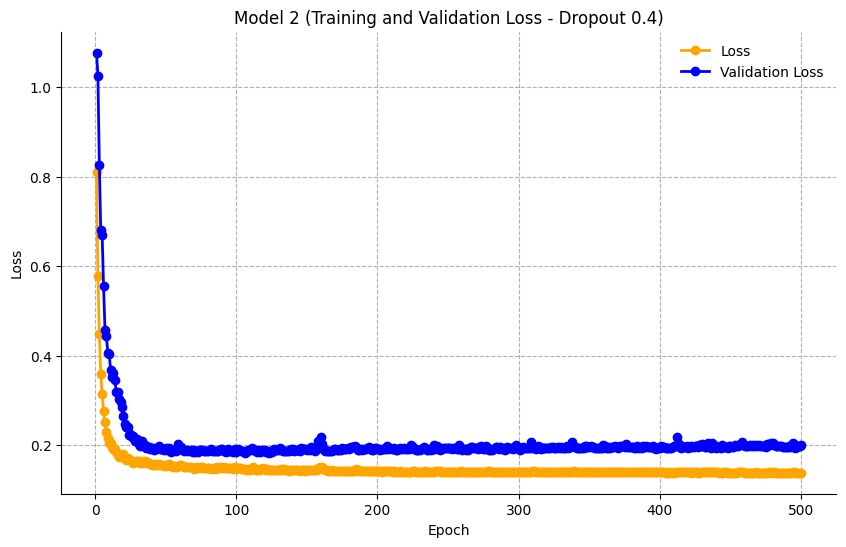

In [38]:
# Load stored data
checkpoint_path2 = "/content/checkpoint_model_2/cp-{epoch:04d}.ckpt"
checkpoint_dir2 = os.path.dirname(checkpoint_path2)
model2 = model_2()
model2.compile(loss='mean_squared_error', optimizer='adam')
latest2 = tf.train.latest_checkpoint(checkpoint_dir2)
print(latest2)
model2.load_weights(latest2)

# Load loss history
with open('loss_history_2.pickle', 'rb') as f:
    data = pickle.load(f)
    if len(data) == 2:
        loss_history2, val_loss_history2 = data
        epochs_train2 = len(loss_history2)
    elif len(data) == 3:
        loss_history2, val_loss_history2, epochs_train2 = data
    else:
        raise ValueError("Invalid data format in the pickle file.")

# Visualize training
def get_figure():
    """
    Returns figure and axis objects to plot on.
    Removes top and right border and ticks because those are ugly.
    """
    fig, ax = plt.subplots(1, figsize=(10, 6))  # Adjust the figsize as desired
    plt.tick_params(top=False, right=False, which='both')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return fig, ax

# Plot loss history
fig, ax = get_figure()
ax.plot(np.arange(epochs_train2) + 1, loss_history2, marker="o", linewidth=2, color="orange", label="Loss")
ax.plot(np.arange(epochs_train2) + 1, val_loss_history2, marker="o", linewidth=2, color="blue", label="Validation Loss")
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(frameon=False)
ax.set_title('Model 2 (Training and Validation Loss - Dropout 0.4)')
ax.grid(True, linestyle='--')
#plt.ylim((0, 0.5))
plt.show()

##### Adam optimizer 20% validation data

/content/checkpoint_model_2/cp-0001.ckpt


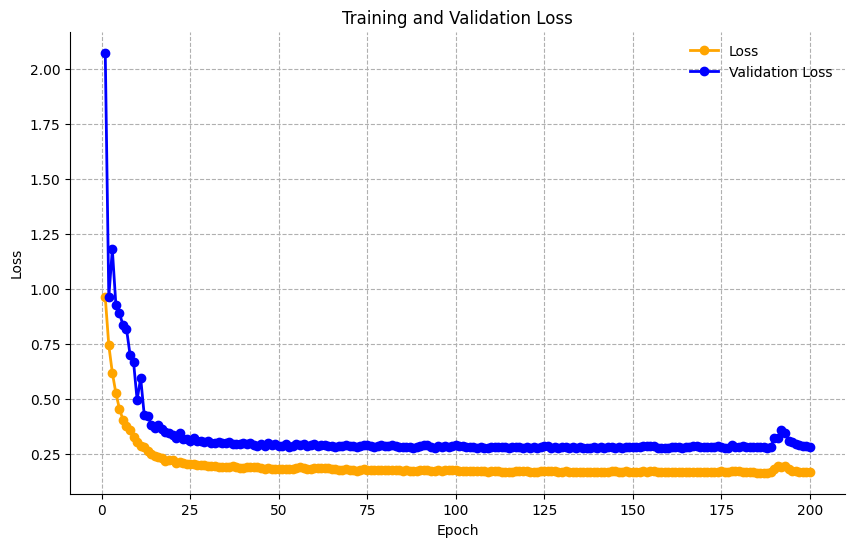

In [ ]:
# Load stored data
checkpoint_path2 = "/content/checkpoint_model_2/cp-{epoch:04d}.ckpt"
checkpoint_dir2 = os.path.dirname(checkpoint_path2)
model2 = model_2()
model2.compile(loss='mean_squared_error', optimizer='adam')
latest2 = tf.train.latest_checkpoint(checkpoint_dir2)
print(latest2)
model2.load_weights(latest2)

# Load loss history
with open('loss_history_2.pickle', 'rb') as f:
    data = pickle.load(f)
    if len(data) == 2:
        loss_history2, val_loss_history2 = data
        epochs_train2 = len(loss_history2)
    elif len(data) == 3:
        loss_history2, val_loss_history2, epochs_train2 = data
    else:
        raise ValueError("Invalid data format in the pickle file.")

# Visualize training
def get_figure():
    """
    Returns figure and axis objects to plot on.
    Removes top and right border and ticks because those are ugly.
    """
    fig, ax = plt.subplots(1, figsize=(10, 6))  # Adjust the figsize as desired
    plt.tick_params(top=False, right=False, which='both')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return fig, ax

# Plot loss history
fig, ax = get_figure()
ax.plot(np.arange(epochs_train2) + 1, loss_history2, marker="o", linewidth=2, color="orange", label="Loss")
ax.plot(np.arange(epochs_train2) + 1, val_loss_history2, marker="o", linewidth=2, color="blue", label="Validation Loss")
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(frameon=False)
ax.set_title('Training and Validation Loss')
ax.grid(True, linestyle='--')
plt.show()

##### Adam no validation data

/content/checkpoint_model_2/cp-0001.ckpt


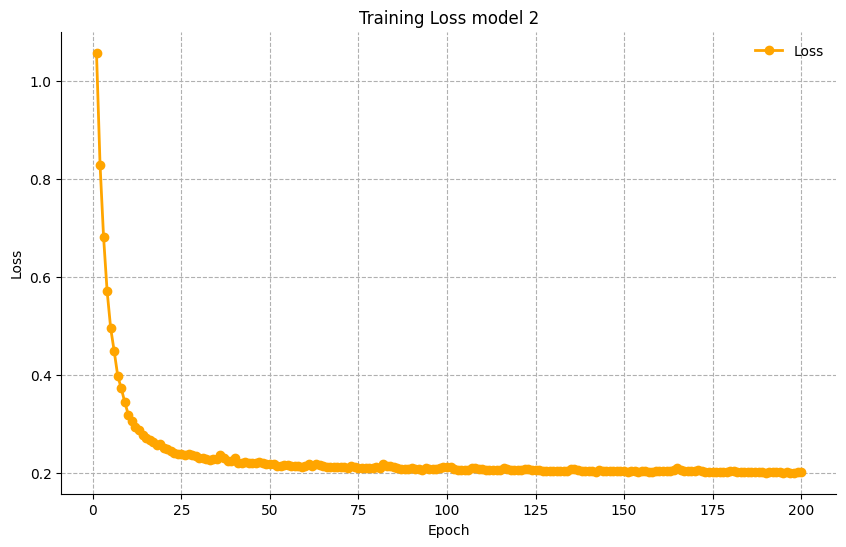

In [ ]:
# Load stored data
checkpoint_path2 = "/content/checkpoint_model_2/cp-{epoch:04d}.ckpt"
checkpoint_dir2 = os.path.dirname(checkpoint_path2)
model2 = model_2()
model2.compile(loss='mean_squared_error', optimizer='adam')
latest2 = tf.train.latest_checkpoint(checkpoint_dir2)
print(latest2)
model2.load_weights(latest2)

# Load loss history
with open('loss_history_2.pickle', 'rb') as f:
    data = pickle.load(f)
    if len(data) == 2:
        loss_history2, val_loss_history2 = data
        epochs_train2 = len(loss_history2)
    elif len(data) == 3:
        loss_history2, val_loss_history2, epochs_train2 = data
    else:
        raise ValueError("Invalid data format in the pickle file.")

# Visualize training
def get_figure():
    """
    Returns figure and axis objects to plot on.
    Removes top and right border and ticks because those are ugly.
    """
    fig, ax = plt.subplots(1, figsize=(10, 6))  # Adjust the figsize as desired
    plt.tick_params(top=False, right=False, which='both')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return fig, ax

# Plot loss history
fig, ax = get_figure()
ax.plot(np.arange(epochs_train2) + 1, loss_history2, marker="o", linewidth=2, color="orange", label="Loss")
ax.plot(np.arange(epochs_train2) + 1, val_loss_history2, marker="o", linewidth=2, color="blue", label="Validation Loss")
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(frameon=False)
ax.set_title('Training and Validation Loss')
ax.grid(True, linestyle='--')
plt.show()

##### Nadan optimizer with 20% of validation data

/content/checkpoint_model_2/cp-0001.ckpt


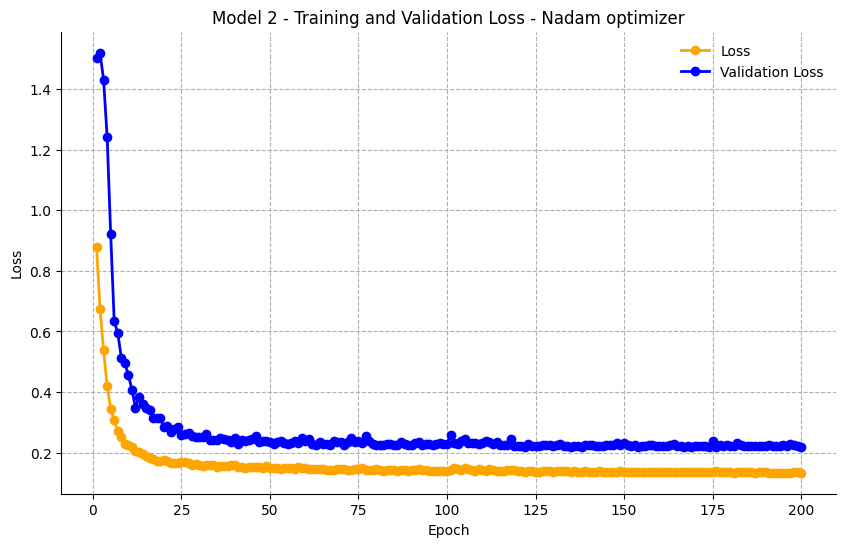

In [ ]:
# Load stored data
checkpoint_path2 = "/content/checkpoint_model_2/cp-{epoch:04d}.ckpt"
checkpoint_dir2 = os.path.dirname(checkpoint_path2)
model2 = model_2()
model2.compile(loss='mean_squared_error', optimizer='adam')
latest2 = tf.train.latest_checkpoint(checkpoint_dir2)
print(latest2)
model2.load_weights(latest2)

# Load loss history
with open('loss_history_2.pickle', 'rb') as f:
    data = pickle.load(f)
    if len(data) == 2:
        loss_history2, val_loss_history2 = data
        epochs_train2 = len(loss_history2)
    elif len(data) == 3:
        loss_history2, val_loss_history2, epochs_train2 = data
    else:
        raise ValueError("Invalid data format in the pickle file.")

# Visualize training
def get_figure():
    """
    Returns figure and axis objects to plot on.
    Removes top and right border and ticks because those are ugly.
    """
    fig, ax = plt.subplots(1, figsize=(10, 6))  # Adjust the figsize as desired
    plt.tick_params(top=False, right=False, which='both')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return fig, ax

# Plot loss history
fig, ax = get_figure()
ax.plot(np.arange(epochs_train2) + 1, loss_history2, marker="o", linewidth=2, color="orange", label="Loss")
ax.plot(np.arange(epochs_train2) + 1, val_loss_history2, marker="o", linewidth=2, color="blue", label="Validation Loss")
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(frameon=False)
ax.set_title('Model 2 - Training and Validation Loss - Nadam optimizer')
ax.grid(True, linestyle='--')
#plt.ylim((0, 0.5))
plt.show()

/content/checkpoint_model_2/cp-0001.ckpt


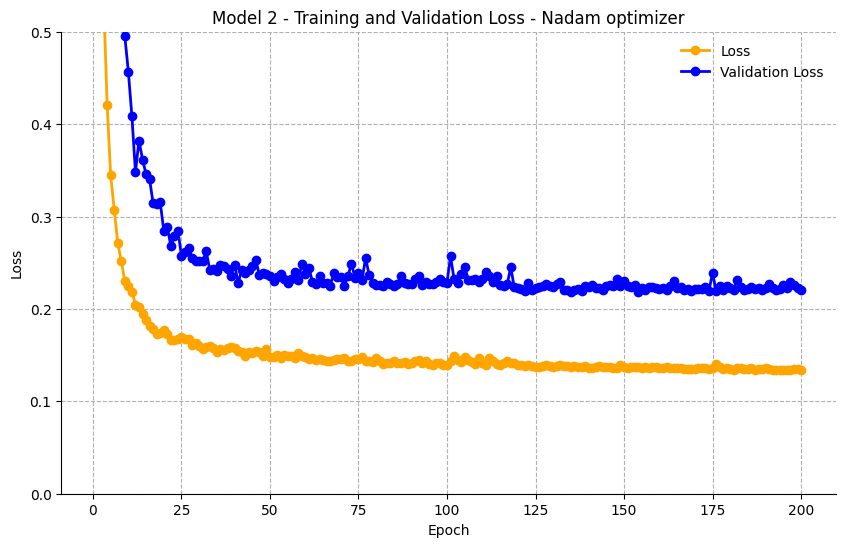

In [ ]:
# Load stored data
checkpoint_path2 = "/content/checkpoint_model_2/cp-{epoch:04d}.ckpt"
checkpoint_dir2 = os.path.dirname(checkpoint_path2)
model2 = model_2()
model2.compile(loss='mean_squared_error', optimizer='adam')
latest2 = tf.train.latest_checkpoint(checkpoint_dir2)
print(latest2)
model2.load_weights(latest2)

# Load loss history
with open('loss_history_2.pickle', 'rb') as f:
    data = pickle.load(f)
    if len(data) == 2:
        loss_history2, val_loss_history2 = data
        epochs_train2 = len(loss_history2)
    elif len(data) == 3:
        loss_history2, val_loss_history2, epochs_train2 = data
    else:
        raise ValueError("Invalid data format in the pickle file.")

# Visualize training
def get_figure():
    """
    Returns figure and axis objects to plot on.
    Removes top and right border and ticks because those are ugly.
    """
    fig, ax = plt.subplots(1, figsize=(10, 6))  # Adjust the figsize as desired
    plt.tick_params(top=False, right=False, which='both')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return fig, ax

# Plot loss history
fig, ax = get_figure()
ax.plot(np.arange(epochs_train2) + 1, loss_history2, marker="o", linewidth=2, color="orange", label="Loss")
ax.plot(np.arange(epochs_train2) + 1, val_loss_history2, marker="o", linewidth=2, color="blue", label="Validation Loss")
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(frameon=False)
ax.set_title('Model 2 - Training and Validation Loss - Nadam optimizer')
ax.grid(True, linestyle='--')
plt.ylim((0, 0.5))
plt.show()

##### ***Architecture Comparison Adam optimizer***

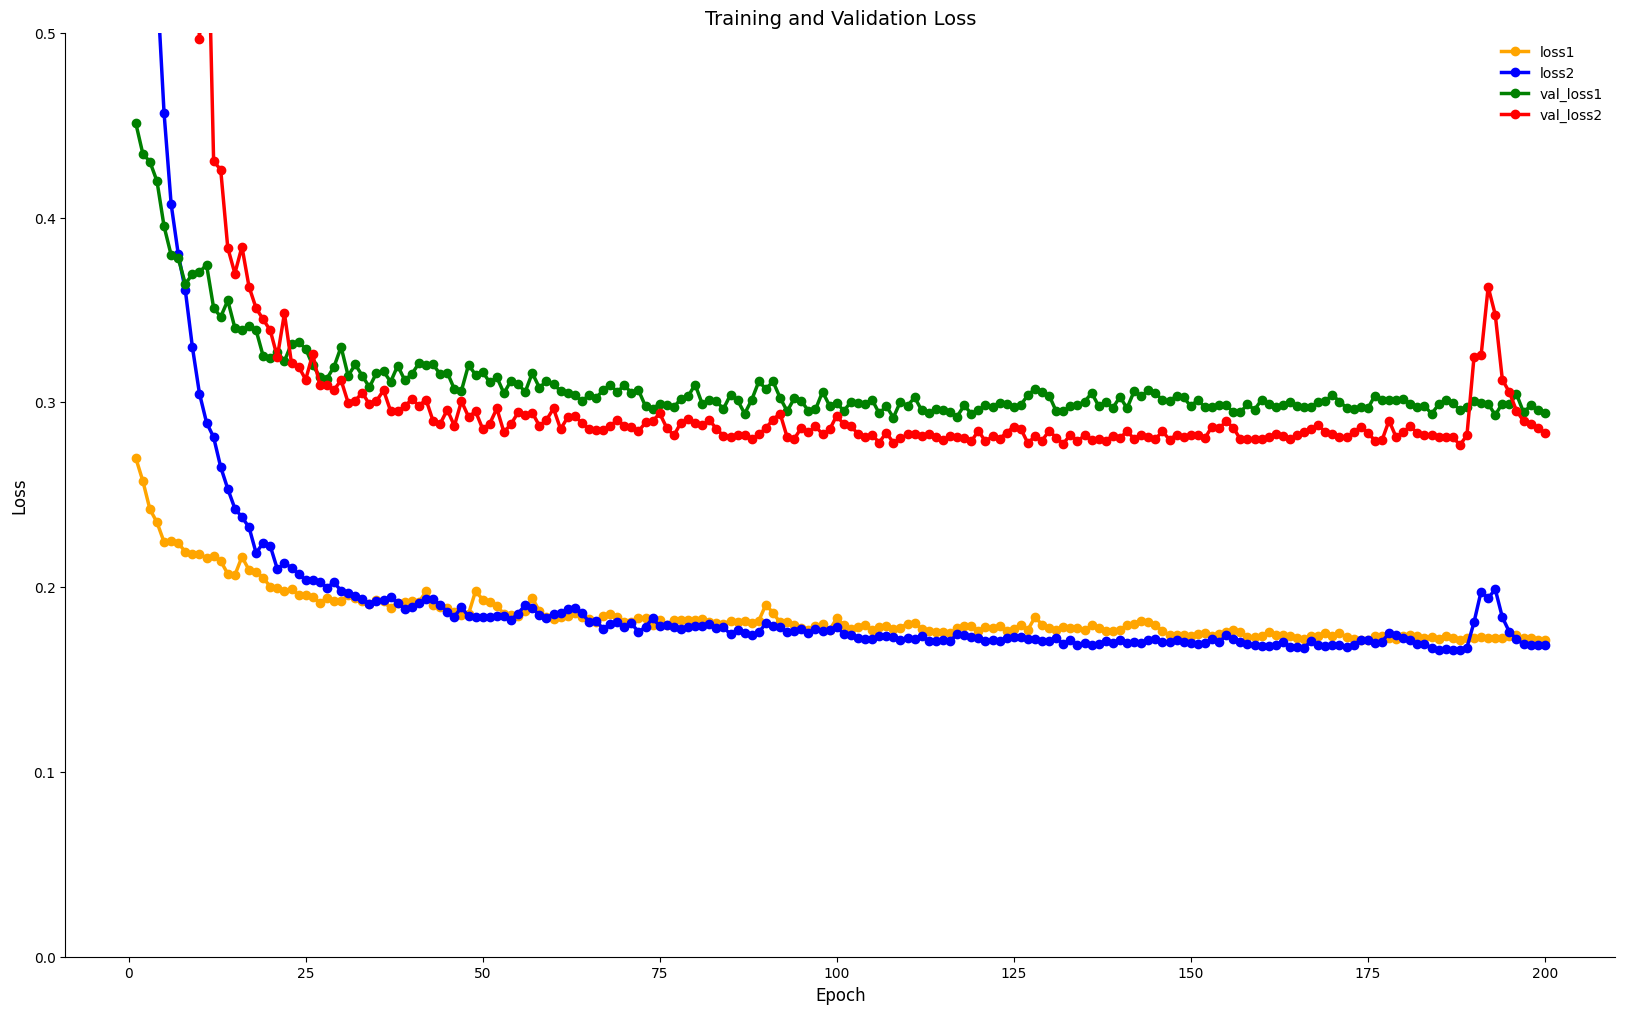

In [ ]:
with open('loss_history_1.pickle', 'rb') as f:
    [loss_history1, val_loss_history1, epochs_train1] = pickle.load(f)

with open('loss_history_2.pickle', 'rb') as f:
    [loss_history2, val_loss_history2, epochs_train2] = pickle.load(f)

# Visualize training
def get_figure():
    """
    Returns figure and axis objects to plot on. 
    Removes top and right border and ticks because those are ugly
    """
    fig, ax = plt.subplots(1, figsize=(20, 12))
    plt.tick_params(top=False, right=False, which='both') 
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return fig, ax

fig, ax = get_figure()

ax.plot(np.arange(epochs_train1) + 1, loss_history1, marker="o", linewidth=2.5, color="orange", label="loss1")
ax.plot(np.arange(epochs_train2) + 1, loss_history2, marker="o", linewidth=2.5, color="blue", label="loss2")
ax.plot(np.arange(epochs_train1) + 1, val_loss_history1, marker="o", linewidth=2.5, color="green", label="val_loss1")
ax.plot(np.arange(epochs_train2) + 1, val_loss_history2, marker="o", linewidth=2.5, color="red", label="val_loss2")
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.set_title('Training and Validation Loss', fontsize=14)
ax.legend(frameon=False, fontsize=10)
plt.ylim((0, 0.5))

plt.show()

##### ***Architecture Comparison Nadam optimizer***

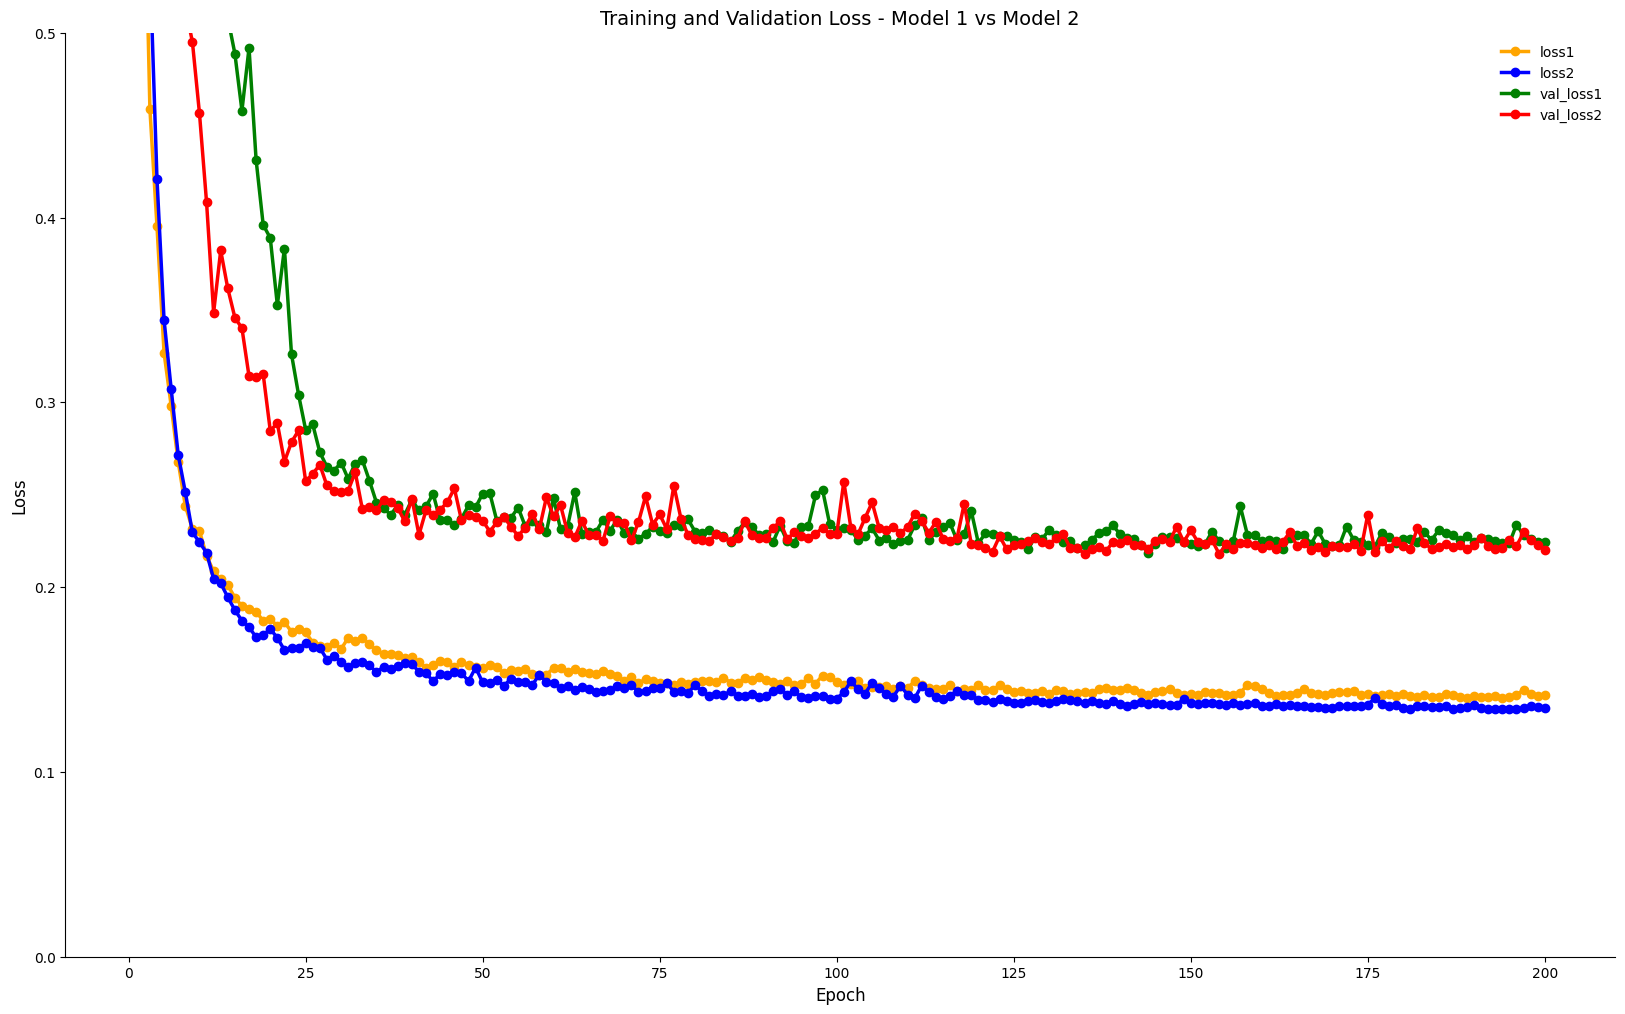

In [ ]:
with open('loss_history_1.pickle', 'rb') as f:
    [loss_history1, val_loss_history1, epochs_train1] = pickle.load(f)

with open('loss_history_2.pickle', 'rb') as f:
    [loss_history2, val_loss_history2, epochs_train2] = pickle.load(f)

# Visualize training
def get_figure():
    """
    Returns figure and axis objects to plot on. 
    Removes top and right border and ticks because those are ugly
    """
    fig, ax = plt.subplots(1, figsize=(20, 12))
    plt.tick_params(top=False, right=False, which='both') 
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return fig, ax

fig, ax = get_figure()

ax.plot(np.arange(epochs_train1) + 1, loss_history1, marker="o", linewidth=2.5, color="orange", label="loss1")
ax.plot(np.arange(epochs_train2) + 1, loss_history2, marker="o", linewidth=2.5, color="blue", label="loss2")
ax.plot(np.arange(epochs_train1) + 1, val_loss_history1, marker="o", linewidth=2.5, color="green", label="val_loss1")
ax.plot(np.arange(epochs_train2) + 1, val_loss_history2, marker="o", linewidth=2.5, color="red", label="val_loss2")
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.set_title('Training and Validation Loss - Model 1 vs Model 2', fontsize=14)
ax.legend(frameon=False, fontsize=10)
plt.ylim((0, 0.5))

plt.show()

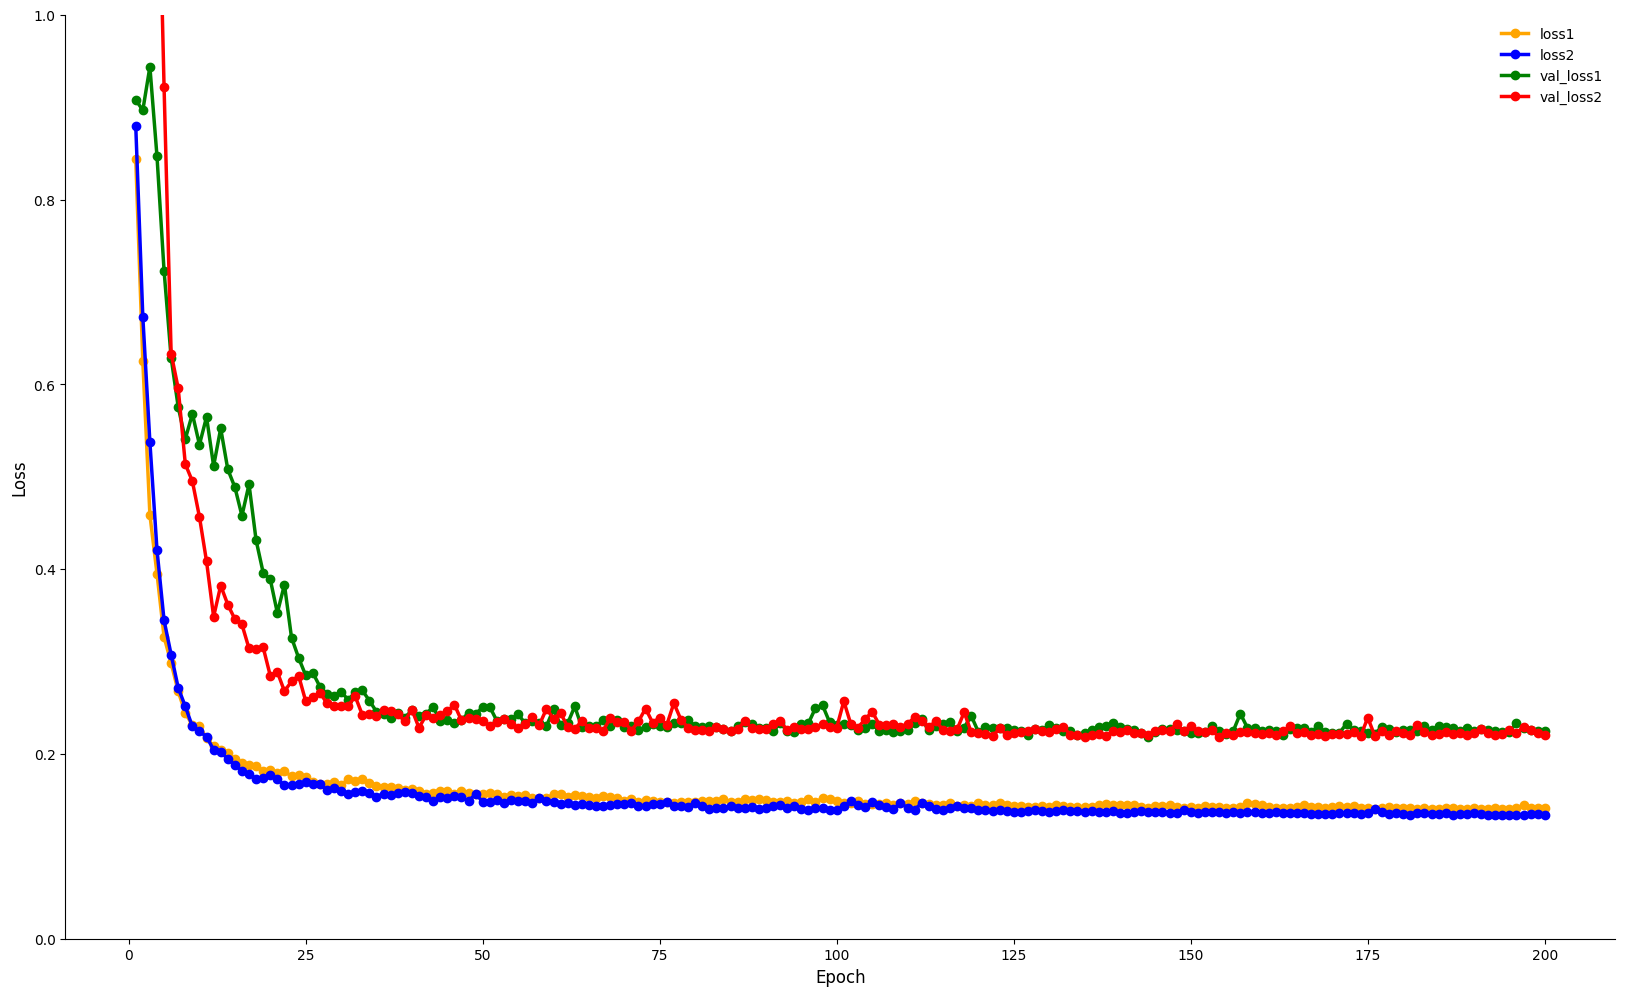

In [ ]:
with open('loss_history_1.pickle', 'rb') as f:
    [loss_history1, val_loss_history1, epochs_train1] = pickle.load(f)

with open('loss_history_2.pickle', 'rb') as f:
    [loss_history2, val_loss_history2, epochs_train2] = pickle.load(f)

# Visualize training
def get_figure():
    """
    Returns figure and axis objects to plot on. 
    Removes top and right border and ticks because those are ugly
    """
    fig, ax = plt.subplots(1, figsize=(20, 12))
    plt.tick_params(top=False, right=False, which='both') 
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return fig, ax

fig, ax = get_figure()

ax.plot(np.arange(epochs_train1) + 1, loss_history1, marker="o", linewidth=2.5, color="orange", label="loss1")
ax.plot(np.arange(epochs_train2) + 1, loss_history2, marker="o", linewidth=2.5, color="blue", label="loss2")
ax.plot(np.arange(epochs_train1) + 1, val_loss_history1, marker="o", linewidth=2.5, color="green", label="val_loss1")
ax.plot(np.arange(epochs_train2) + 1, val_loss_history2, marker="o", linewidth=2.5, color="red", label="val_loss2")
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
'Training and Validation Loss - Model 1 vs Model 2'
ax.legend(frameon=False, fontsize=10)
plt.ylim((0, 1))

plt.show()

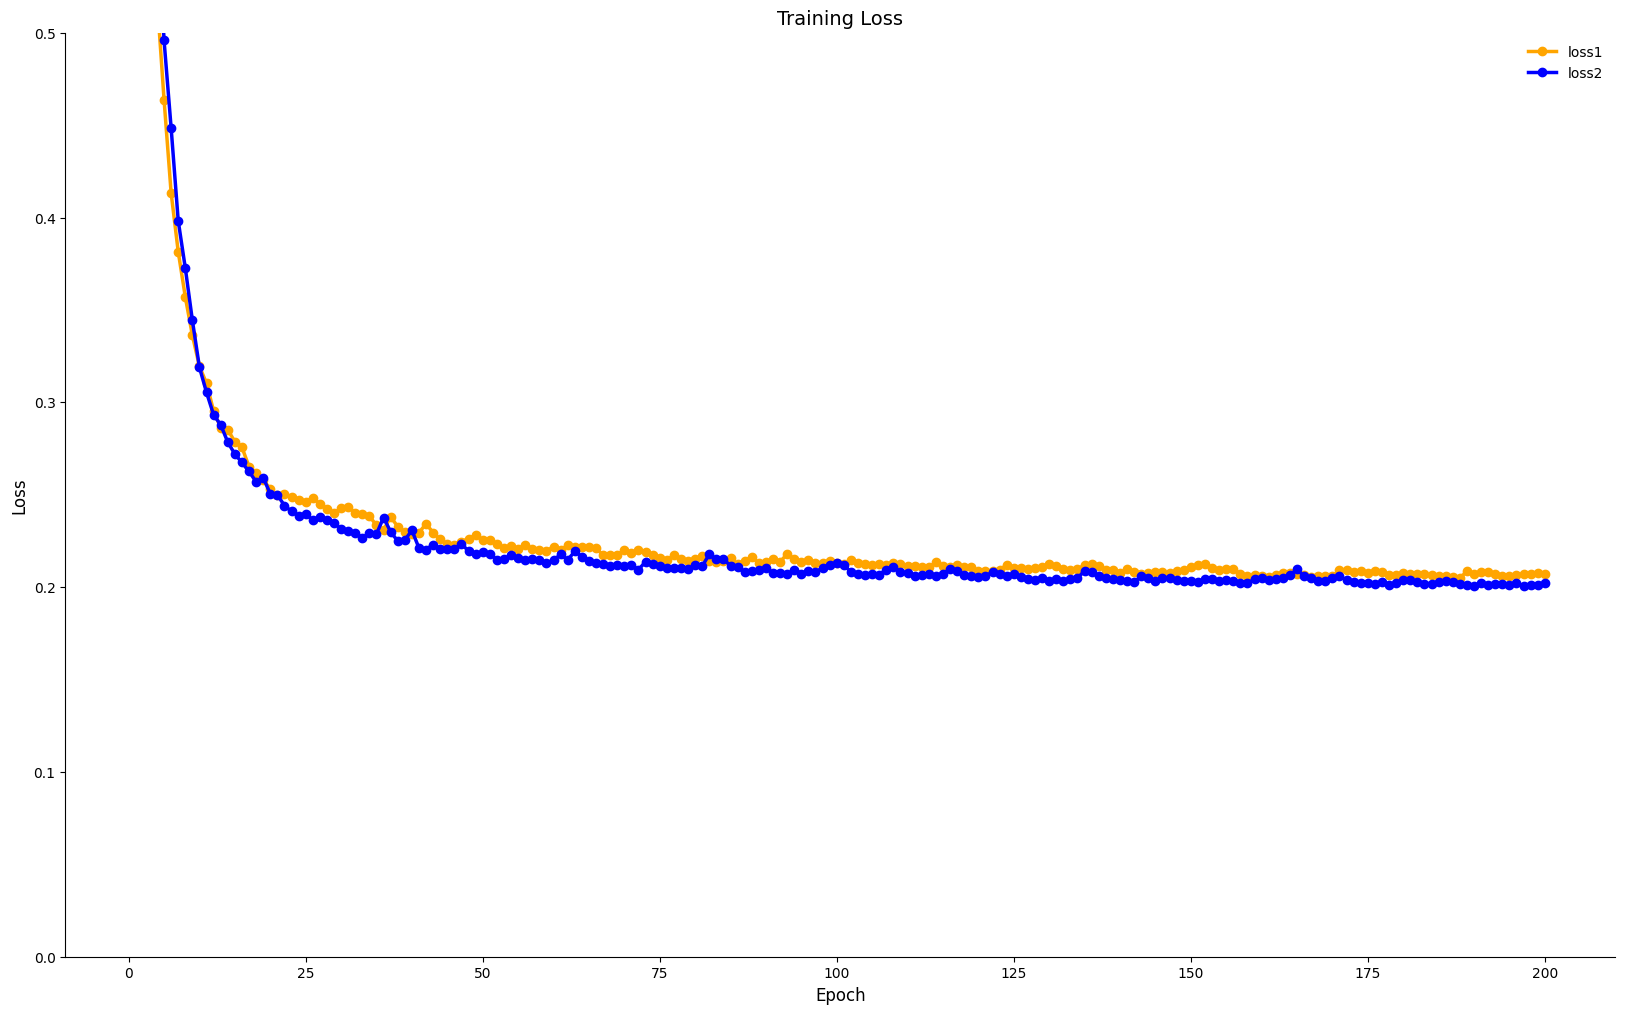

In [ ]:
with open('loss_history_1.pickle', 'rb') as f:
    [loss_history1, epochs_train1] = pickle.load(f)

with open('loss_history_2.pickle', 'rb') as f:
    [loss_history2, epochs_train2] = pickle.load(f)

# Visualize training
def get_figure():
    """
    Returns figure and axis objects to plot on. 
    Removes top and right border and ticks, because those are ugly
    """
    fig, ax = plt.subplots(1, figsize=(20, 12))
    plt.tick_params(top=False, right=False, which='both') 
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return fig, ax
  
fig, ax = get_figure()

ax.plot(np.arange(epochs_train1) + 1, loss_history1, marker="o", linewidth=2.5, color="orange", label="loss1")
ax.plot(np.arange(epochs_train2) + 1, loss_history2, marker="o", linewidth=2.5, color="blue", label="loss2")
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.set_title('Training Loss', fontsize=14)
ax.legend(frameon=False, fontsize=10)
plt.ylim((0, 0.5))

plt.show()


##### ***Model prediction 2***

###### ***Model prediction 2 - Adam***

Shape of testing data: (1, 64, 64, 64, 1)
1/1 [==============================] - 0s 494ms/step
Shape of testing data: (1, 64, 64, 64, 1)


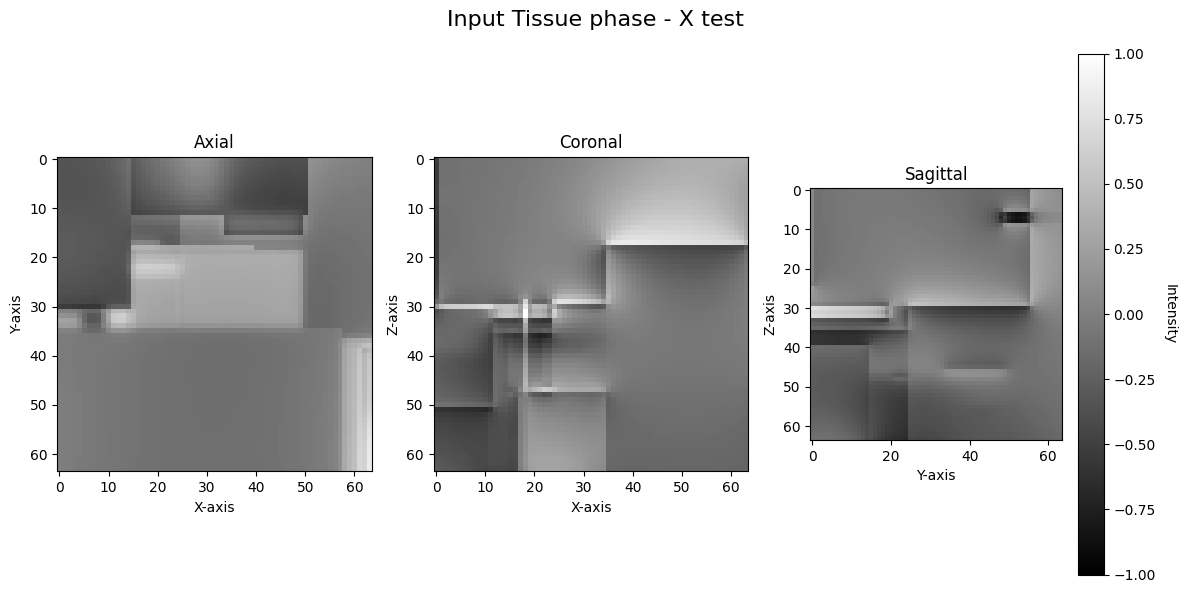

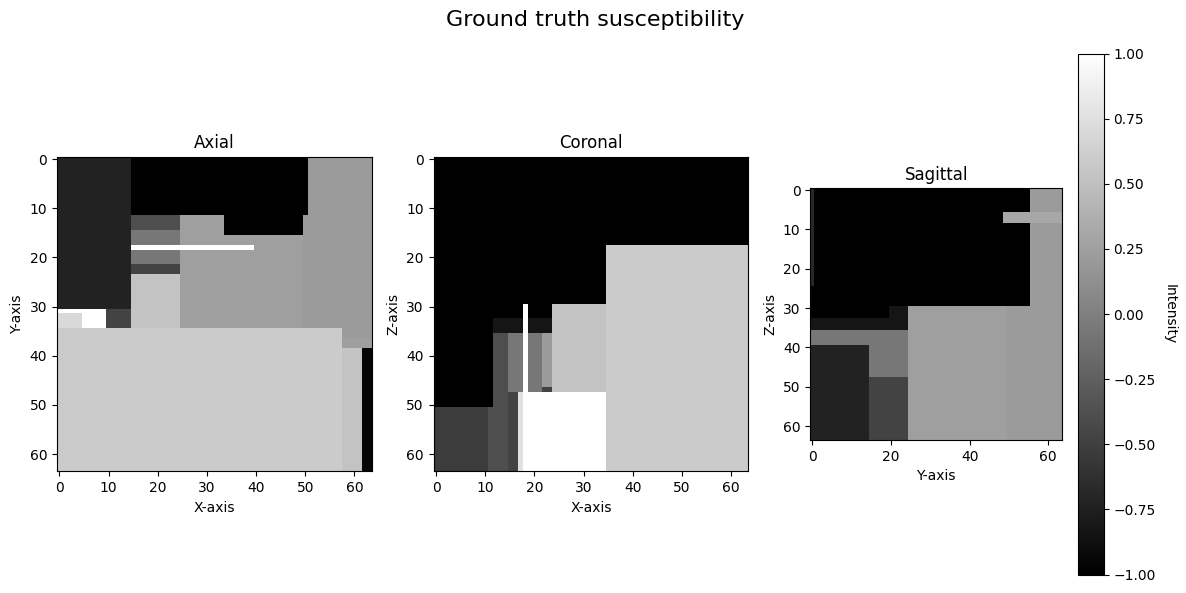

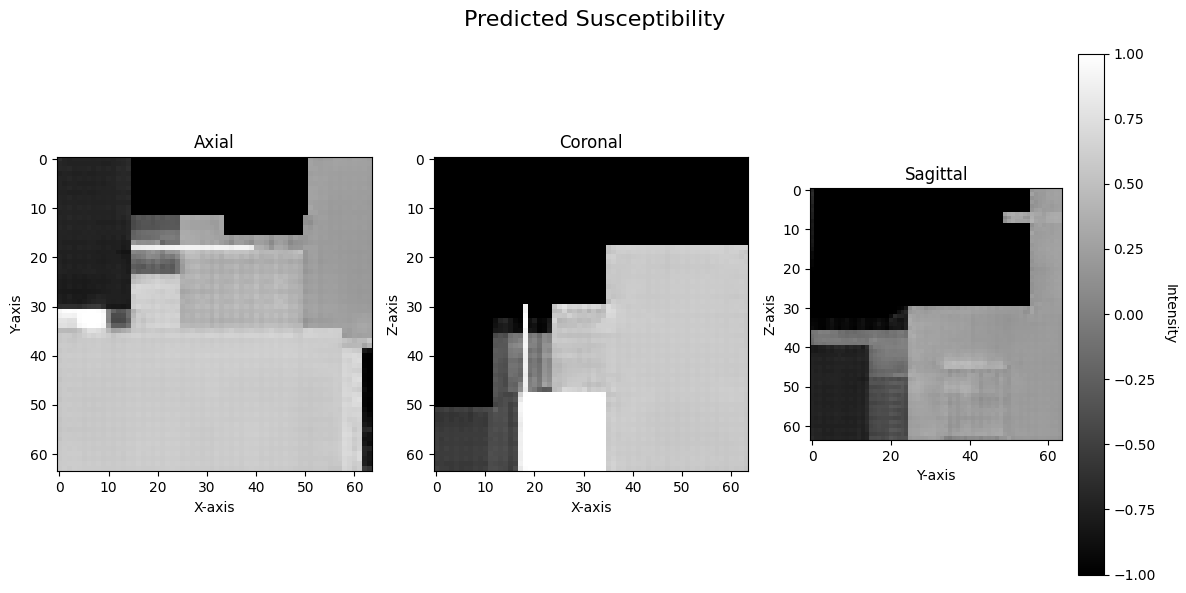

In [39]:
test_patch_nbr = 10
X_test = simulation_fw_patches[np.newaxis, test_patch_nbr,:,:,:, np.newaxis]
print(f"Shape of testing data: {X_test.shape}")

# Getting prediction from model without training
y_pred = unet_model2.predict(X_test)
print(f"Shape of testing data: {X_test.shape}")
view_slices_3d(X_test[0, :, :, :], slice_nbr = 16, vmin = -1,vmax = 1, title='Input Tissue phase - X test')
view_slices_3d(simulation_gt_patches[test_patch_nbr, :, :, :], slice_nbr = 16, vmin = -1,vmax = 1, title='Ground truth susceptibility')
view_slices_3d(y_pred[0, :, :, :, 0], slice_nbr=16, vmin=-1, vmax=1, title='Predicted Susceptibility')


(1, 160, 160, 160, 1)
1/1 [==============================] - 0s 41ms/step
(1, 160, 160, 160, 1)


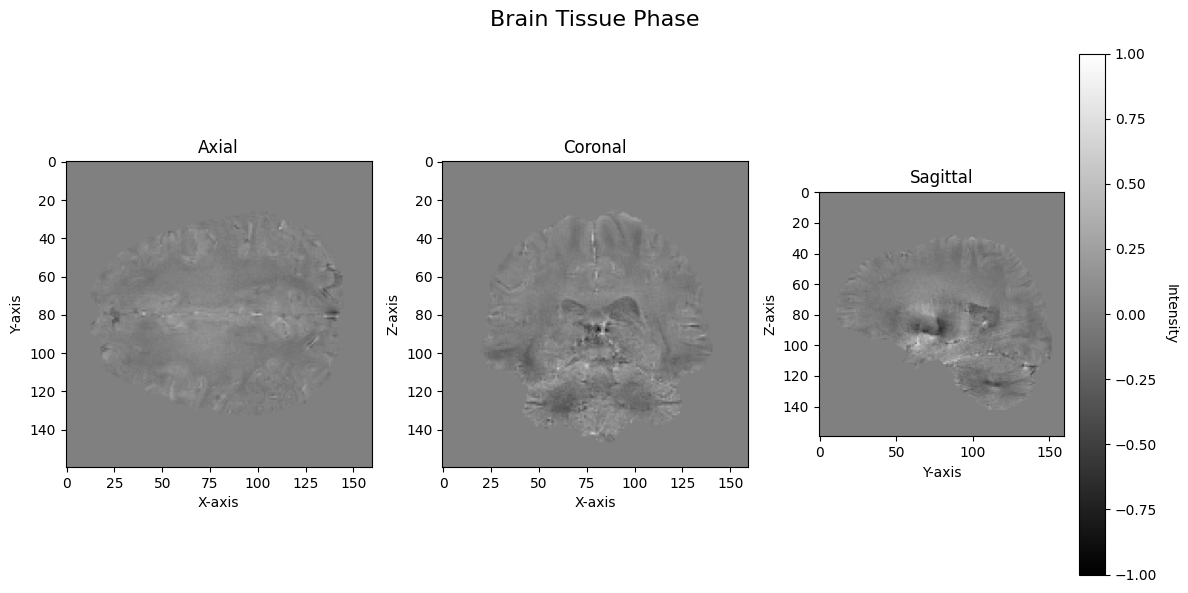

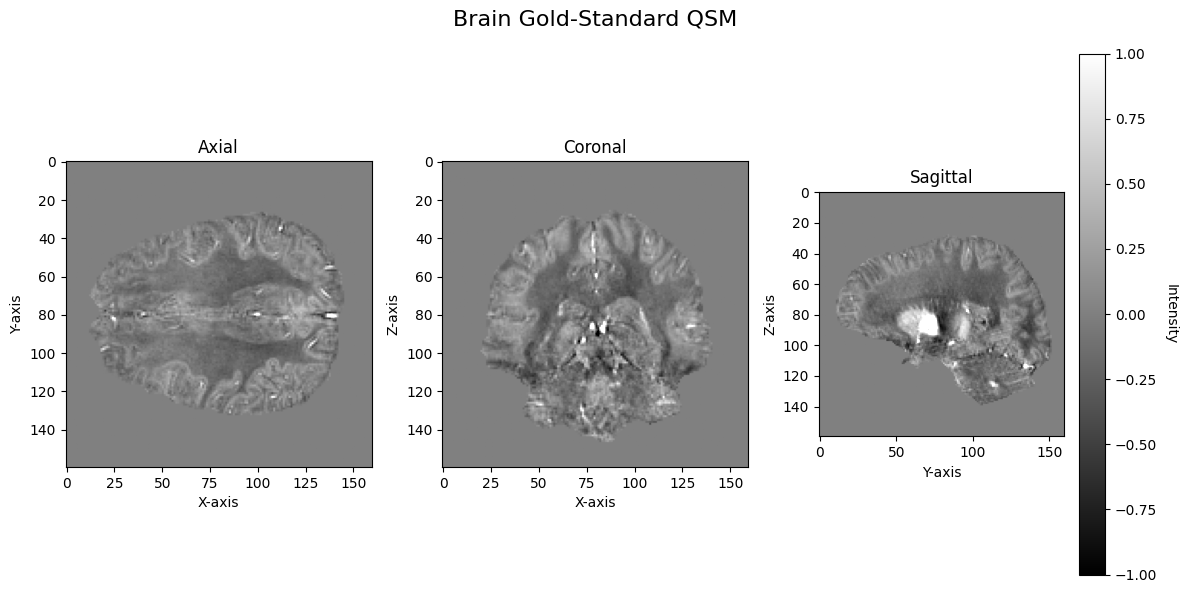

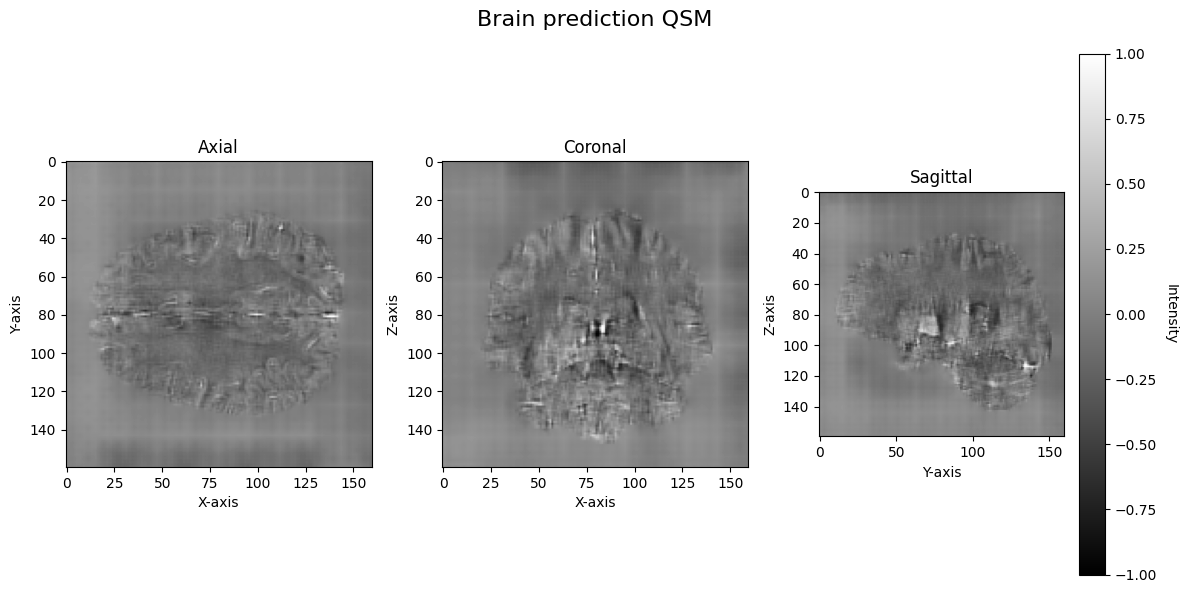

In [ ]:
# Predictions of validations with 35% of data
X_test = tissue_phase_brain[np.newaxis, :, :, :, np.newaxis] * 10
print(X_test.shape)

y_pred = unet_model2.predict(X_test)

print(y_pred.shape)

view_slices_3d(X_test[0, :, :, :, 0], slice_nbr=100, vmin=-1, vmax=1, title='Brain Tissue Phase')
view_slices_3d(gold_standard_qsm*10, slice_nbr=100, vmin=-1, vmax=1, title='Brain Gold-Standard QSM') 
view_slices_3d(y_pred[0, :, :, :, 0], slice_nbr=100, vmin=-1, vmax=1, title='Brain prediction QSM') 

(1, 160, 160, 160, 1)
1/1 [==============================] - 2s 2s/step
(1, 160, 160, 160, 1)


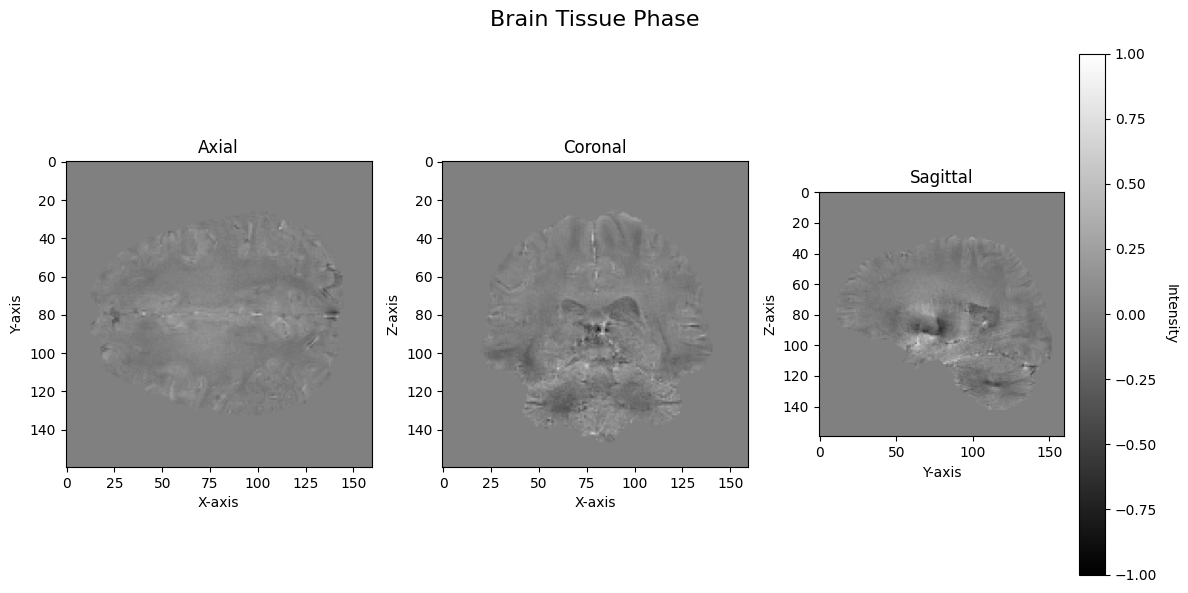

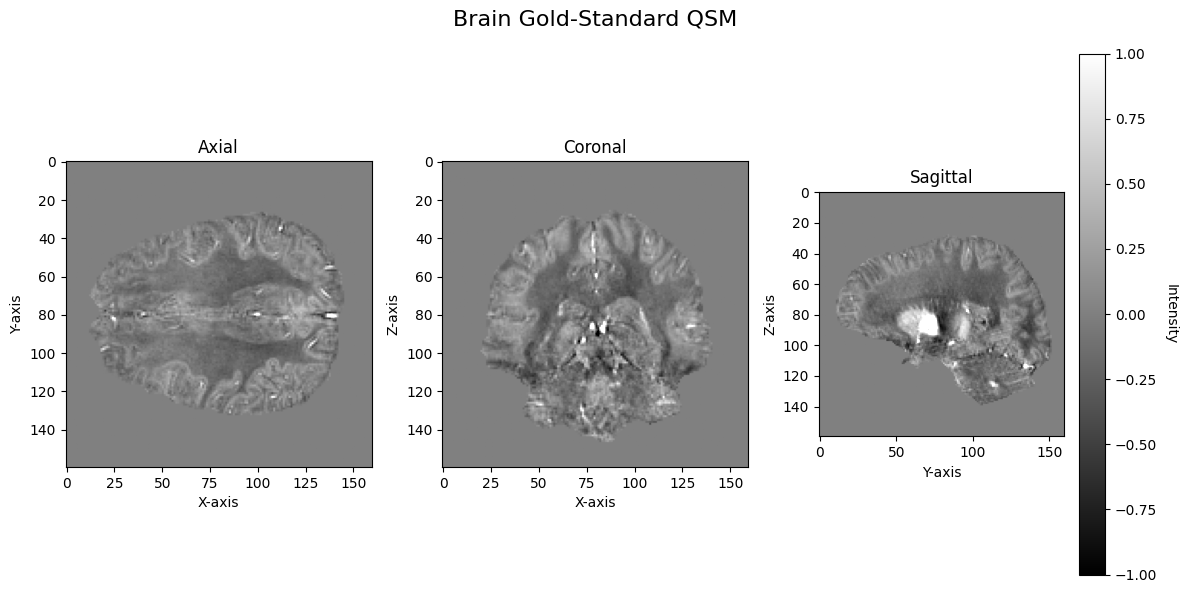

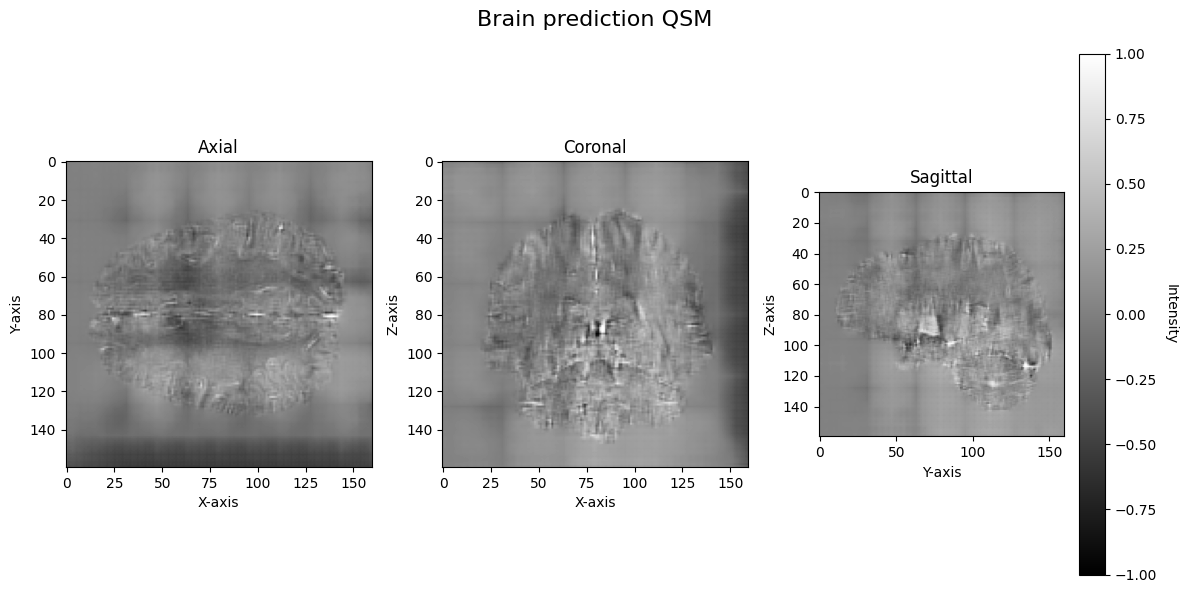

In [ ]:
# Predictions of validations with 20% of data
X_test = tissue_phase_brain[np.newaxis, :, :, :, np.newaxis] * 10
print(X_test.shape)

y_pred = unet_model2.predict(X_test)

print(y_pred.shape)

view_slices_3d(X_test[0, :, :, :, 0], slice_nbr=100, vmin=-1, vmax=1, title='Brain Tissue Phase')
view_slices_3d(gold_standard_qsm[:, :, :]*10, slice_nbr=100, vmin=-1, vmax=1, title='Brain Gold-Standard QSM') 
view_slices_3d(y_pred[0, :, :, :, 0], slice_nbr=100, vmin=-1, vmax=1, title='Brain prediction QSM') 

###### ***Model prediction 2 - Nadam optimizer***

Shape of testing data: (1, 64, 64, 64, 1)
1/1 [==============================] - 1s 525ms/step
Shape of testing data: (1, 64, 64, 64, 1)


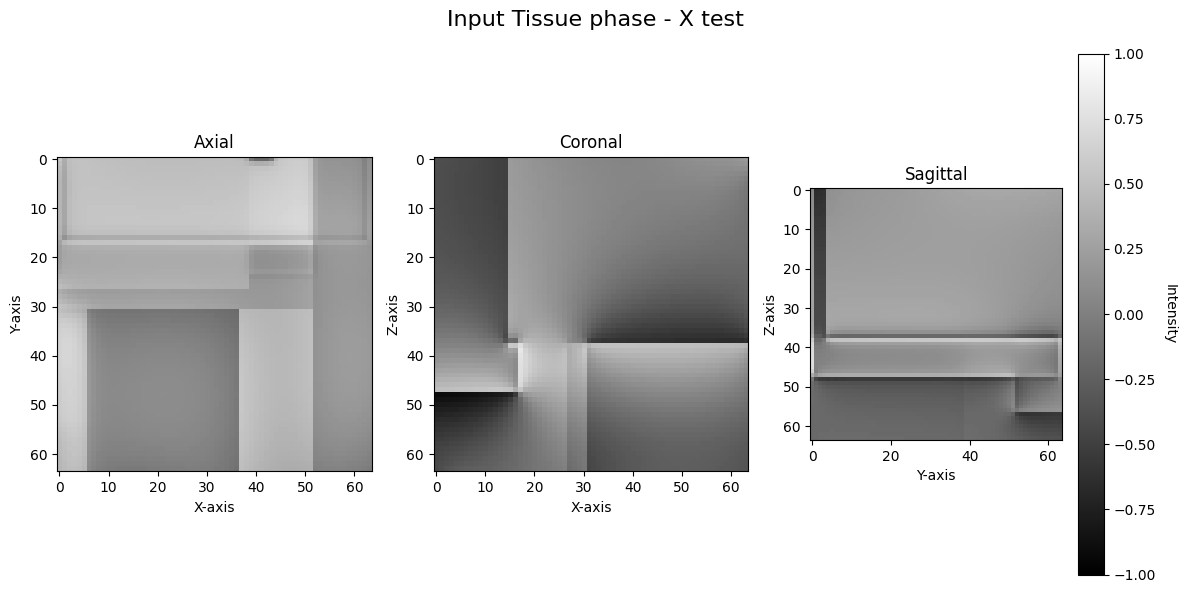

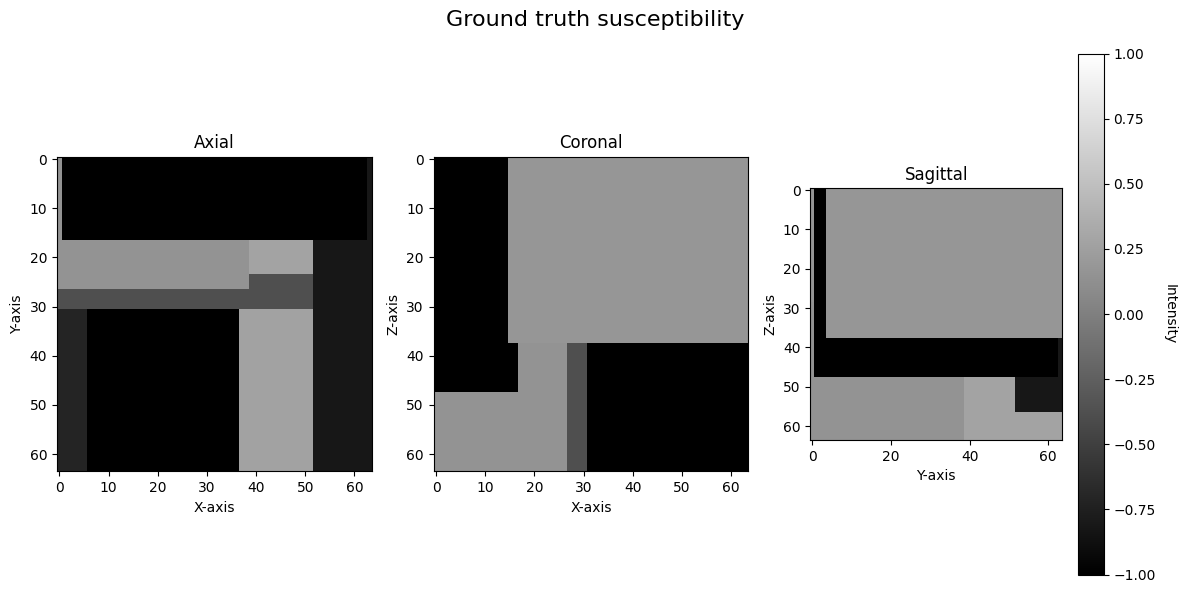

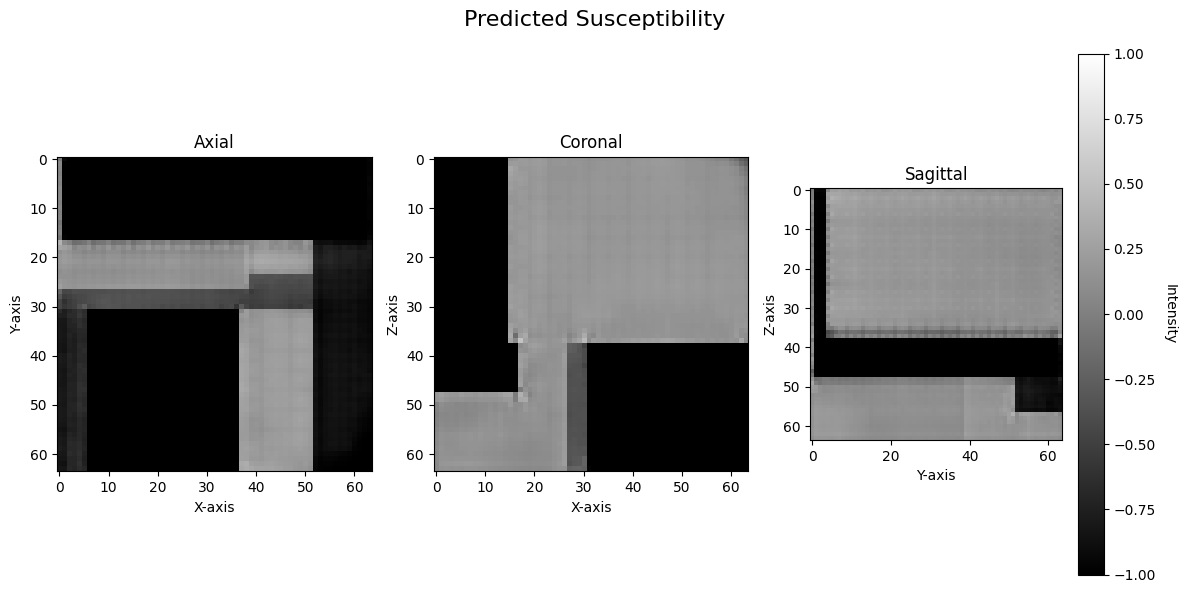

In [ ]:
test_patch_nbr = 10
X_test = simulation_fw_patches[np.newaxis, test_patch_nbr,:,:,:, np.newaxis]
print(f"Shape of testing data: {X_test.shape}")

# Getting prediction from model without training
y_pred = unet_model2.predict(X_test)
print(f"Shape of testing data: {X_test.shape}")
view_slices_3d(X_test[0, :, :, :], slice_nbr = 16, vmin = -1,vmax = 1, title='Input Tissue phase - X test')
view_slices_3d(simulation_gt_patches[test_patch_nbr, :, :, :], slice_nbr = 16, vmin = -1,vmax = 1, title='Ground truth susceptibility')
view_slices_3d(y_pred[0, :, :, :, 0], slice_nbr=16, vmin=-1, vmax=1, title='Predicted Susceptibility')


(1, 160, 160, 160, 1)
1/1 [==============================] - 0s 38ms/step
(1, 160, 160, 160, 1)


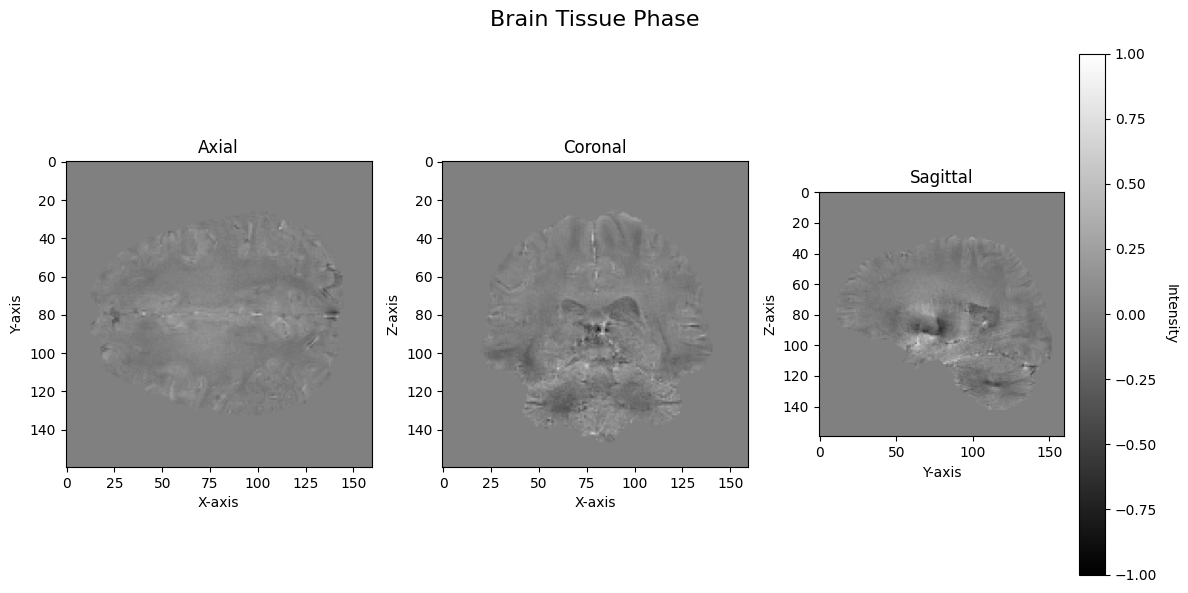

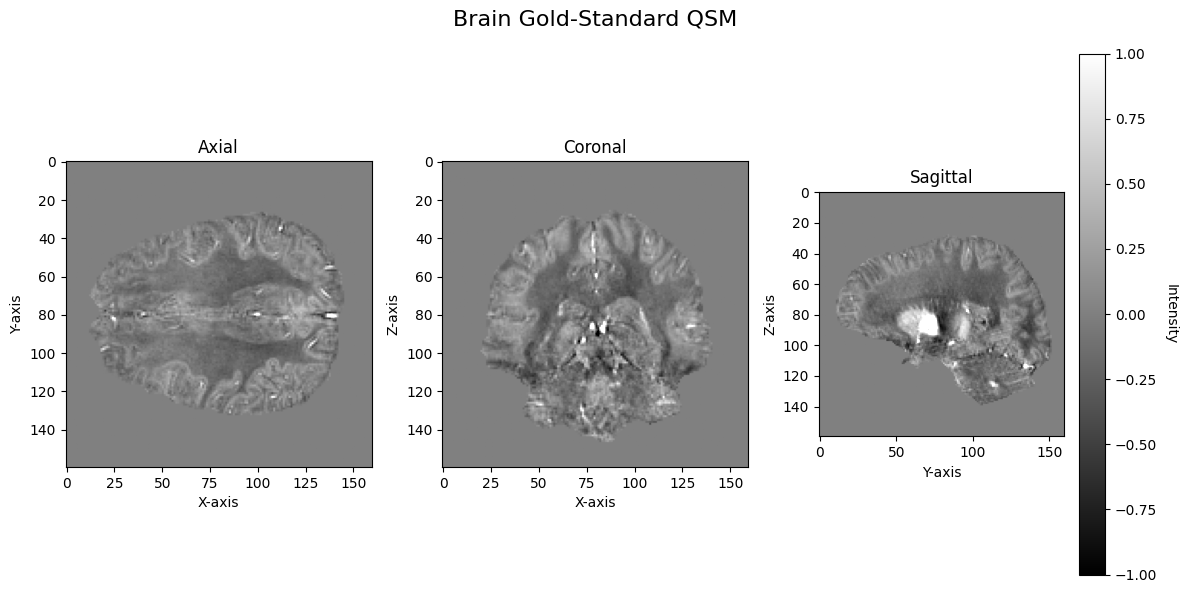

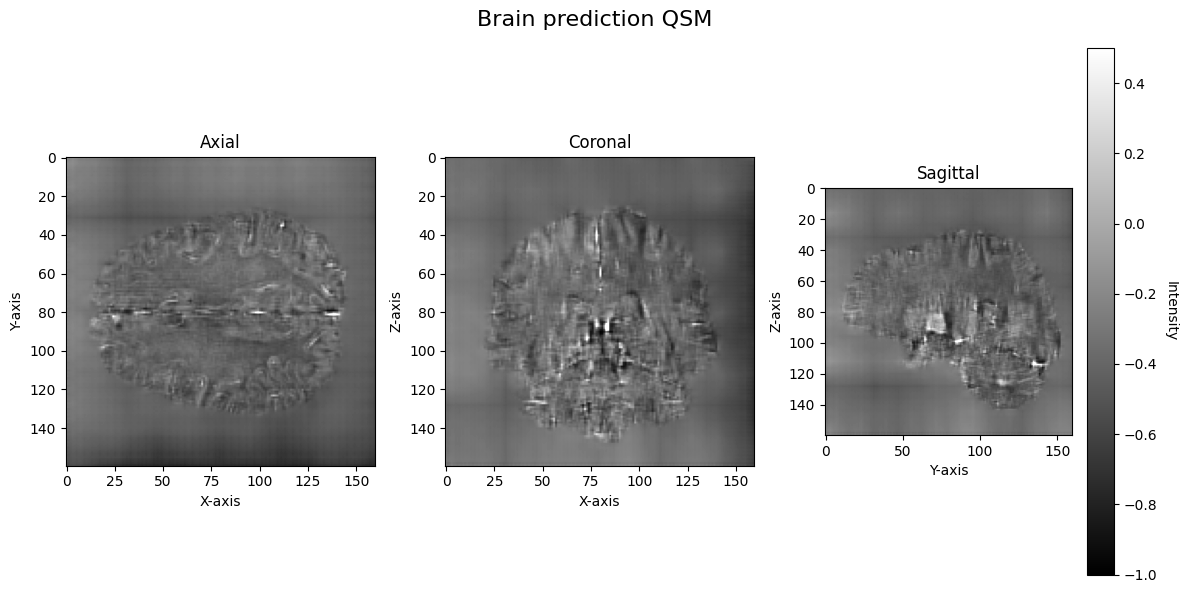

In [ ]:
# Predictions of validations with 20% of data
X_test = tissue_phase_brain[np.newaxis, :, :, :, np.newaxis] * 10
print(X_test.shape)

y_pred = unet_model2.predict(X_test)

print(y_pred.shape)

view_slices_3d(X_test[0, :, :, :, 0], slice_nbr=100, vmin=-1, vmax=1, title='Brain Tissue Phase')
view_slices_3d(gold_standard_qsm[:, :, :]*10, slice_nbr=100, vmin=-1, vmax=1, title='Brain Gold-Standard QSM') 
view_slices_3d(y_pred[0, :, :, :, 0], slice_nbr=100, vmin=-1, vmax=0.5, title='Brain prediction QSM') 

In [41]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


(1, 160, 160, 160, 1)
1/1 [==============================] - 1s 796ms/step
(1, 160, 160, 160, 1)


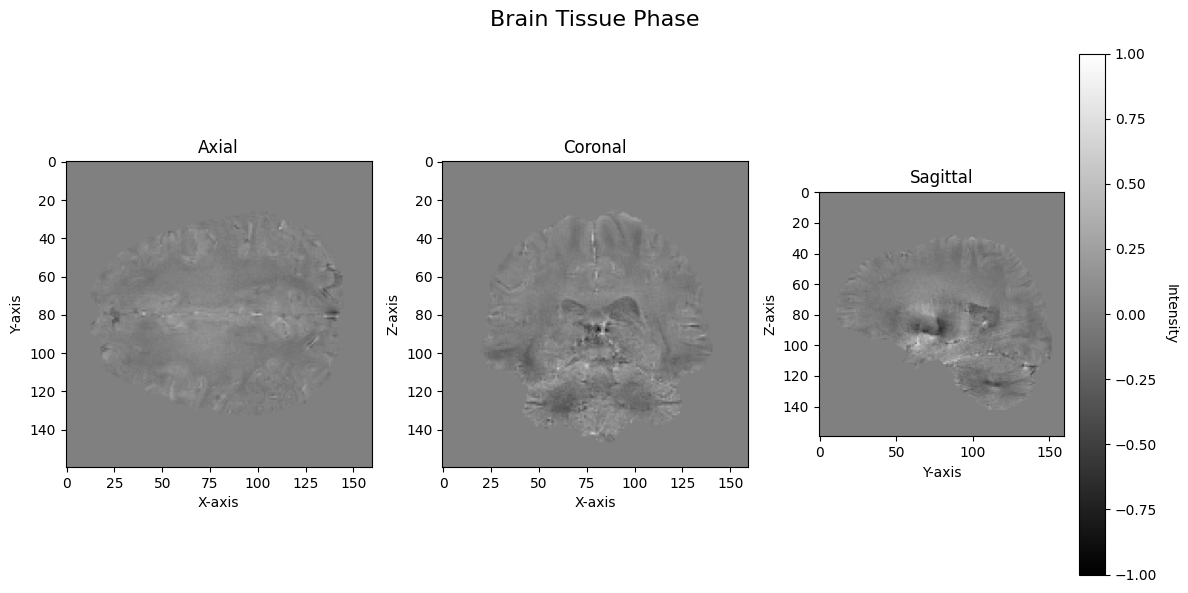

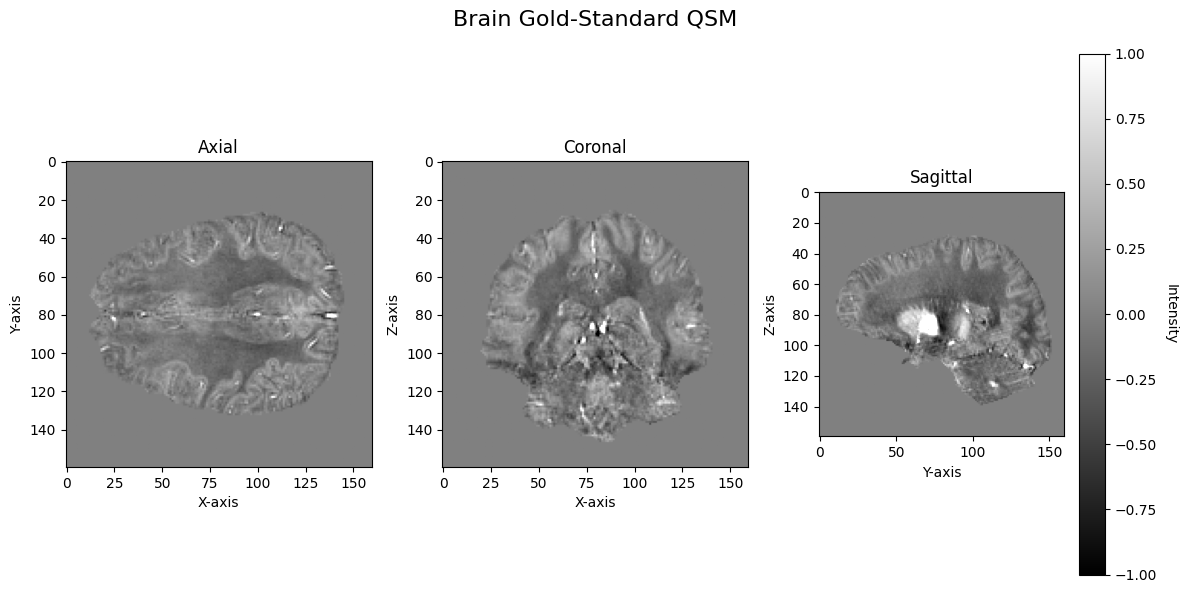

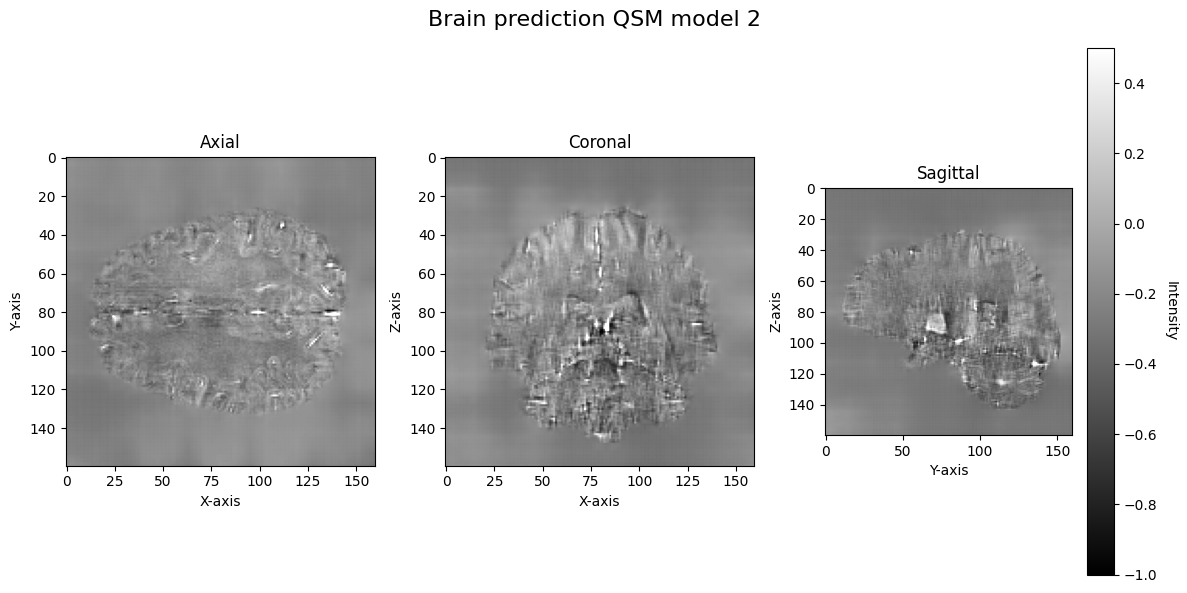

In [40]:
# Predictions of validations with 20% of data
X_test = tissue_phase_brain[np.newaxis, :, :, :, np.newaxis] * 10
print(X_test.shape)

y_pred = unet_model2.predict(X_test)

print(y_pred.shape)

view_slices_3d(X_test[0, :, :, :, 0], slice_nbr=100, vmin=-1, vmax=1, title='Brain Tissue Phase')
view_slices_3d(gold_standard_qsm[:, :, :]*10, slice_nbr=100, vmin=-1, vmax=1, title='Brain Gold-Standard QSM') 
view_slices_3d(y_pred[0, :, :, :, 0], slice_nbr=100, vmin=-1, vmax=0.5, title='Brain prediction QSM model 2') 